# notebook for checking how drop_isolated_clusters() works

In [1]:
import sys,os,os.path
sys.path.append("../../")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun


from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType


from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio


import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [37]:
def raw_plotter(q, evt, pitch = 15.55, title = None):
    '''
    just plots the hits, nothing smart
    '''

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    xx = np.arange(q.X.min(), q.X.max() + pitch, pitch)
    yy = np.arange(q.Y.min(), q.Y.max() + pitch, pitch)
    zz = np.sort(q.Z.unique())

    zz_diff = np.diff(zz)
    zz_padded = []
    for i, z in enumerate(zz[:-1]):
        zz_padded.append(z)
        if zz_diff[i] > 4:
            zz_padded.extend(np.arange(z+4, zz[i+1], 4))
    zz_padded.append(zz[-1])
    zz = np.array(zz_padded)

    axes[0].hist2d(q.X, q.Y, bins=[xx, yy], weights=q.Q, cmin=0.0001);
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].hist2d(q.X, q.Z, bins=[xx, zz], weights=q.Q, cmin=0.0001);
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');


    axes[2].hist2d(q.Y, q.Z, bins=[yy, zz], weights=q.Q, cmin=0.0001);
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    plt.tight_layout()
    if title is None:
        fig.suptitle(f"{evt}")
    else:
        fig.suptitle(f"{title}")
    plt.show(fig)

In [ ]:
from sklearn.neighbors import NearestNeighbors


# miryam function

def drop_isolated_clusters(distance = [16., 16., 4.],
                           variables = [],
                           nhit = 3,):
    dist = np.sqrt(3)

    def drop(df: pd.DataFrame) -> pd.DataFrame:
        if len(df) == 0:
            return df

        x   = df.X.values / distance[0]
        y   = df.Y.values / distance[1]
        z   = df.Z.values / distance[2]
        xyz = np.column_stack((x,y,z))

        

        try:
            nbrs = NearestNeighbors(radius=dist, algorithm='ball_tree').fit(xyz)
            neighbors = nbrs.radius_neighbors(xyz, return_distance=False)
            mask = np.array([len(neigh) > nhit for neigh in neighbors])
        except Exception as e:
            print(f"Error in NearestNeighbors: {{e}}")
            return df.iloc[:0]  # fallback: return empty

        pass_df = df.loc[mask].copy()

        if not pass_df.empty and variables:
            with np.errstate(divide='ignore', invalid='ignore'):
                columns = pass_df.loc[:, variables]
                scale = df[variables].sum().values / columns.sum().values
                columns *= scale
                pass_df.loc[:, variables] = columns

        return pass_df

    return drop

In [99]:
from scipy.spatial import cKDTree
import networkx as nx

def drop_isolated_faster(distance = [16., 16., 4.],
                         variables = [],
                         nhit = 3,
                         verbose = False):
    
    def drop(df):
        # normalise distances and (x,y,z) array
        x   = df.X.values / distance[0]
        y   = df.Y.values / distance[1]
        z   = df.Z.values / distance[2]
        xyz = np.column_stack((x,y,z))
        
        # normalised, so define distance sqrt(3)
        dist = np.sqrt(3)

        # build KDTree of datapoints, collect pairs within distance
        xyz_tree = cKDTree(xyz)
        pairs    = xyz_tree.query_pairs(r=dist)
        
        # create graph that connects all close pairs between hit positions based on df index
        cluster_graph = nx.Graph()
        cluster_graph.add_nodes_from(range(len(df)))
        cluster_graph.add_edges_from((df.index[i], df.index[j]) for i,j in pairs)

        # Find all clusters within the graph
        clusters = list(nx.connected_components(cluster_graph))

        # collect indices of passing hits (cluster > nhit) within set
        passing_hits = set()
        clstrs = []
        for cluster in clusters:
            if len(cluster) > nhit:
                if verbose:
                    print(f'Cluster size: {len(cluster)}')
                    clstrs.append(len(cluster))
                    print(f'Passing cluster: {cluster}')
                passing_hits |= cluster
        
        if verbose:
            print(clstrs)
            plt.hist(clstrs, bins = 100)
            plt.show()
        # extract mask and apply it
        mask    = df.index.isin(passing_hits)
        pass_df = df.loc[mask, :].copy()

        # reweighting
        with np.errstate(divide='ignore'):
            columns = pass_df.loc[:, variables]
            columns *= np.divide(df.loc[:, variables].sum().values, columns.sum())
            pass_df.loc[:, variables] = columns

        return pass_df

    return drop


In [108]:

q_cut           = 5, #5 for 6mm  - 5 for 6mm
drop_dist       = [16, 16, 4.]
drop_dist_2d    = [16, 16]
nhits           = 3
nhits_low       = 1
nhits_high      = 50

# Couple of functions used in beersheba.

cut_sensors       = beerfun.cut_over_Q   (q_cut, ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(drop_dist, ['E', 'Ec'], nhits)
drop_sensors_2D   = beerfun.drop_isolated(drop_dist_2d, ['E', 'Ec'])
drop_sensors_miryam = drop_isolated_clusters(drop_dist, ['E', 'Ec'], nhits_high)
drop_sensors_3D_kdtree = drop_isolated_faster(drop_dist, ['E', 'Ec'], nhits_high)

# load in data

In [46]:
folder_path = 'data'

file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
file_paths = [os.path.join(folder_path, f) for f in file_names]

soph_hdst = dstio.load_dsts(file_paths, 'RECO', 'Events')#CHITS/lowTh

In [47]:
display(soph_hdst)

event          time  npeak  nsipm        X        Y  Xrms  Yrms  \
0        3516  1.743178e+09      0      1 -467.075  214.325   0.0   0.0   
1        3516  1.743178e+09      0      1 -420.425  -78.125   0.0   0.0   
2        3516  1.743178e+09      0      1 -220.275  -47.525   0.0   0.0   
3        3516  1.743178e+09      0      1 -173.625  322.675   0.0   0.0   
4        3516  1.743178e+09      0      1  -34.675 -155.375   0.0   0.0   
...       ...           ...    ...    ...      ...      ...   ...   ...   
194957   1122  1.743178e+09     17      1  458.925  214.325   0.0   0.0   
194958   1122  1.743178e+09     17      1  474.475  168.675   0.0   0.0   
194959   1122  1.743178e+09     17      1  474.475  245.425   0.0   0.0   
194960   1122  1.743178e+09     17      1  474.475  292.075   0.0   0.0   
194961   1122  1.743178e+09     17      1  490.025 -294.825   0.0   0.0   

             Z  track_id   Ep         E         Q        Ec   Qc  
0       -648.0        -1 -1.0 -2.080403  5.163247  0.000000 -1.0  
1       -664.0        -1 -1.0  0.975533  5.312283  0.000003 -1.0  
2       -648.0        -1 -1.0  2.020385  5.862499  0.000005 -1.0  
3       -652.0        -1 -1.0  2.687942  5.081100  0.000007 -1.0  
4       -660.0        -1 -1.0  3.362543  7.740028  0.000008 -1.0  
...        ...       ...  ...       ...       ...       ...  ...  
194957  2288.0        -1 -1.0  3.801014  5.223326  0.000000 -1.0  
194958  2136.0        -1 -1.0  1.117876  5.269152  0.000000 -1.0  
194959  2128.0        -1 -1.0  2.356116  5.151774  0.000000 -1.0  
194960  2212.0        -1 -1.0  4.079500  5.636062  0.000000 -1.0  
194961  2264.0        -1 -1.0  6.031144  6.043430  0.000000 -1.0  

[194962 rows x 15 columns]

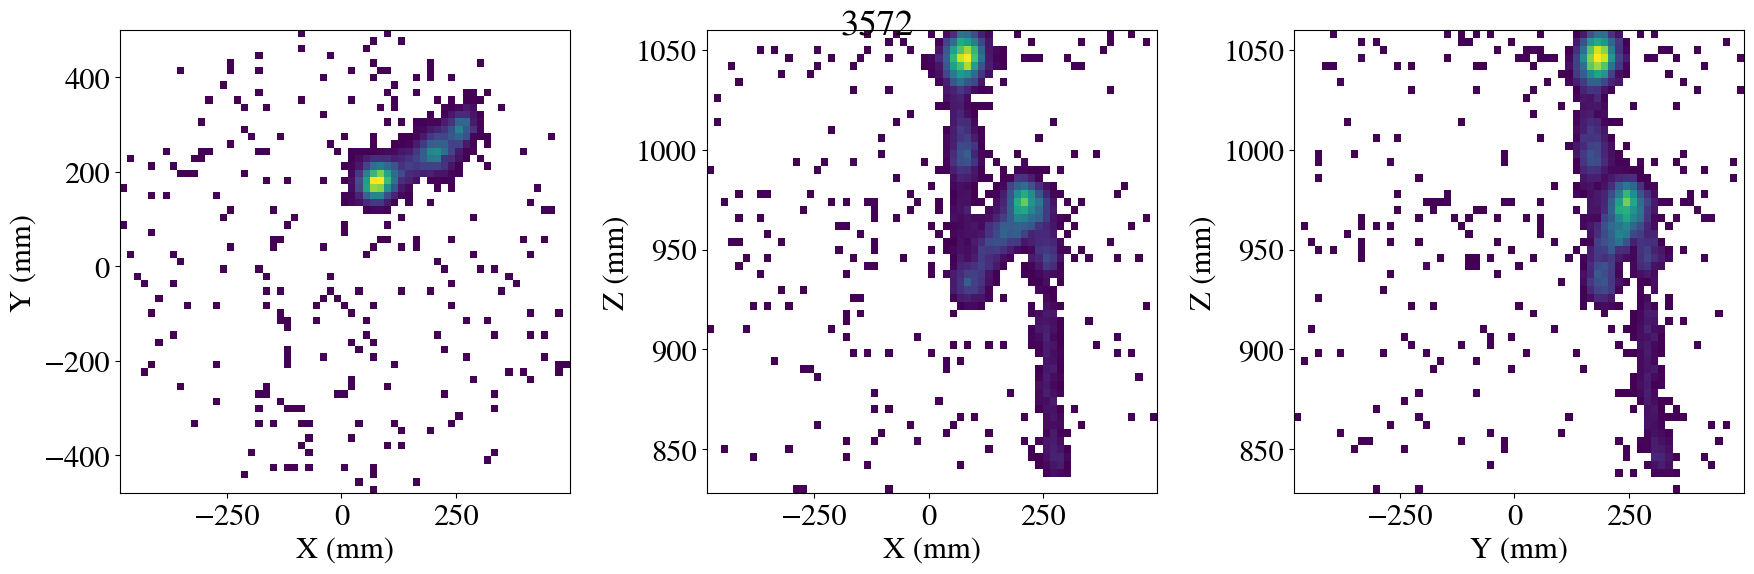

In [48]:
evt = 2
raw_plotter(soph_hdst[soph_hdst.event == soph_hdst.event.unique()[evt]], soph_hdst.event.unique()[evt])

In [49]:
import time

cut_hdst = cut_sensors(soph_hdst)


execution_times_2d = []
for _ in range(5):
    start_time = time.time()
    drop_hdst_2d = drop_sensors_2D(cut_hdst)
    execution_times_2d.append(time.time() - start_time)

# Calculate the average execution time
average_time = sum(execution_times_2d) / len(execution_times_2d)
print(f"Average execution time over 5 runs for 2D sensors: {average_time:.4f} seconds")

execution_times = []
for _ in range(5):
    start_time = time.time()
    drop_hdst = drop_sensors(cut_hdst)
    execution_times.append(time.time() - start_time)

# Calculate the average execution time
average_time = sum(execution_times) / len(execution_times)
print(f"Average execution time over 5 runs for 3D clusters: {average_time:.4f} seconds")


/home/e78368jw/anaconda3/envs/IC-3.8-2024-06-08/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(*inputs, **kwargs)


Average execution time over 5 runs for 2D sensors: 7.3394 seconds
Average execution time over 5 runs for 3D clusters: 7.3870 seconds


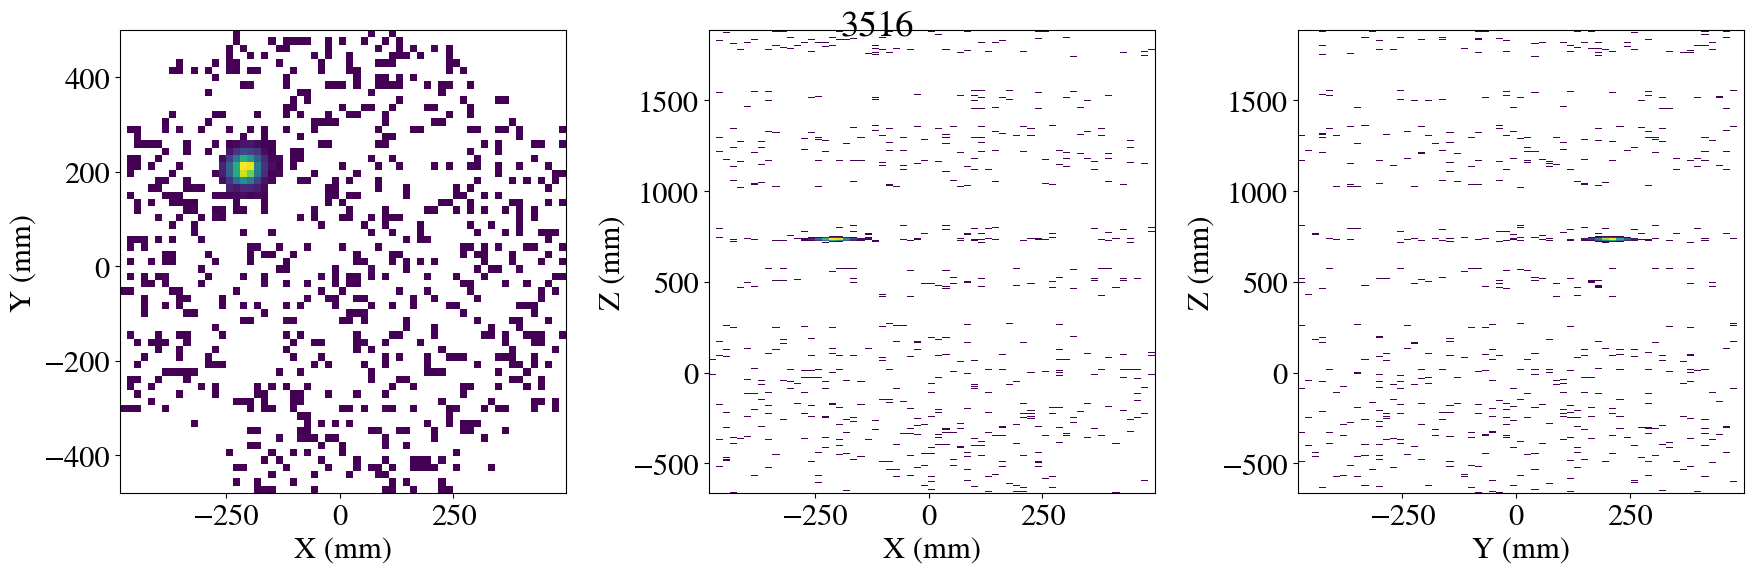

In [87]:
evt = 0
raw_plotter(soph_hdst[soph_hdst.event == soph_hdst.event.unique()[evt]], soph_hdst.event.unique()[evt])

# look at the events

=
=
=
=
=



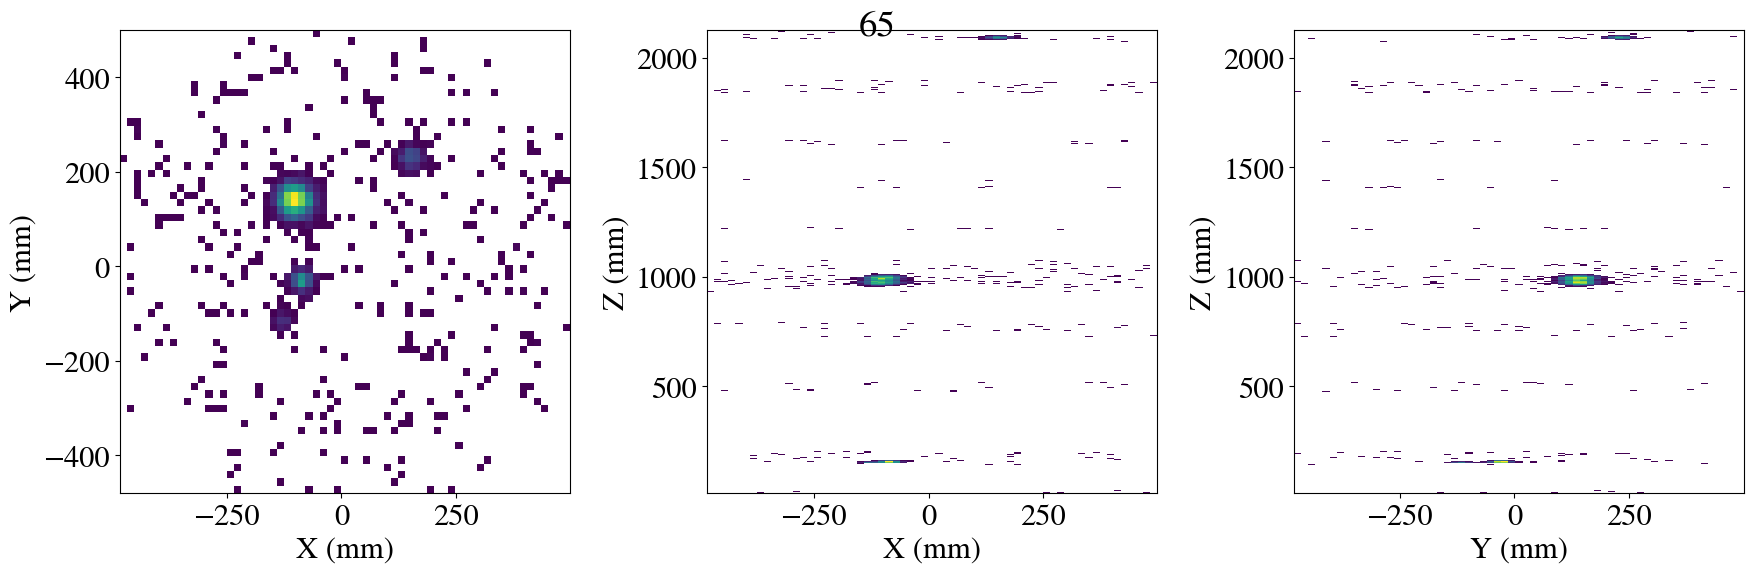

Cluster size: 2
Passing cluster: {13, 14}
Cluster size: 108
Passing cluster: {29, 30, 31, 32, 33, 34, 35, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 138, 139, 140, 141, 143}
Cluster size: 3
Passing cluster: {142, 134, 135}
Cluster size: 2
Passing cluster: {244, 239}
Cluster size: 496
Passing cluster: {268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 

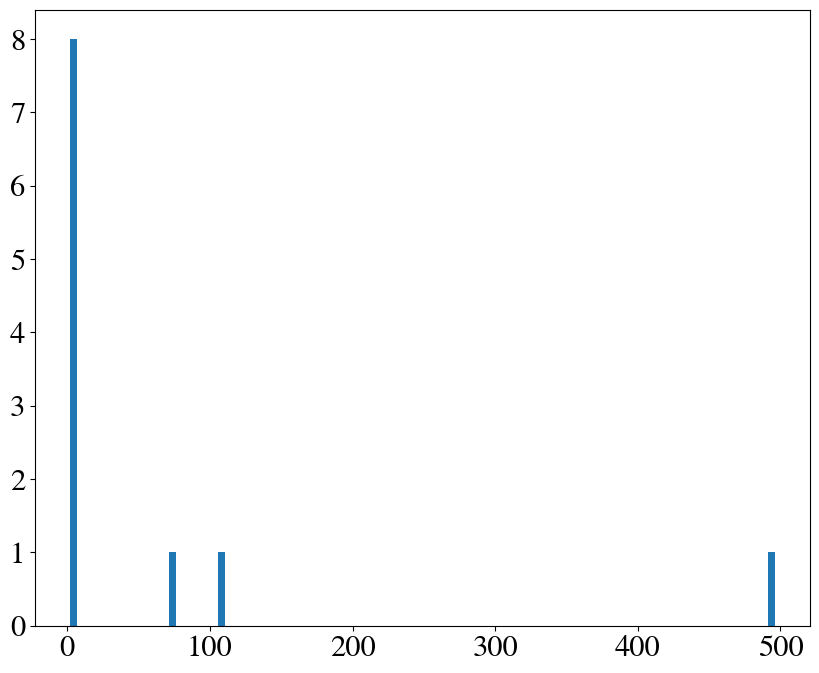

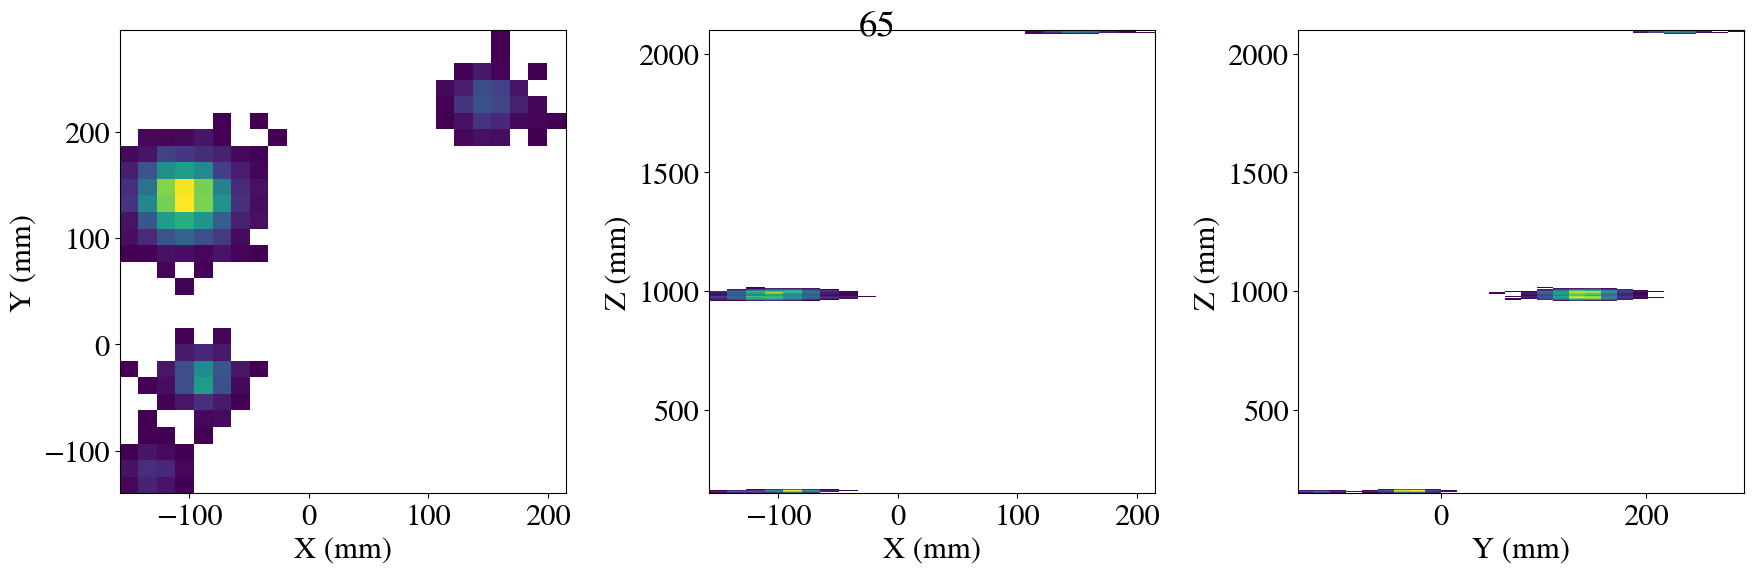

=
=
=
=
=



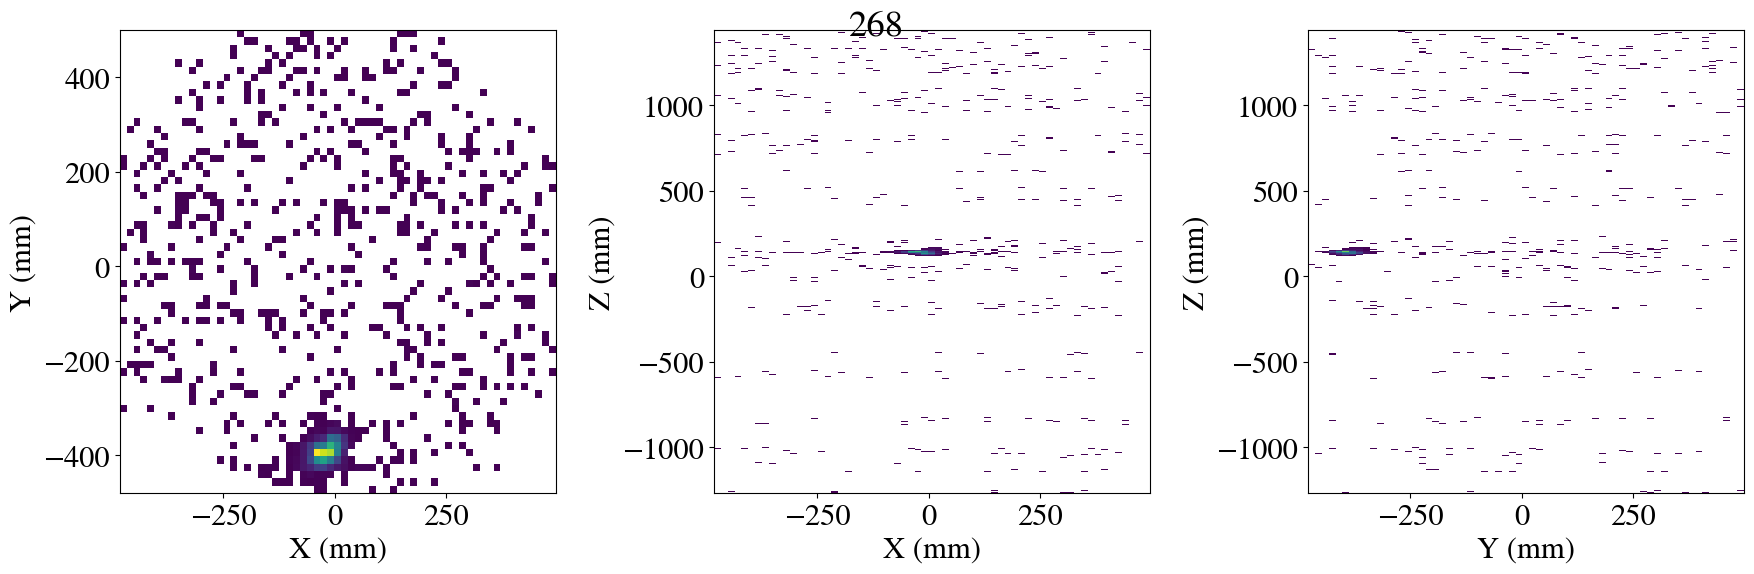

Cluster size: 349
Passing cluster: {1343, 1344, 1345, 1346, 1347, 1348, 1349, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1414, 1415, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513

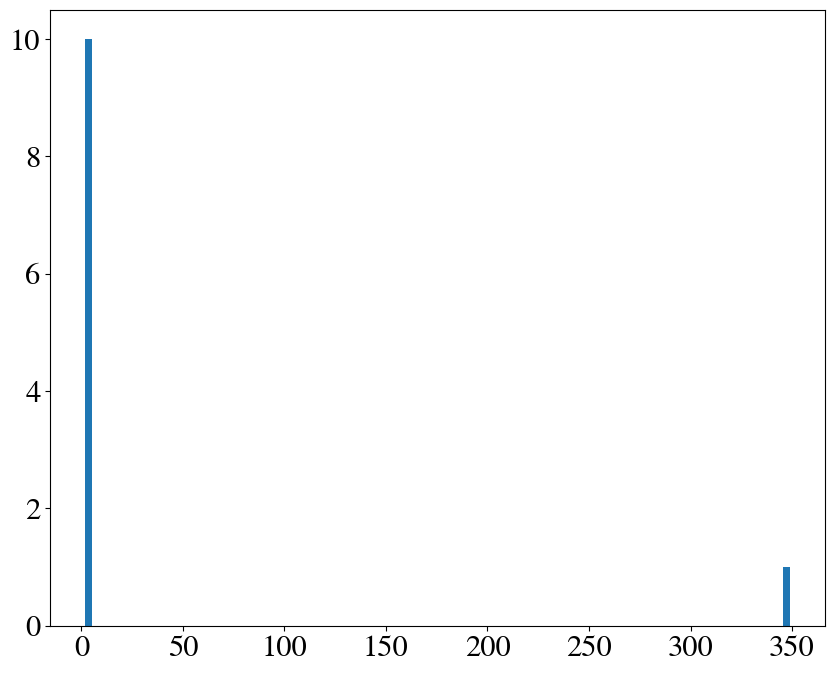

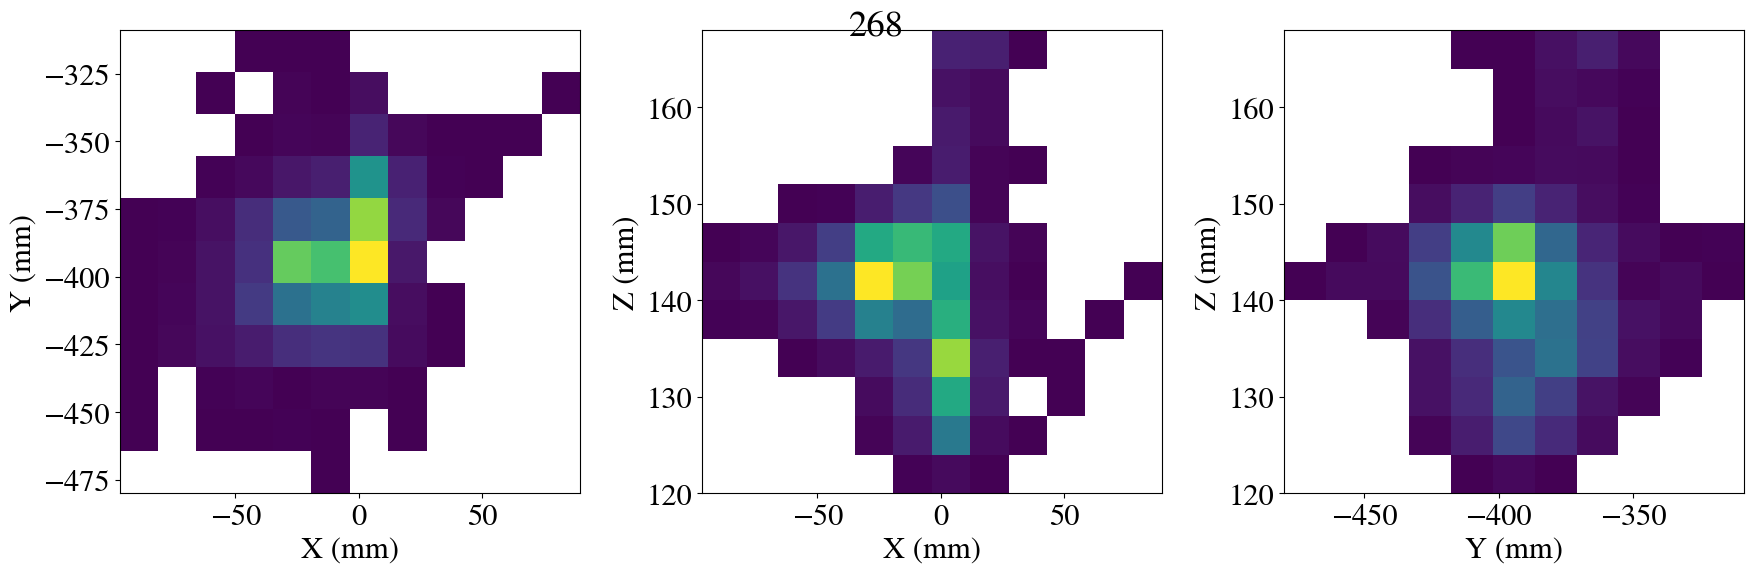

=
=
=
=
=



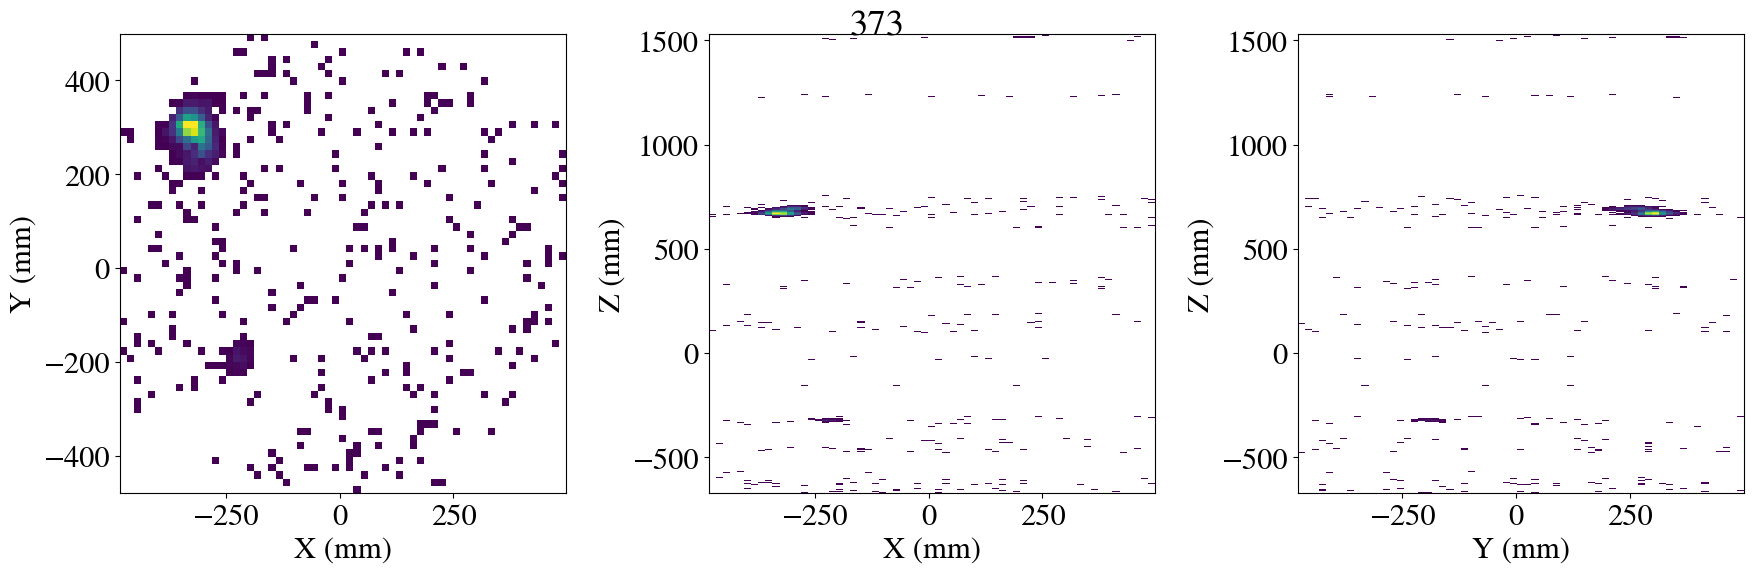

Cluster size: 492
Passing cluster: {2380, 2381, 2382, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548

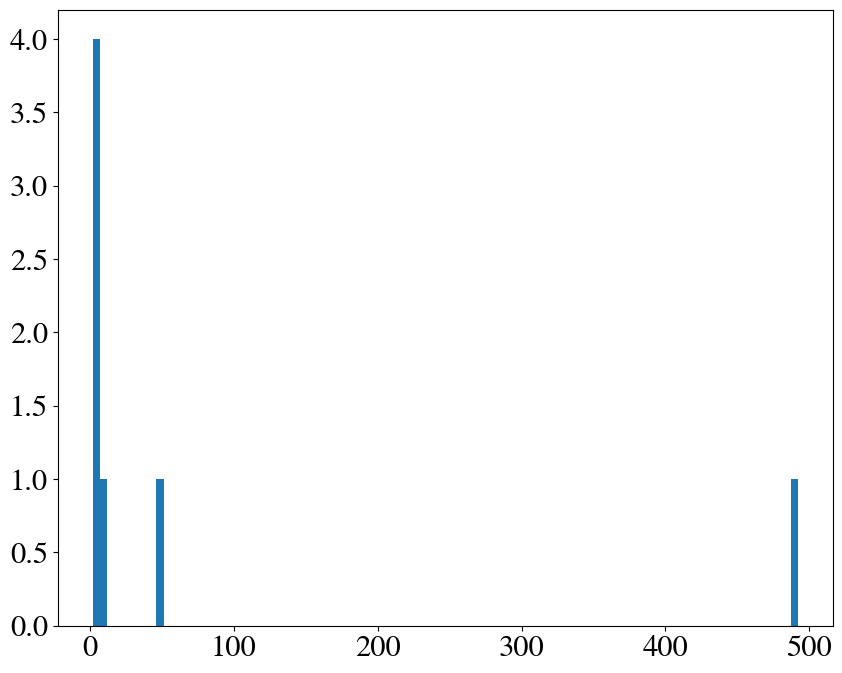

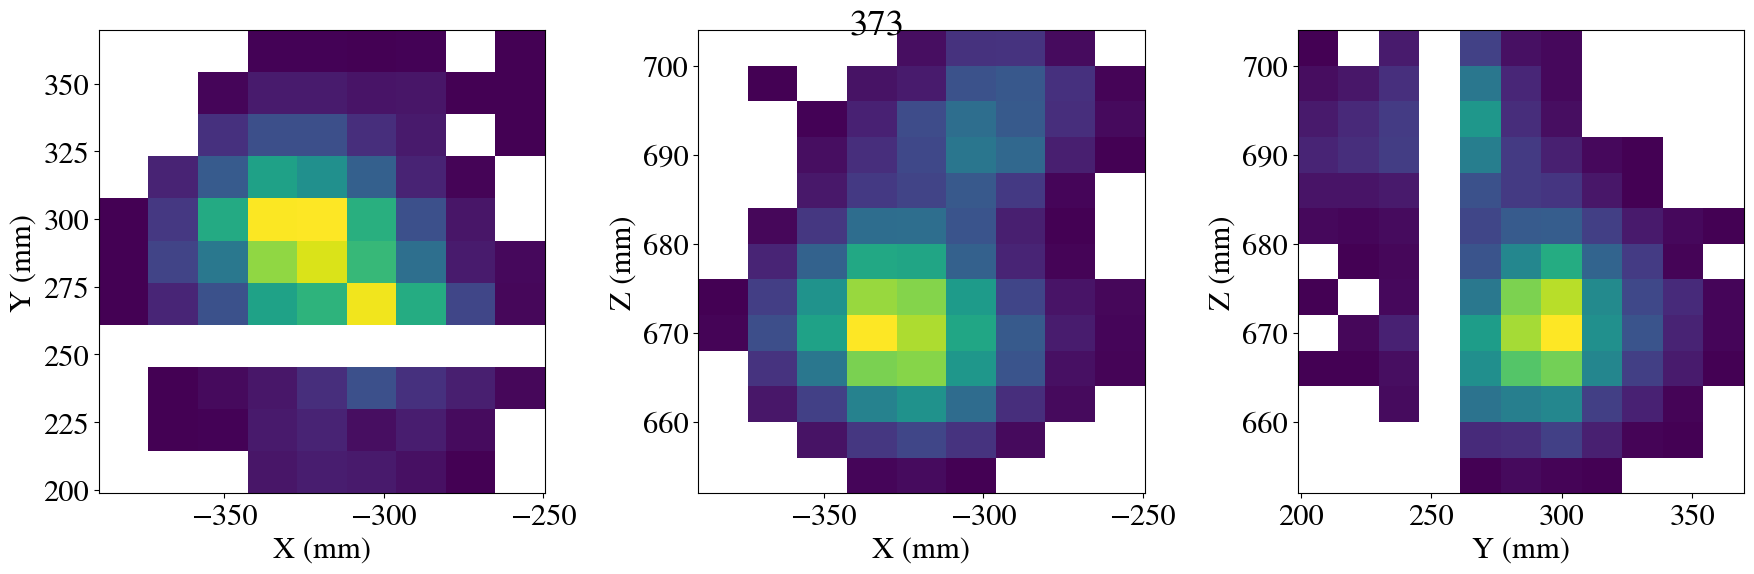

=
=
=
=
=



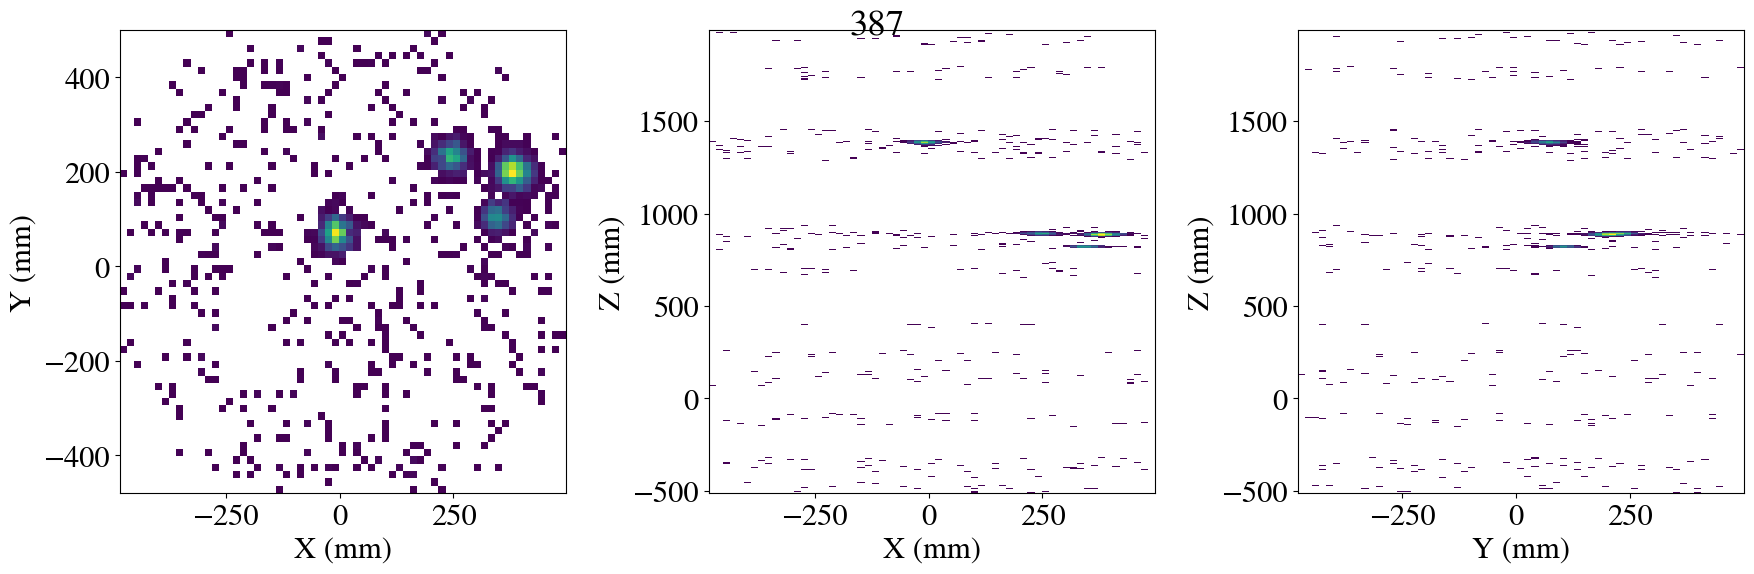

Cluster size: 371
Passing cluster: {3289, 3291, 3292, 3293, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3311, 3312, 3313, 3314, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3345, 3346, 3347, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399, 3400, 3401, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3421, 3422, 3424, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3444, 3445, 3446, 3447, 3466, 3467, 3468, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3506, 3508, 3509, 3510, 3538, 3539, 3540, 3541, 3542

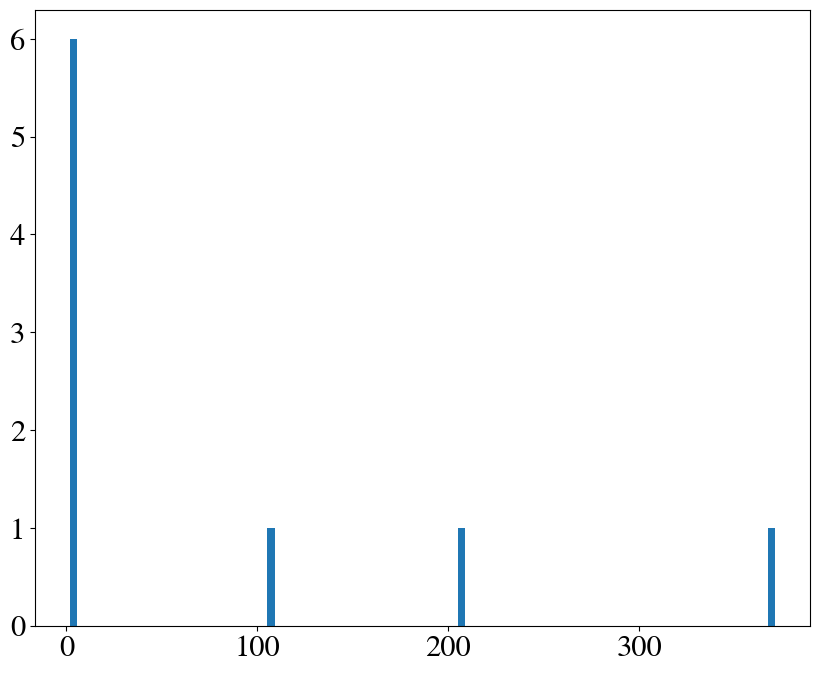

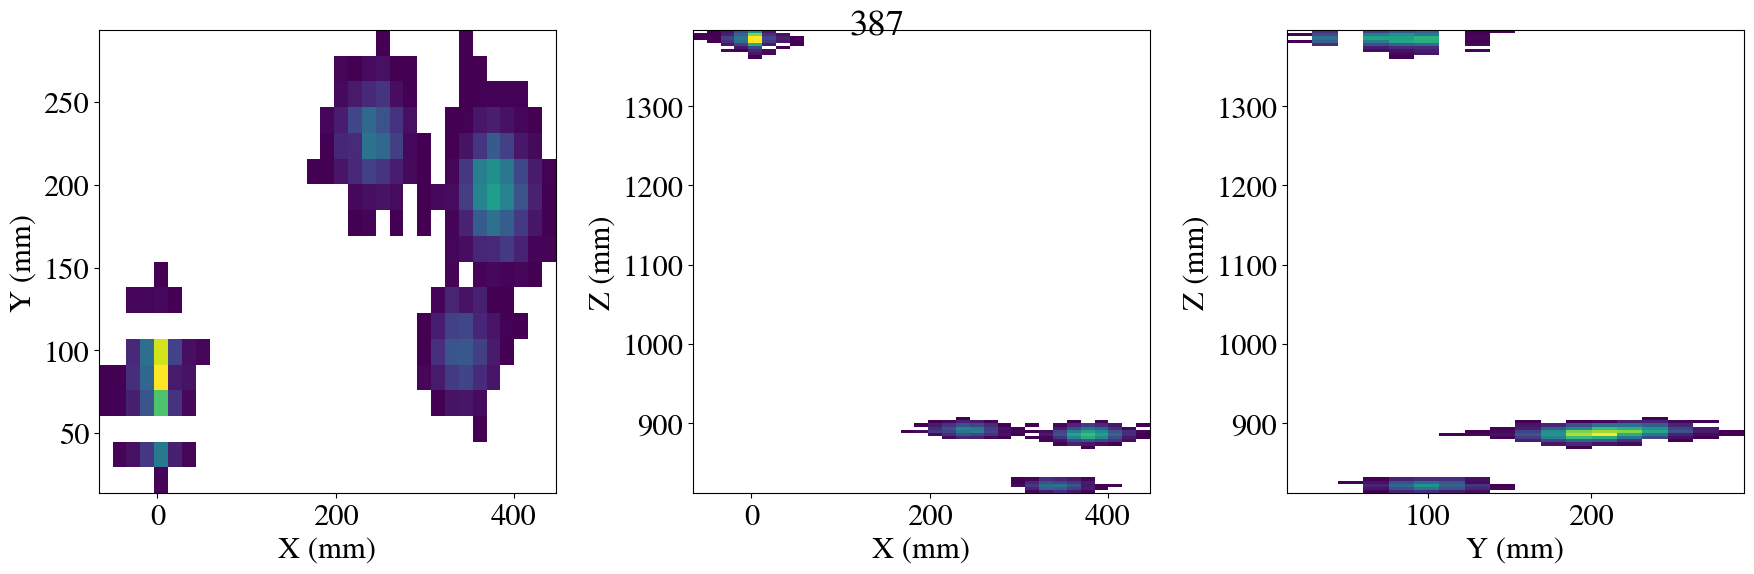

=
=
=
=
=



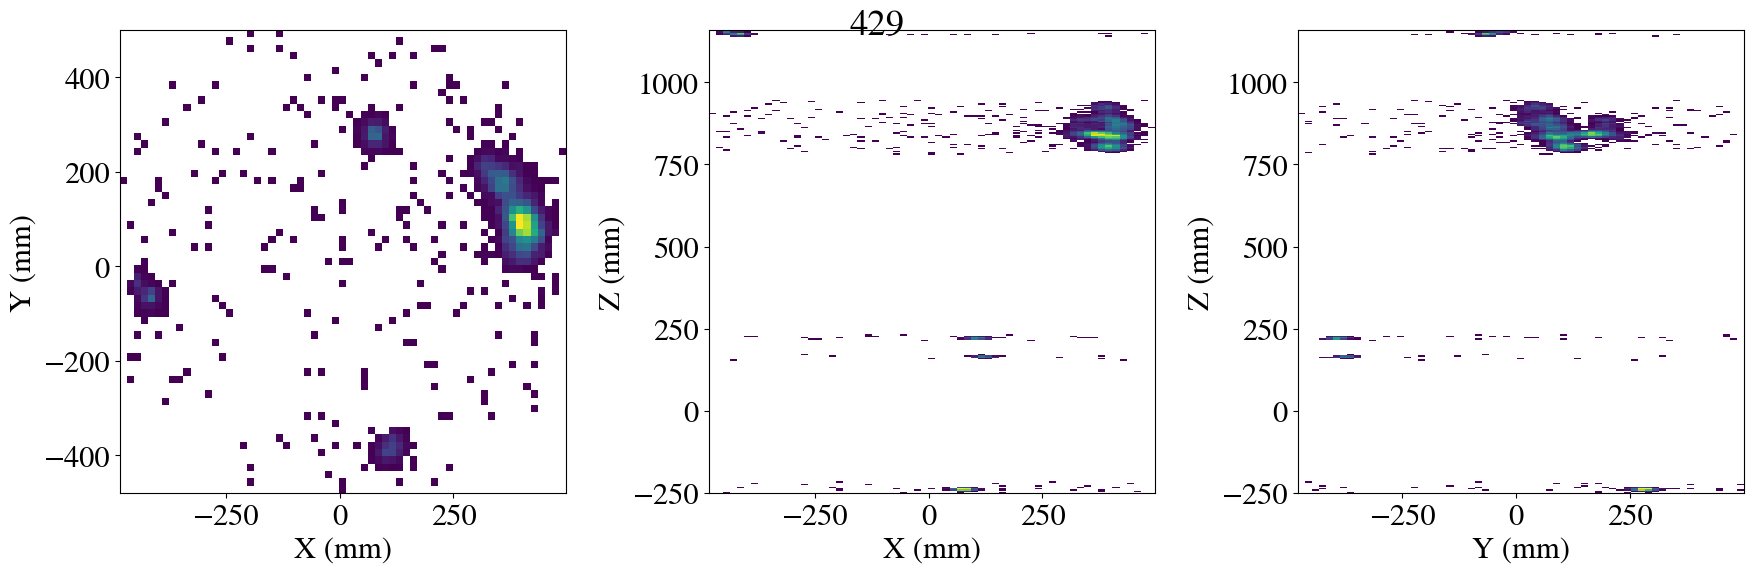

Cluster size: 1599
Passing cluster: {4589, 4592, 4594, 4595, 4596, 4597, 4602, 4603, 4604, 4605, 4606, 4607, 4608, 4609, 4610, 4611, 4612, 4613, 4614, 4615, 4616, 4617, 4618, 4619, 4620, 4621, 4622, 4623, 4624, 4625, 4626, 4627, 4628, 4629, 4630, 4631, 4632, 4633, 4641, 4642, 4643, 4644, 4645, 4646, 4647, 4648, 4649, 4650, 4651, 4652, 4653, 4654, 4655, 4656, 4657, 4658, 4659, 4660, 4661, 4662, 4663, 4664, 4665, 4666, 4667, 4668, 4669, 4670, 4671, 4672, 4673, 4674, 4675, 4676, 4677, 4678, 4679, 4680, 4681, 4682, 4683, 4684, 4685, 4686, 4687, 4688, 4689, 4690, 4691, 4692, 4693, 4694, 4695, 4696, 4697, 4698, 4699, 4700, 4701, 4702, 4703, 4704, 4705, 4706, 4707, 4708, 4709, 4710, 4711, 4712, 4713, 4714, 4715, 4716, 4717, 4722, 4724, 4725, 4726, 4727, 4728, 4729, 4730, 4731, 4732, 4733, 4734, 4735, 4736, 4737, 4738, 4739, 4740, 4741, 4742, 4743, 4744, 4745, 4746, 4747, 4748, 4749, 4750, 4751, 4752, 4753, 4754, 4755, 4756, 4757, 4758, 4759, 4760, 4761, 4762, 4763, 4764, 4765, 4766, 4767, 476

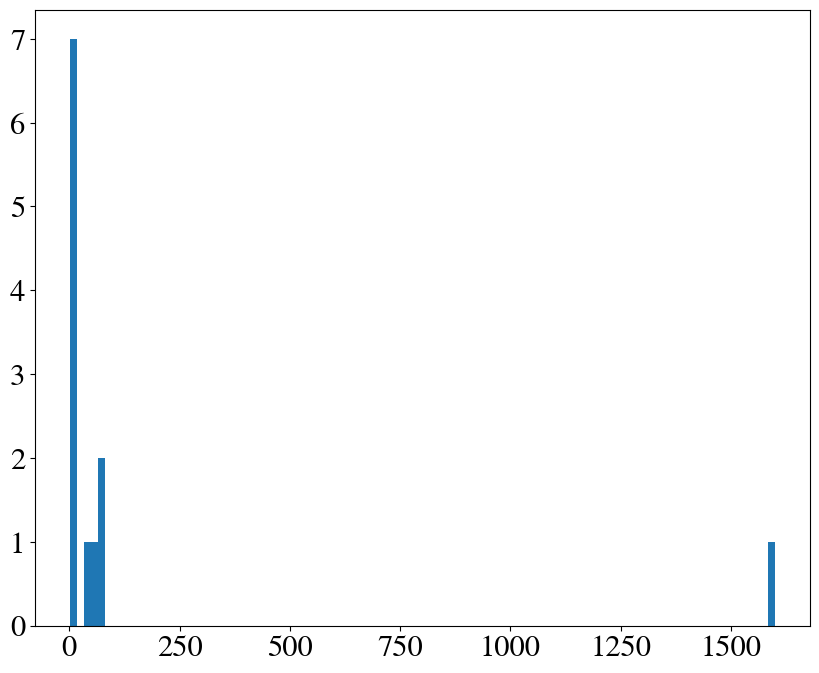

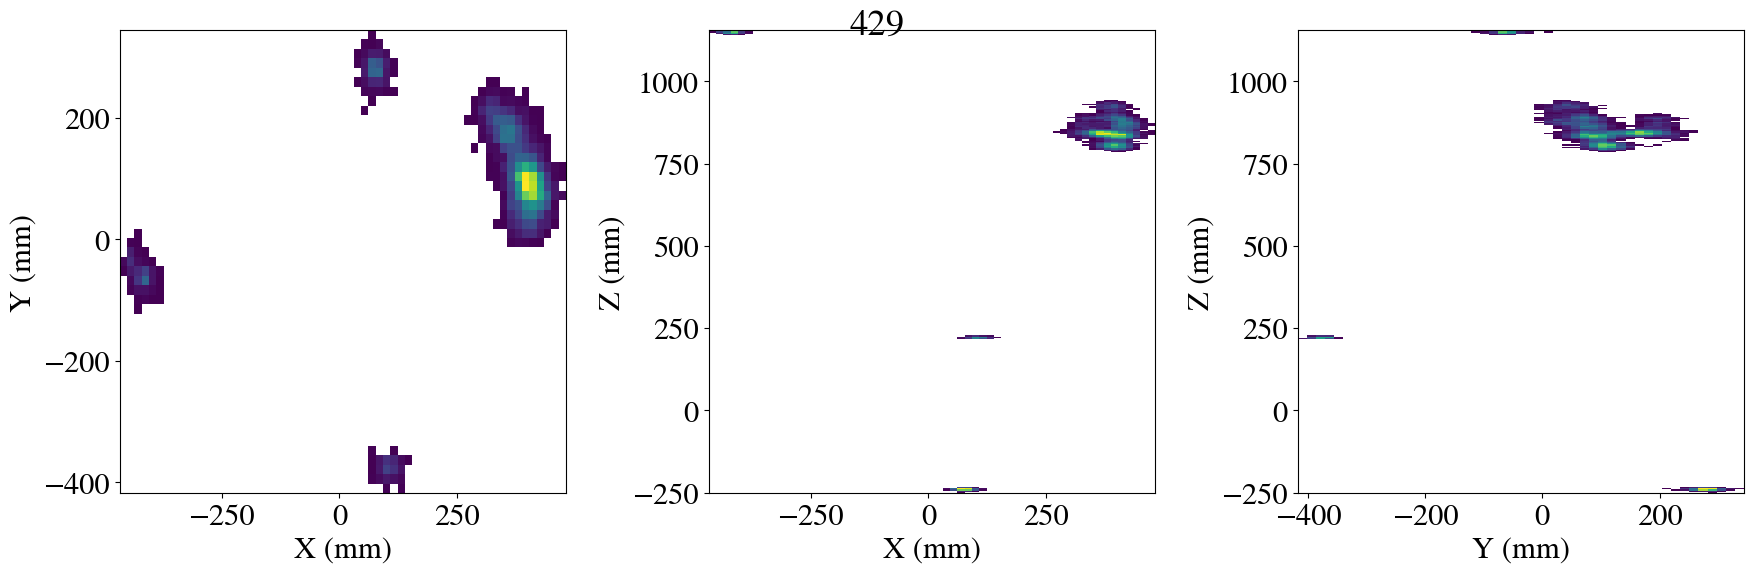

=
=
=
=
=



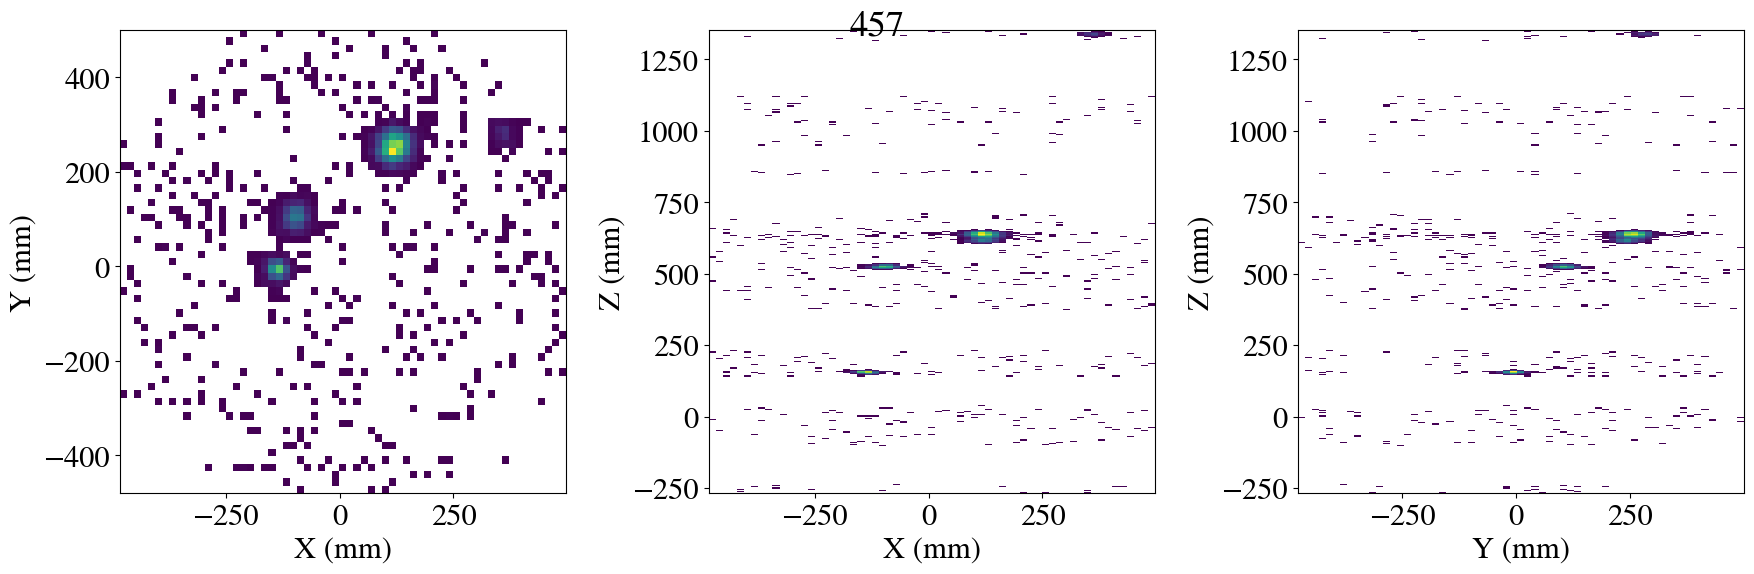

Cluster size: 152
Passing cluster: {6688, 6689, 6690, 6691, 6692, 6693, 6694, 6695, 6697, 6698, 6699, 6700, 6701, 6702, 6703, 6704, 6705, 6706, 6707, 6708, 6709, 6710, 6711, 6712, 6713, 6714, 6715, 6716, 6719, 6720, 6721, 6722, 6723, 6724, 6725, 6726, 6727, 6728, 6729, 6730, 6731, 6732, 6733, 6734, 6735, 6736, 6737, 6738, 6739, 6740, 6741, 6742, 6743, 6744, 6745, 6746, 6747, 6748, 6749, 6750, 6751, 6752, 6753, 6754, 6755, 6756, 6757, 6758, 6759, 6760, 6761, 6762, 6763, 6764, 6765, 6766, 6767, 6768, 6769, 6770, 6771, 6772, 6773, 6774, 6775, 6776, 6777, 6778, 6779, 6780, 6781, 6782, 6783, 6784, 6785, 6786, 6787, 6788, 6789, 6790, 6791, 6792, 6793, 6794, 6795, 6796, 6797, 6798, 6799, 6800, 6801, 6802, 6803, 6804, 6805, 6806, 6807, 6808, 6809, 6810, 6811, 6812, 6813, 6814, 6815, 6816, 6817, 6818, 6819, 6820, 6821, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6844}
Cluster size: 440
Passing cluster: {6954, 6957, 6958

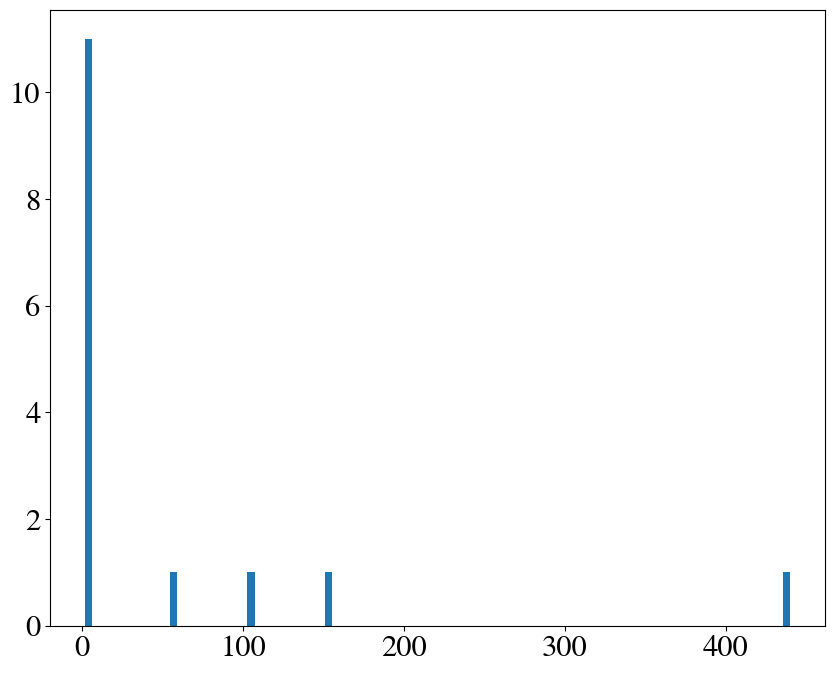

=
=
=
=
=



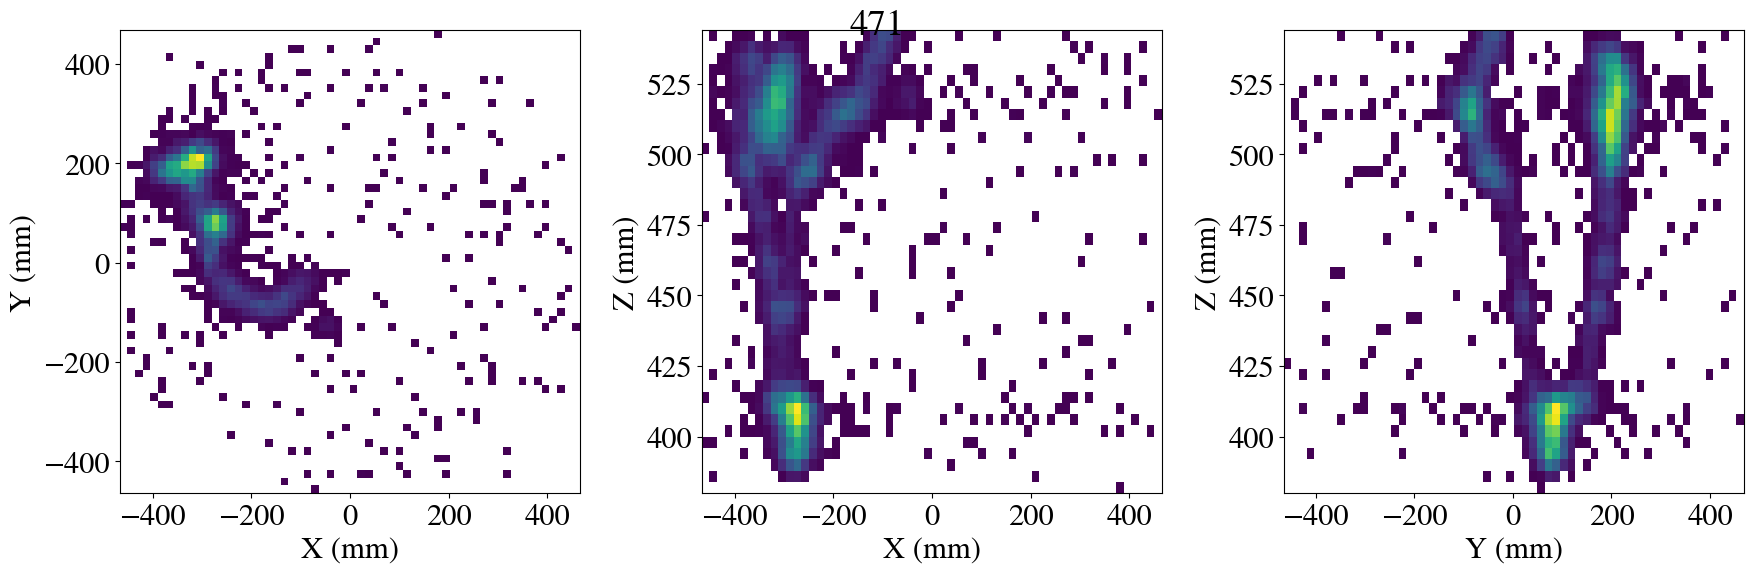

Cluster size: 2119
Passing cluster: {8192, 8193, 8194, 8195, 8196, 8197, 8198, 8199, 8200, 8201, 8202, 8203, 8204, 8205, 8206, 8207, 8208, 8209, 8210, 8211, 8212, 8213, 8214, 8215, 8216, 8217, 8218, 8219, 8220, 8221, 8222, 8223, 8224, 8225, 8226, 8227, 8228, 8229, 8230, 8231, 8232, 8233, 8234, 8235, 8238, 8239, 8240, 8241, 8242, 8243, 8244, 8245, 8246, 8247, 8248, 8249, 8250, 8251, 8252, 8253, 8254, 8255, 8256, 8257, 8258, 8259, 8260, 8261, 8263, 8264, 8265, 8266, 8267, 8268, 8269, 8270, 8271, 8272, 8273, 8274, 8275, 8276, 8277, 8278, 8279, 8280, 8281, 8282, 8283, 8284, 8285, 8286, 8287, 8288, 8289, 8290, 8291, 8292, 8293, 8294, 8295, 8296, 8297, 8298, 8299, 8300, 8301, 8302, 8303, 8304, 8305, 8306, 8307, 8308, 8309, 8310, 8311, 8312, 8313, 8314, 8315, 8316, 8317, 8318, 8319, 8320, 8321, 8322, 8323, 8324, 8325, 8326, 8327, 8328, 8329, 8330, 8331, 8332, 8333, 8334, 8335, 8336, 8337, 8338, 8339, 8340, 8341, 8342, 8343, 8344, 8345, 8346, 8347, 8348, 8349, 8350, 8351, 8352, 8353, 8354, 835

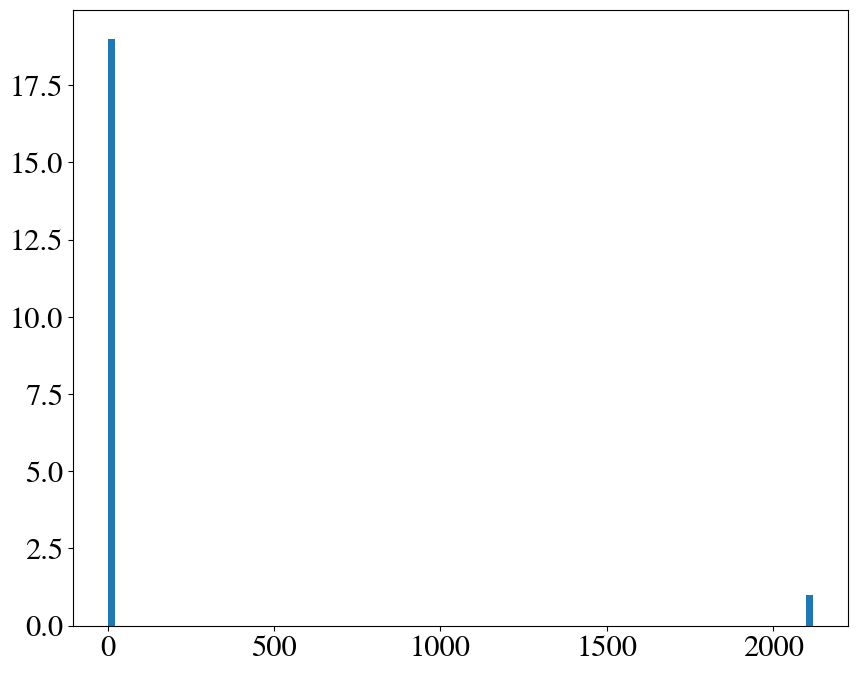

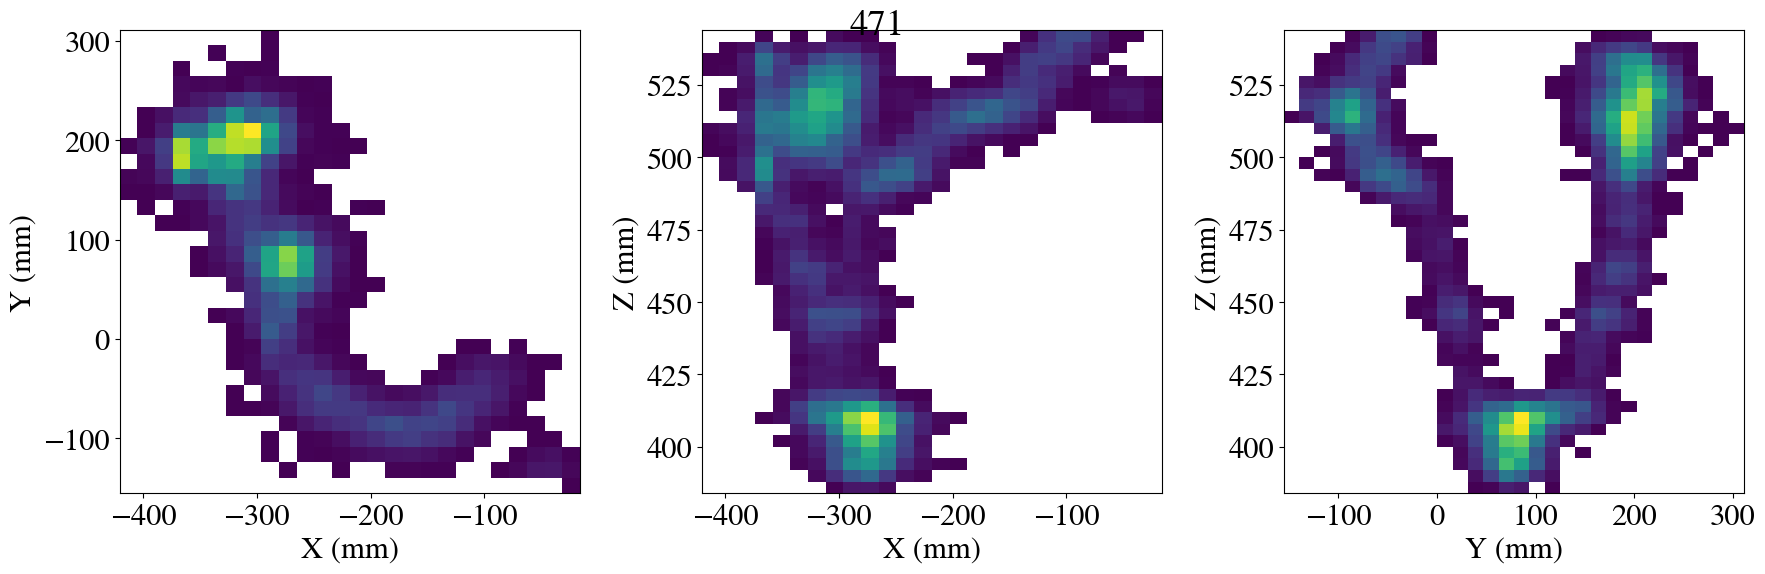

=
=
=
=
=



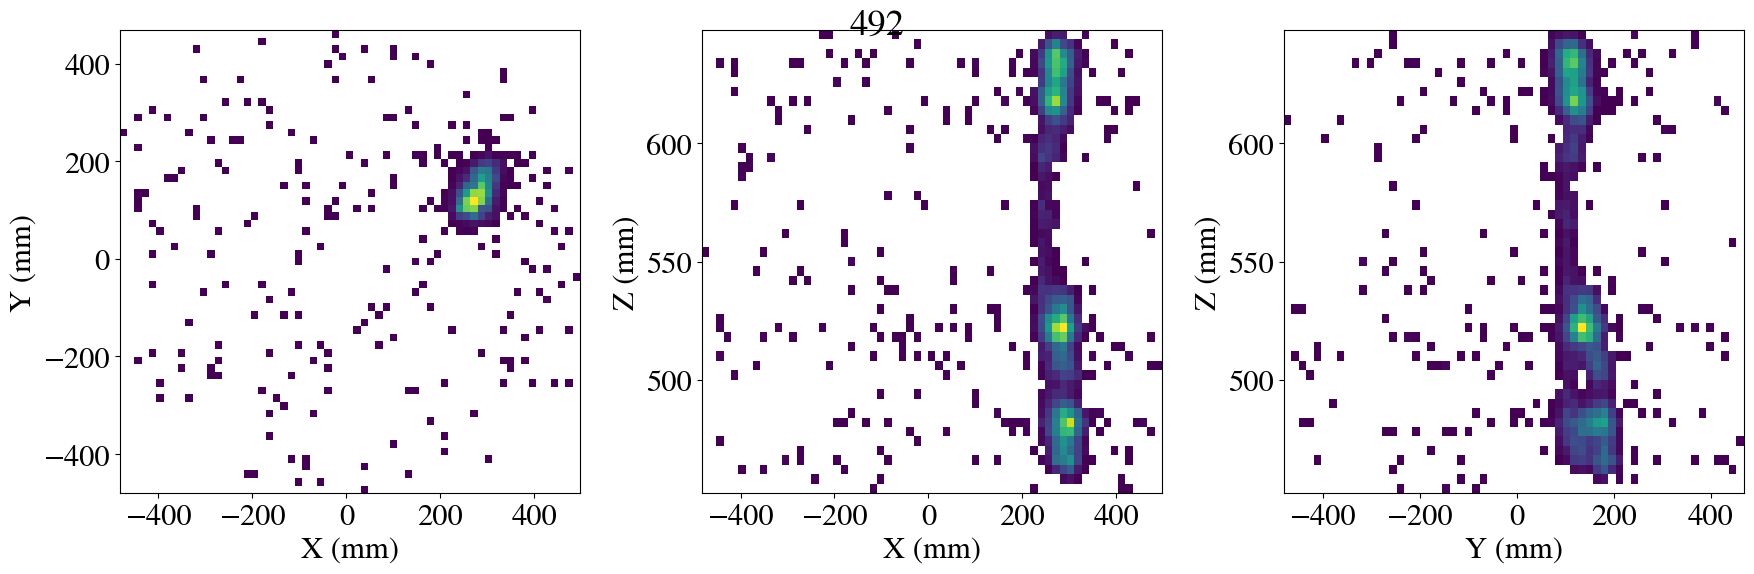

Cluster size: 1118
Passing cluster: {10240, 10241, 10242, 10243, 10244, 10245, 10246, 10247, 10248, 10249, 10253, 10254, 10255, 10256, 10257, 10258, 10259, 10260, 10261, 10262, 10263, 10264, 10265, 10266, 10267, 10268, 10269, 10270, 10271, 10272, 10273, 10274, 10275, 10276, 10277, 10278, 10279, 10280, 10281, 10282, 10283, 10284, 10285, 10286, 10287, 10288, 10289, 10290, 10291, 10292, 10293, 10294, 10295, 10296, 10297, 10298, 10299, 10300, 10301, 10302, 10303, 10304, 10305, 10306, 10307, 10308, 10309, 10310, 10311, 10312, 10313, 10314, 10315, 10316, 10317, 10318, 10319, 10320, 10321, 10322, 10323, 10324, 10325, 10326, 10327, 10328, 10329, 10330, 10331, 10332, 10333, 10334, 10335, 10336, 10337, 10338, 10339, 10340, 10341, 10342, 10343, 10344, 10345, 10346, 10347, 10348, 10349, 10350, 10351, 10352, 10353, 10354, 10355, 10356, 10357, 10358, 10359, 10360, 10361, 10362, 10363, 10364, 10365, 10366, 10367, 10368, 10369, 10370, 10371, 10372, 10373, 10374, 10375, 10376, 10377, 10378, 10379, 1038

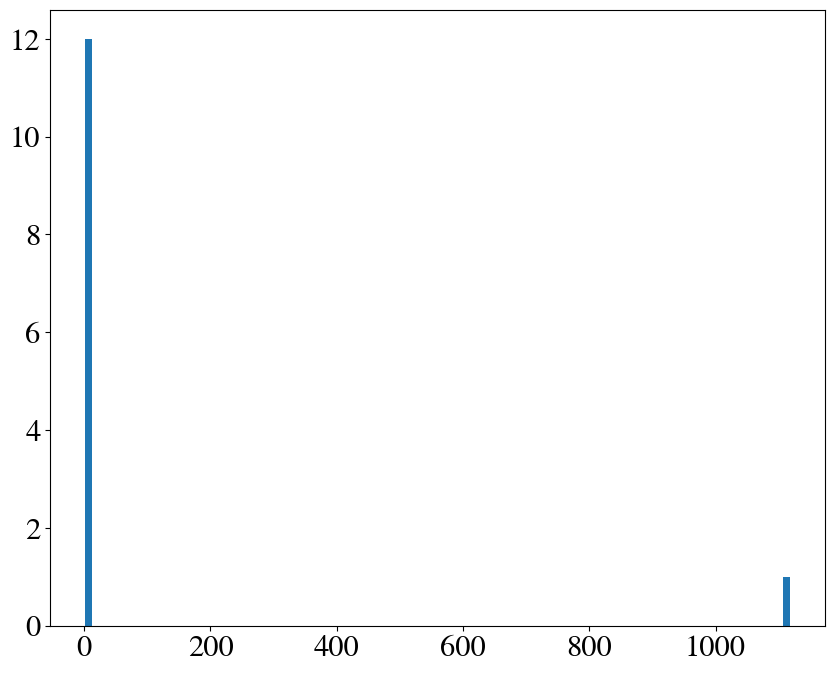

=
=
=
=
=



Cluster size: 263
Passing cluster: {11400, 11404, 11405, 11406, 11408, 11409, 11410, 11414, 11415, 11416, 11417, 11418, 11419, 11420, 11421, 11422, 11423, 11424, 11425, 11426, 11427, 11428, 11429, 11430, 11431, 11432, 11433, 11435, 11436, 11437, 11438, 11445, 11446, 11447, 11448, 11449, 11450, 11451, 11452, 11453, 11454, 11455, 11457, 11458, 11459, 11460, 11461, 11462, 11463, 11464, 11465, 11466, 11467, 11468, 11469, 11470, 11471, 11472, 11473, 11474, 11475, 11476, 11477, 11478, 11479, 11480, 11481, 11482, 11483, 11484, 11485, 11486, 11487, 11488, 11489, 11490, 11491, 11492, 11493, 11494, 11495, 11496, 11497, 11498, 11499, 11500, 11501, 11502, 11503, 11504, 11505, 11506, 11507, 11508, 11509, 11510, 11511, 11512, 11513, 11514, 11515, 11516, 11517, 11518, 11519, 11520, 11521, 11522, 11523, 11524, 11525, 11526, 11527, 11528, 11529, 11530, 11531, 11532, 11533, 11534, 11535, 11536, 11539, 11540, 11541, 11542, 11543, 11544, 11545, 11546, 11547, 11548, 11549, 11550, 11551, 11552, 11553, 11554

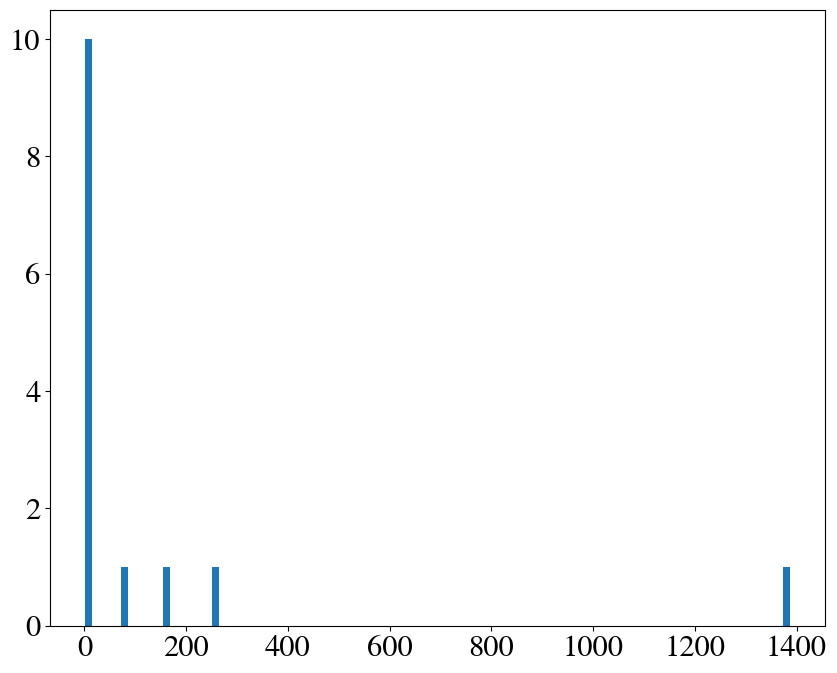

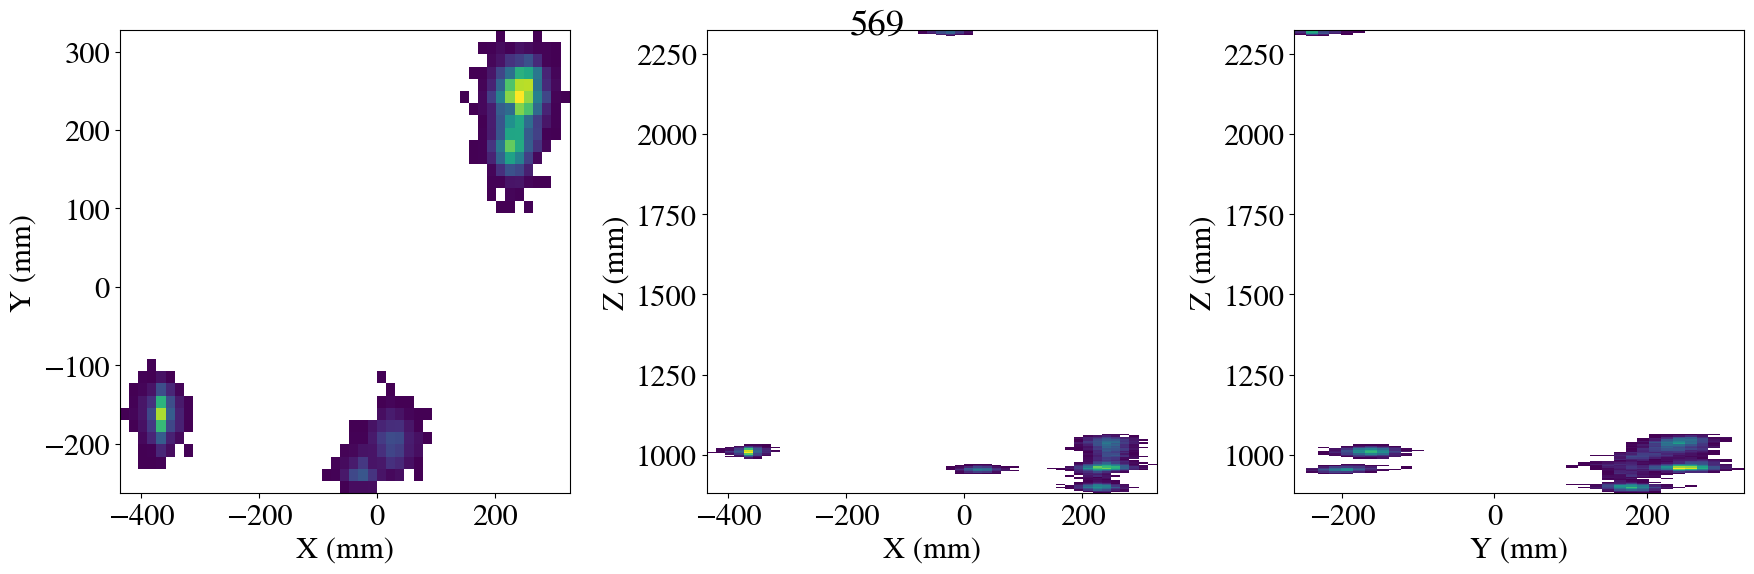

=
=
=
=
=



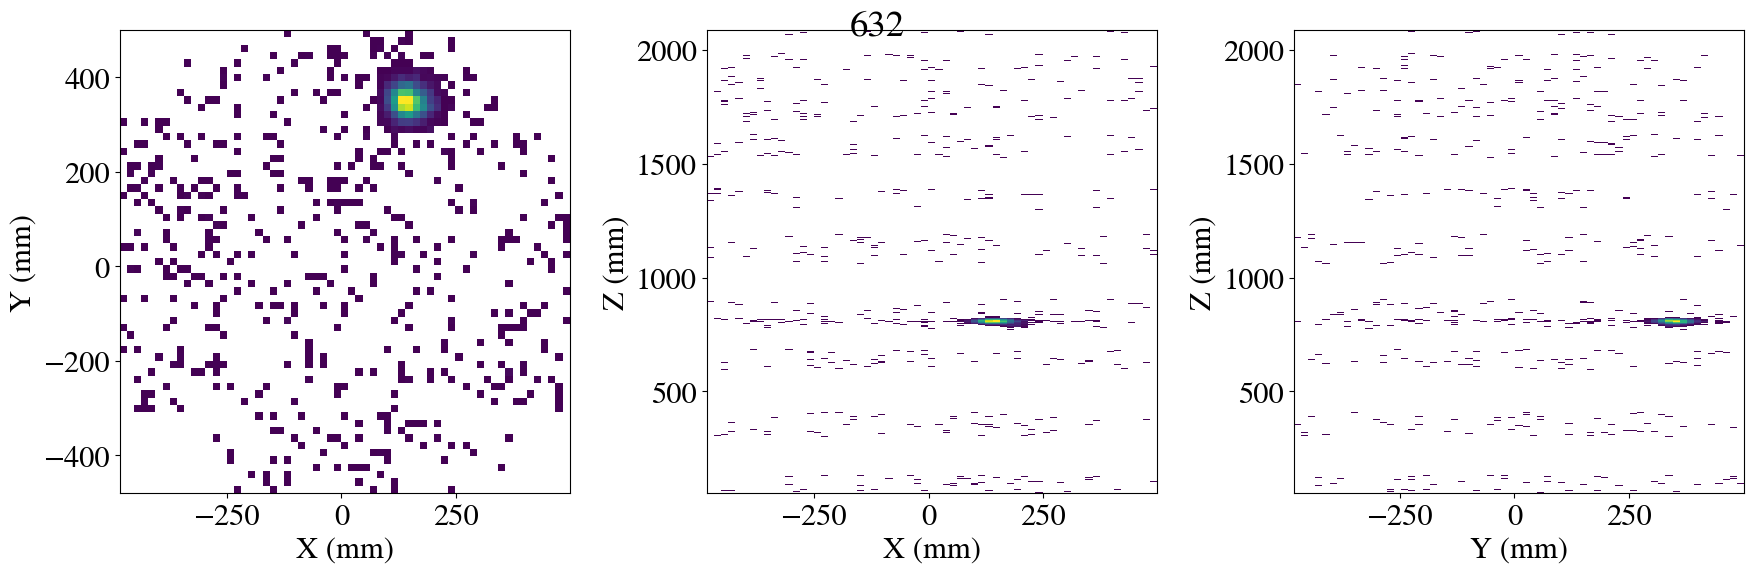

Cluster size: 423
Passing cluster: {14336, 14337, 14338, 14339, 14340, 14341, 14344, 14345, 14346, 14347, 14348, 14353, 14354, 14356, 13896, 13902, 13903, 13904, 13905, 13906, 13907, 13908, 13909, 13910, 13911, 13912, 13913, 13914, 13915, 13916, 13917, 13918, 13919, 13920, 13921, 13926, 13927, 13928, 13929, 13930, 13931, 13932, 13933, 13934, 13935, 13936, 13937, 13938, 13939, 13940, 13941, 13942, 13943, 13944, 13945, 13946, 13947, 13948, 13949, 13950, 13951, 13952, 13953, 13954, 13955, 13956, 13957, 13958, 13959, 13965, 13966, 13967, 13968, 13969, 13970, 13971, 13972, 13973, 13974, 13975, 13976, 13977, 13978, 13979, 13980, 13981, 13982, 13983, 13984, 13985, 13986, 13987, 13988, 13989, 13990, 13991, 13992, 13993, 13994, 13995, 13996, 13997, 13998, 13999, 14000, 14001, 14002, 14003, 14004, 14005, 14006, 14007, 14008, 14009, 14010, 14011, 14012, 14013, 14014, 14015, 14016, 14017, 14018, 14019, 14020, 14021, 14022, 14023, 14024, 14025, 14026, 14027, 14028, 14029, 14030, 14031, 14032, 14033

=
=
=
=
=



Cluster size: 201
Passing cluster: {15131, 15133, 15134, 15135, 15136, 15137, 15138, 15139, 15141, 15142, 15143, 15144, 15145, 15146, 15147, 15148, 15149, 15150, 15151, 15152, 15153, 15154, 15155, 15156, 15157, 15158, 15161, 15162, 15163, 15164, 15165, 15166, 15167, 15168, 15169, 15170, 15171, 15172, 15173, 15174, 15175, 15176, 15177, 15178, 15179, 15180, 15181, 15182, 15183, 15184, 15185, 15186, 15187, 15188, 15189, 15190, 15191, 15192, 15193, 15195, 15196, 15197, 15198, 15199, 15200, 15201, 15202, 15203, 15204, 15205, 15206, 15207, 15208, 15209, 15210, 15211, 15212, 15213, 15214, 15215, 15216, 15217, 15218, 15219, 15220, 15221, 15222, 15223, 15224, 15225, 15226, 15227, 15228, 15231, 15232, 15233, 15234, 15235, 15236, 15237, 15238, 15239, 15240, 15241, 15242, 15243, 15244, 15245, 15246, 15247, 15248, 15249, 15250, 15251, 15252, 15253, 15254, 15255, 15256, 15257, 15258, 15259, 15260, 15261, 15262, 15263, 15264, 15265, 15266, 15267, 15268, 15269, 15270, 15271, 15272, 15274, 15275, 15276

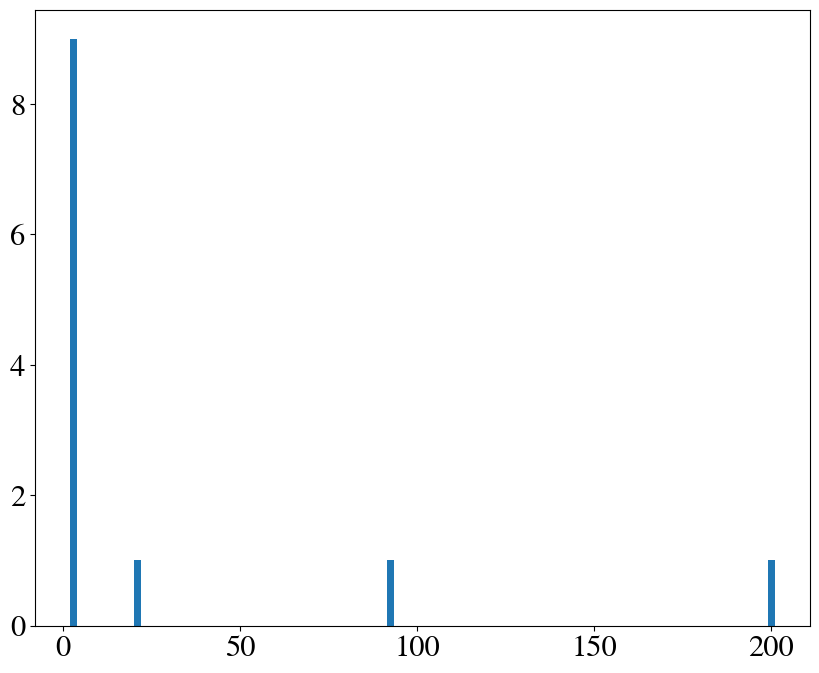

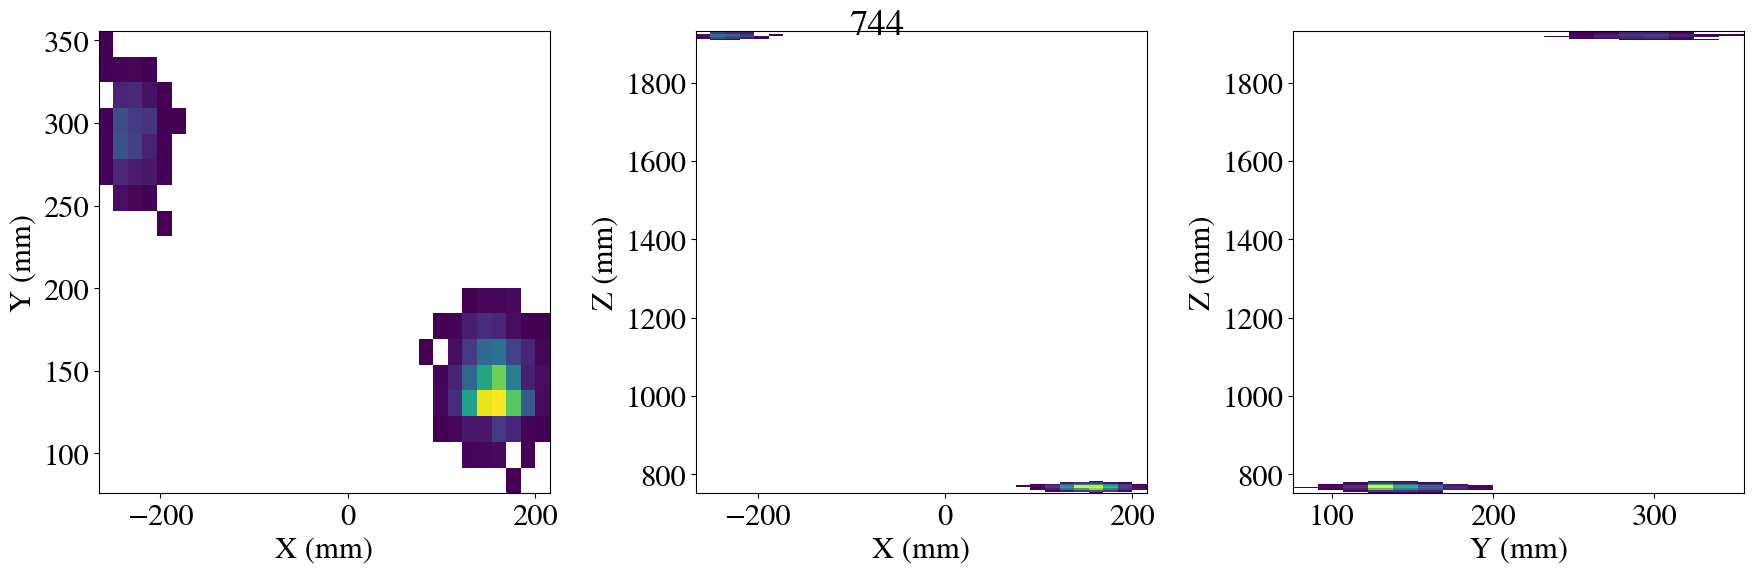

=
=
=
=
=



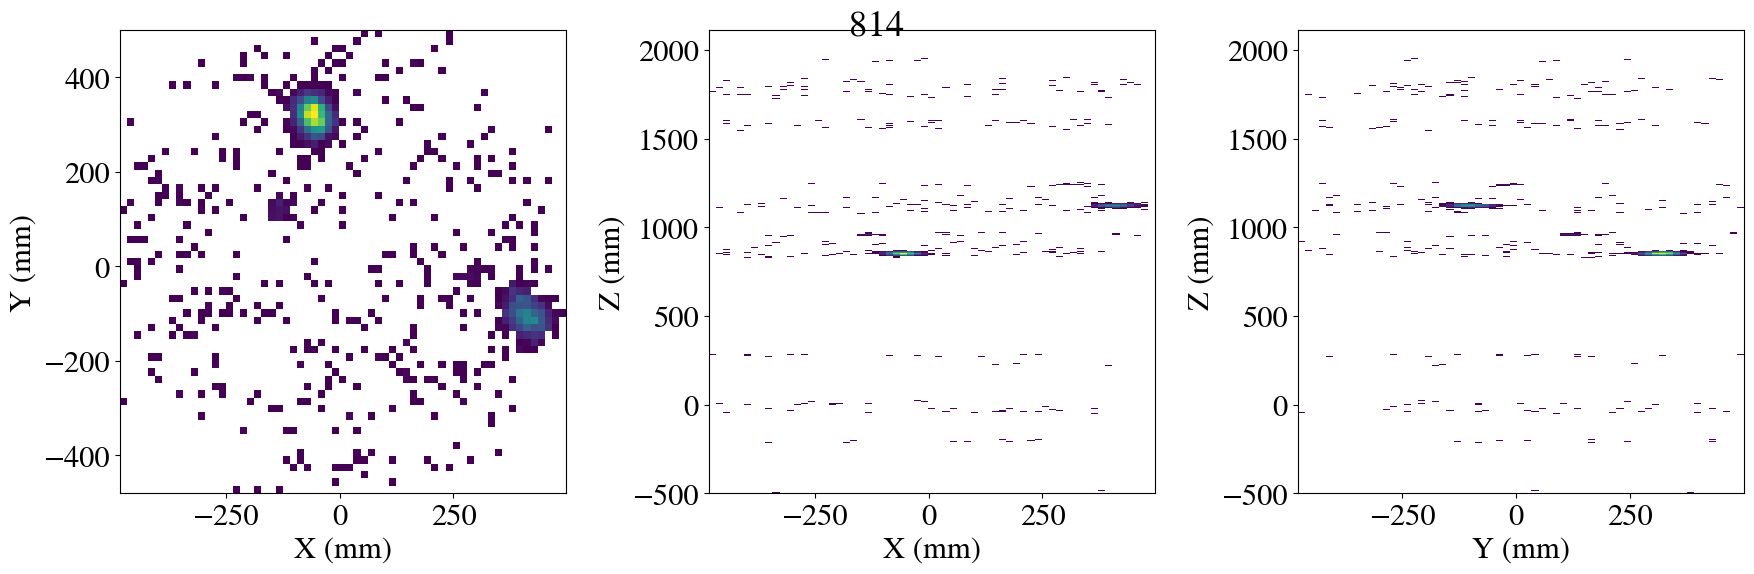

Cluster size: 256
Passing cluster: {16384, 16385, 16386, 16387, 16388, 16389, 16392, 16393, 16394, 16395, 16396, 16397, 16398, 16399, 16400, 16401, 16402, 16403, 16404, 16405, 16406, 16407, 16408, 16409, 16410, 16411, 16412, 16413, 16414, 16415, 16416, 16417, 16418, 16419, 16420, 16421, 16422, 16423, 16424, 16425, 16426, 16427, 16428, 16429, 16430, 16431, 16432, 16433, 16434, 16435, 16436, 16437, 16438, 16439, 16440, 16441, 16442, 16443, 16444, 16445, 16446, 16450, 16451, 16452, 16453, 16454, 16455, 16456, 16457, 16458, 16459, 16460, 16461, 16462, 16463, 16464, 16465, 16466, 16467, 16468, 16469, 16470, 16471, 16472, 16473, 16474, 16475, 16476, 16477, 16478, 16479, 16480, 16481, 16482, 16483, 16484, 16485, 16486, 16487, 16488, 16489, 16490, 16491, 16492, 16494, 16495, 16496, 16497, 16498, 16499, 16500, 16501, 16502, 16503, 16504, 16505, 16506, 16507, 16508, 16509, 16510, 16511, 16512, 16513, 16514, 16515, 16516, 16517, 16518, 16519, 16520, 16521, 16522, 16523, 16524, 16525, 16526, 16527

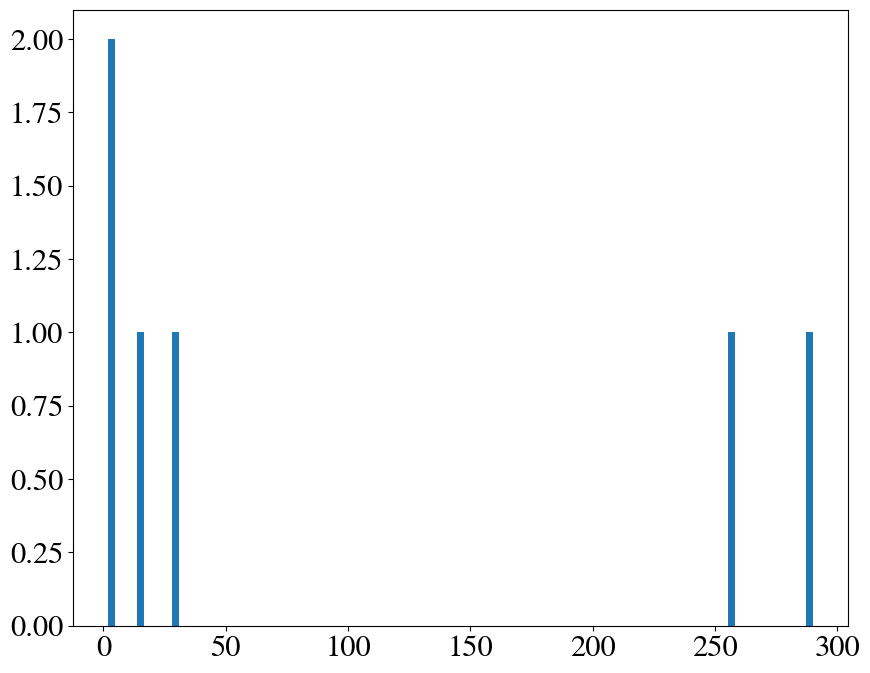

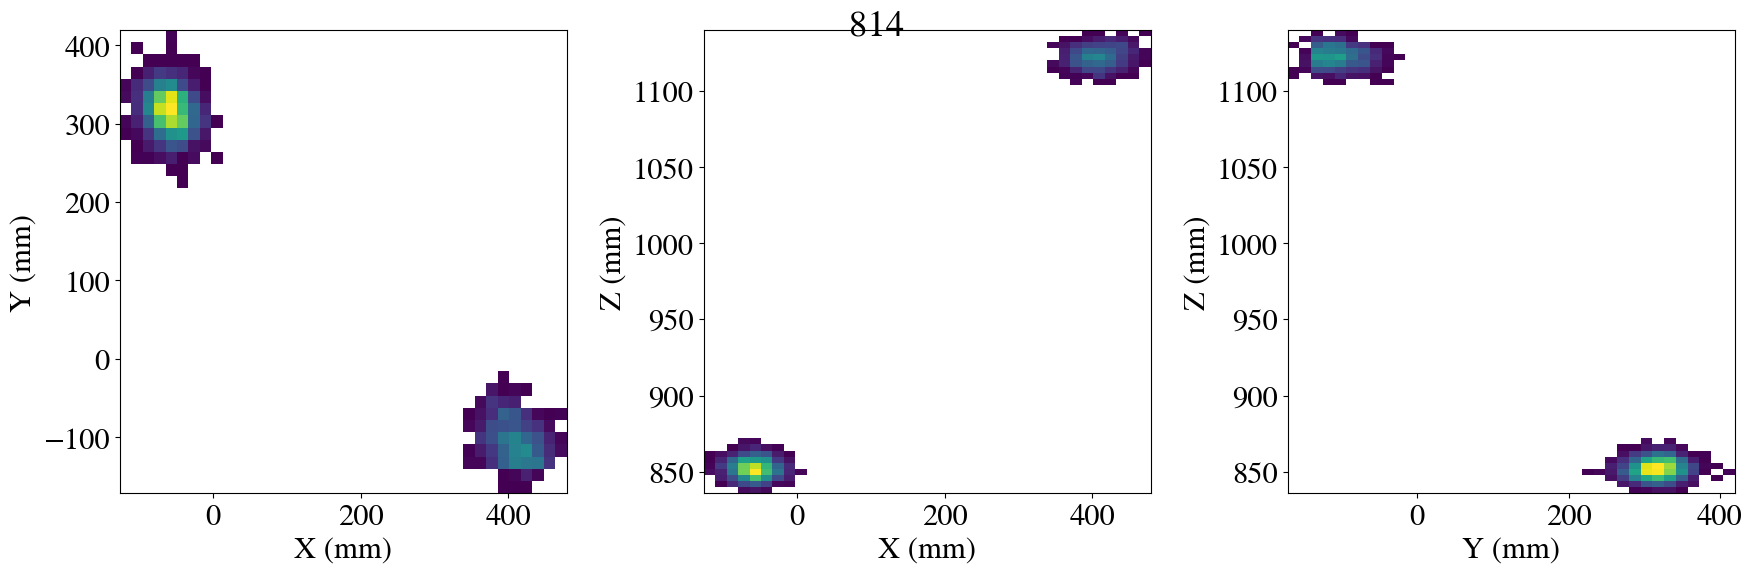

In [105]:
stopper = 10
for i, evt in enumerate(cut_hdst.event.unique()):
    print('=\n'*5)
    raw_plotter(cut_hdst[cut_hdst.event == evt], evt)
    drop_sensors_3D_kdtree = drop_isolated_faster(drop_dist, ['E', 'Ec'], 1, verbose = True)
    drop_hdst_kdtree = drop_sensors_3D_kdtree(cut_hdst[cut_hdst.event == evt])
    drop_sensors_3D_kdtree = drop_isolated_faster(drop_dist, ['E', 'Ec'], 50)
    drop_hdst_kdtree = drop_sensors_3D_kdtree(cut_hdst[cut_hdst.event == evt])
    raw_plotter(drop_hdst_kdtree, evt)
    if i > stopper:
        break

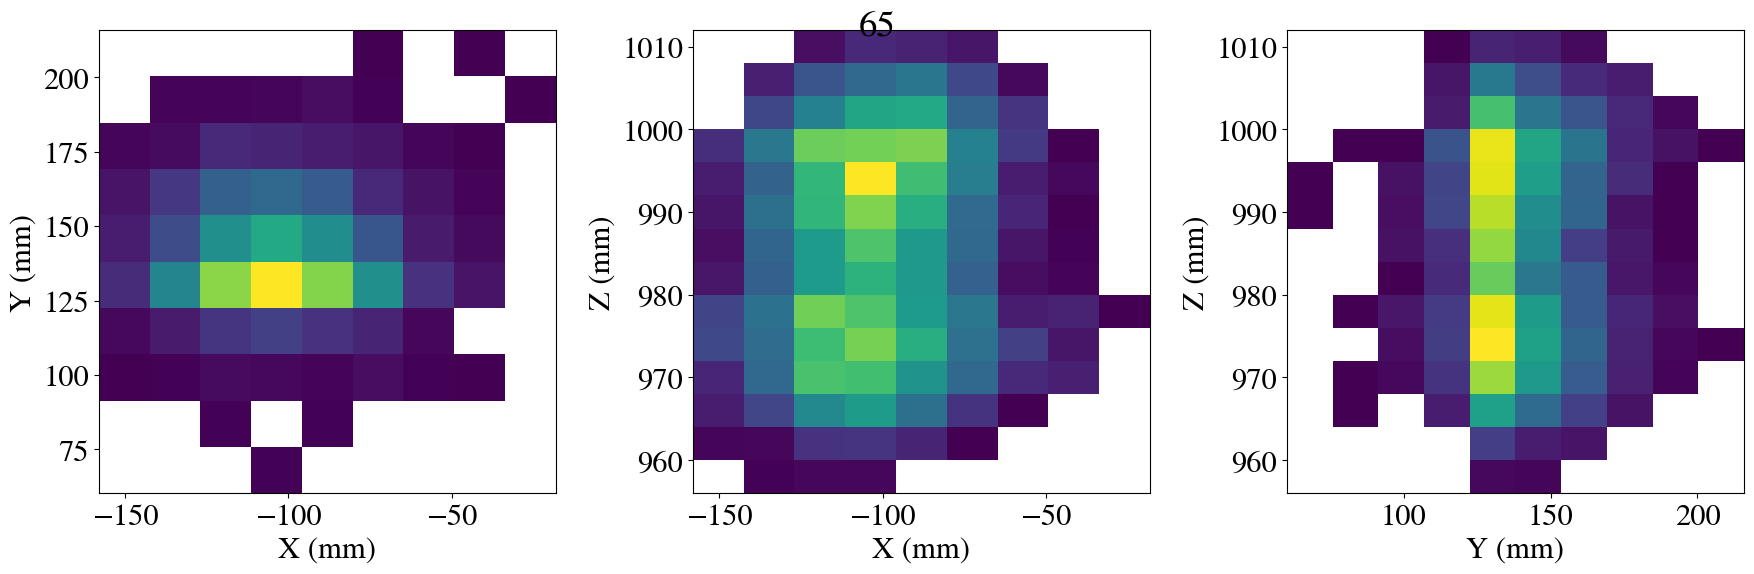

In [90]:
raw_plotter(drop_hdst_kdtree[drop_hdst_kdtree.event == drop_hdst_kdtree.event.unique()[evt]], drop_hdst_kdtree.event.unique()[evt])

In [85]:
hst = [235, 404, 120, 1567, 102938, 9, 14, 11, 351, 15, 12, 2968, 17, 16, 10, 14, 34, 16, 9, 14, 10, 193, 44, 129, 9, 1521, 80, 185, 57, 85, 10, 19, 395, 750, 122, 92, 13, 46, 12, 13, 9, 375, 552, 20, 16, 14, 15, 9, 128, 11, 11, 10, 193, 14, 117, 129, 23, 14, 115, 12, 132, 11, 9, 161, 262, 187, 11, 52, 10, 213, 9, 38, 9, 11, 649, 17, 11, 296, 9, 14, 155, 114, 173, 182, 15, 10, 224, 193, 36, 58, 9, 33, 9, 19, 11, 11, 425, 13, 41, 60, 65, 83, 72, 11, 9, 9, 17, 361, 12, 106, 22, 35, 52, 404, 11, 16, 85, 9, 659, 20, 23, 10, 11, 23, 15, 46, 12, 11, 21, 11, 9, 12, 32, 9, 10, 10, 558, 300, 9, 11, 11, 19, 12, 19, 12, 20, 12, 10, 13, 18, 10, 9, 15, 10, 12, 16, 128, 10, 10, 13, 23, 9, 9, 10, 12, 151, 13, 10, 11, 9, 9, 9, 16, 9, 158, 86, 344, 202, 9, 11, 19, 9, 11, 11, 10, 21, 16, 18, 28, 35, 9, 201, 9, 13, 12, 204, 199, 10, 182, 13, 9, 31, 10, 9, 13, 9, 10, 11, 9, 24, 194, 10, 104, 25, 123, 12, 231, 21, 11, 11, 11, 11, 10, 9, 12, 32, 13, 9, 205, 162, 11, 9, 9, 14, 9, 13, 9, 145, 27, 9, 9, 82, 22, 10, 115, 12, 315, 11, 23, 46, 21, 12, 9, 11, 13, 10, 9, 9, 9, 35, 9, 89, 9, 190, 11, 94, 9, 155, 13, 108, 118, 106, 9, 10, 12, 10, 10, 32, 81, 10, 202, 53, 29, 12, 10, 14, 11, 9, 11, 17, 30, 9, 12, 10, 160, 9, 10, 12, 13, 33, 20, 12, 94, 181, 27, 55, 9, 10, 11, 65, 131, 9, 9, 11, 9, 17, 13, 10, 11, 59, 13, 9, 10, 10, 10, 85, 12, 26, 12, 9, 10, 10, 13, 13, 16, 10, 38, 10, 10, 12, 9, 10, 166, 47, 142, 10, 106, 13, 11, 20, 26, 69, 9, 10, 12, 77, 27, 9, 148, 9, 10, 9, 9, 37, 10, 78, 9, 228, 9, 11, 212, 9, 28, 10, 9, 10, 10, 64, 123, 9, 83, 25, 45, 20, 10, 18, 106, 17, 18, 25, 129, 29]
plt.hist(hst, range = [0, 1500], bins = 100)
plt.show()

plt.hist(hst, bins = 1000)
plt.yscale('log')
plt.show()

In [125]:

q_cut           = 5, #5 for 6mm  - 5 for 6mm
drop_dist       = [16, 16, 4.]
drop_dist_2d    = [16, 16]
nhits           = 3
nhits_low       = 1
nhits_high      = 10

# Couple of functions used in beersheba.

cut_sensors       = beerfun.cut_over_Q   (q_cut, ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(drop_dist, ['E', 'Ec'], nhits)
drop_sensors_2D   = beerfun.drop_isolated(drop_dist_2d, ['E', 'Ec'])
drop_sensors_miryam = drop_isolated_clusters(drop_dist, ['E', 'Ec'], 3)
drop_sensors_3D_kdtree = drop_isolated_faster(drop_dist, ['E', 'Ec'], 3)

In [122]:
import time

cut_hdst = cut_sensors(soph_hdst)


drop_hdst_2d = drop_sensors_2D(cut_hdst)
drop_hdst = drop_sensors(cut_hdst)


/home/e78368jw/anaconda3/envs/IC-3.8-2024-06-08/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [128]:
import time

cut_hdst = cut_sensors(soph_hdst)


execution_times_2d = []
for _ in range(5):
    start_time = time.time()
    drop_hdst_2d = drop_sensors_2D(cut_hdst)
    execution_times_2d.append(time.time() - start_time)

# Calculate the average execution time
average_time = sum(execution_times_2d) / len(execution_times_2d)
print(f"Average execution time over 5 runs for 2D sensors: {average_time:.4f} seconds")

execution_times = []
for _ in range(5):
    start_time = time.time()
    drop_hdst = drop_sensors(cut_hdst)
    execution_times.append(time.time() - start_time)

# Calculate the average execution time
average_time = sum(execution_times) / len(execution_times)
print(f"Average execution time over 5 runs for 3D clusters: {average_time:.4f} seconds")


/home/e78368jw/anaconda3/envs/IC-3.8-2024-06-08/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(*inputs, **kwargs)


Average execution time over 5 runs for 2D sensors: 15.0822 seconds
Average execution time over 5 runs for 3D clusters: 20.3432 seconds


In [136]:
print(cut_hdst.event.nunique())

143


In [135]:

iterations = 20

execution_times = []
for _ in range(iterations):
    start_time = time.time()
    drop_hdst_miryam = cut_hdst.groupby('event').apply(drop_sensors_miryam).reset_index(drop=True).copy(deep=True)
    execution_times.append(time.time() - start_time)

# Calculate the average execution time
average_time = sum(execution_times) / len(execution_times)
print(f"Average execution time over {iterations} runs for miryam clustering method 3D: {average_time:.4f} seconds")



execution_times = []
for _ in range(5):
    start_time = time.time()
    drop_hdst_kdtree = cut_hdst.groupby('event').apply(drop_sensors_3D_kdtree).reset_index(drop=True).copy(deep=True)
    execution_times.append(time.time() - start_time)

# Calculate the average execution time
average_time = sum(execution_times) / len(execution_times)
print(f"Average execution time over 5 runs for kdtree clustering method: {average_time:.4f} seconds")



Average execution time over 20 runs for miryam clustering method 3D: 2.3287 seconds
Average execution time over 5 runs for kdtree clustering method: 6.5662 seconds


In [131]:
# and miryams 2d function

def drop_isolated_clusters_2D(distance = [16., 16.],
                              variables= [],
                              nhit = 3):
    dist = np.sqrt(distance[0] ** 2 + distance[1] ** 2)

    def drop(df: pd.DataFrame) -> pd.DataFrame:
        if len(df) == 0:
            return df

        xy = df[['X', 'Y']].values

        try:
            nbrs = NearestNeighbors(radius=dist, algorithm='ball_tree').fit(xy)
            neighbors = nbrs.radius_neighbors(xy, return_distance=False)
            mask = np.array([len(neigh) > nhit for neigh in neighbors])
        except Exception as e:
            print(f"Error in NearestNeighbors: {{e}}")
            return df.iloc[:0]  # fallback: return empty

        pass_df = df.loc[mask].copy()

        if not pass_df.empty and variables:
            with np.errstate(divide='ignore', invalid='ignore'):
                columns = pass_df.loc[:, variables]
                scale = df[variables].sum().values / columns.sum().values
                columns *= scale
                pass_df.loc[:, variables] = columns

        return pass_df

    return drop

In [134]:
drop_2d_miryam = drop_isolated_clusters_2D(drop_dist, ['E', 'Ec'], 3)

iterations = 20

execution_times = []
for _ in range(iterations):
    start_time = time.time()
    miryam_2d = cut_hdst.groupby('event').apply(drop_2d_miryam).reset_index(drop=True).copy(deep=True)
    execution_times.append(time.time() - start_time)

# Calculate the average execution time
average_time = sum(execution_times) / len(execution_times)
print(f"Average execution time over {iterations} runs for miryam clustering method 2D: {average_time:.4f} seconds")



Average execution time over 20 runs for miryam clustering method 2D: 2.2553 seconds


=
=
=
=
=
=
=
=
=
=

0 3516
RAW


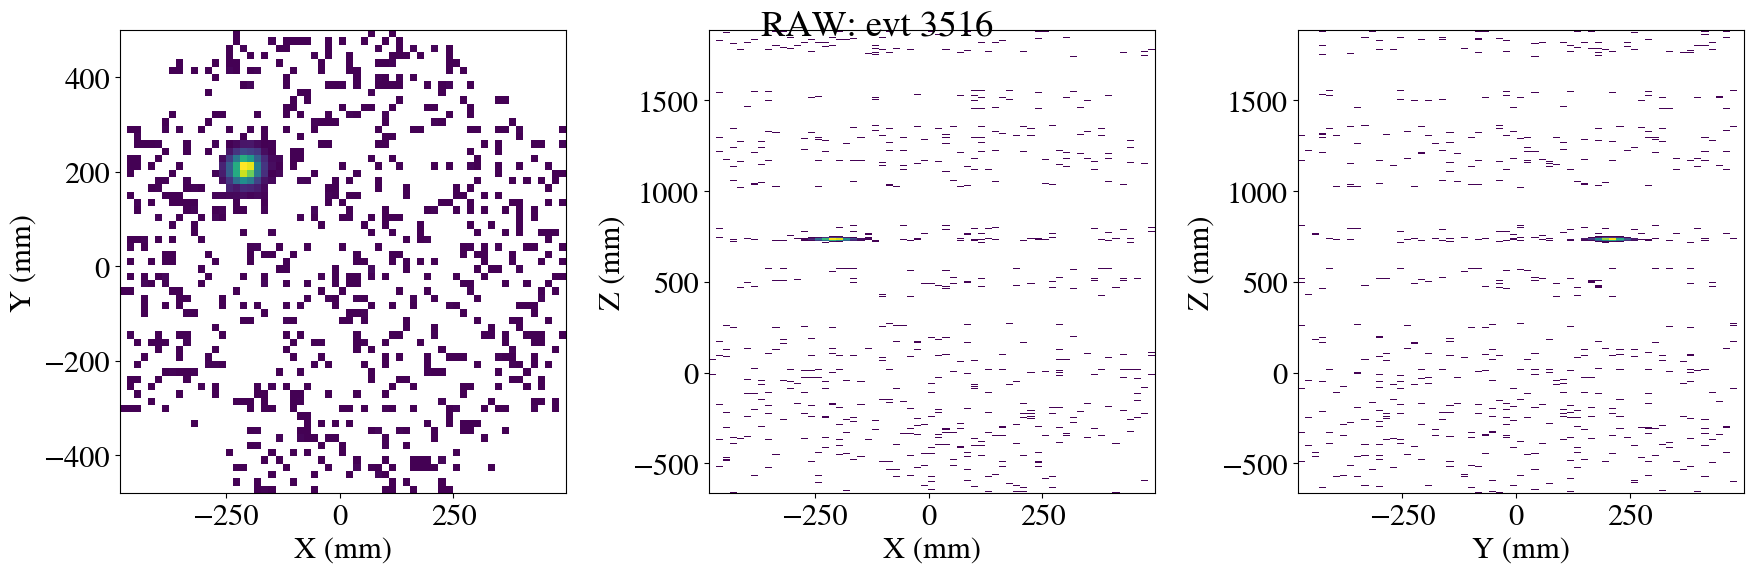

CUT


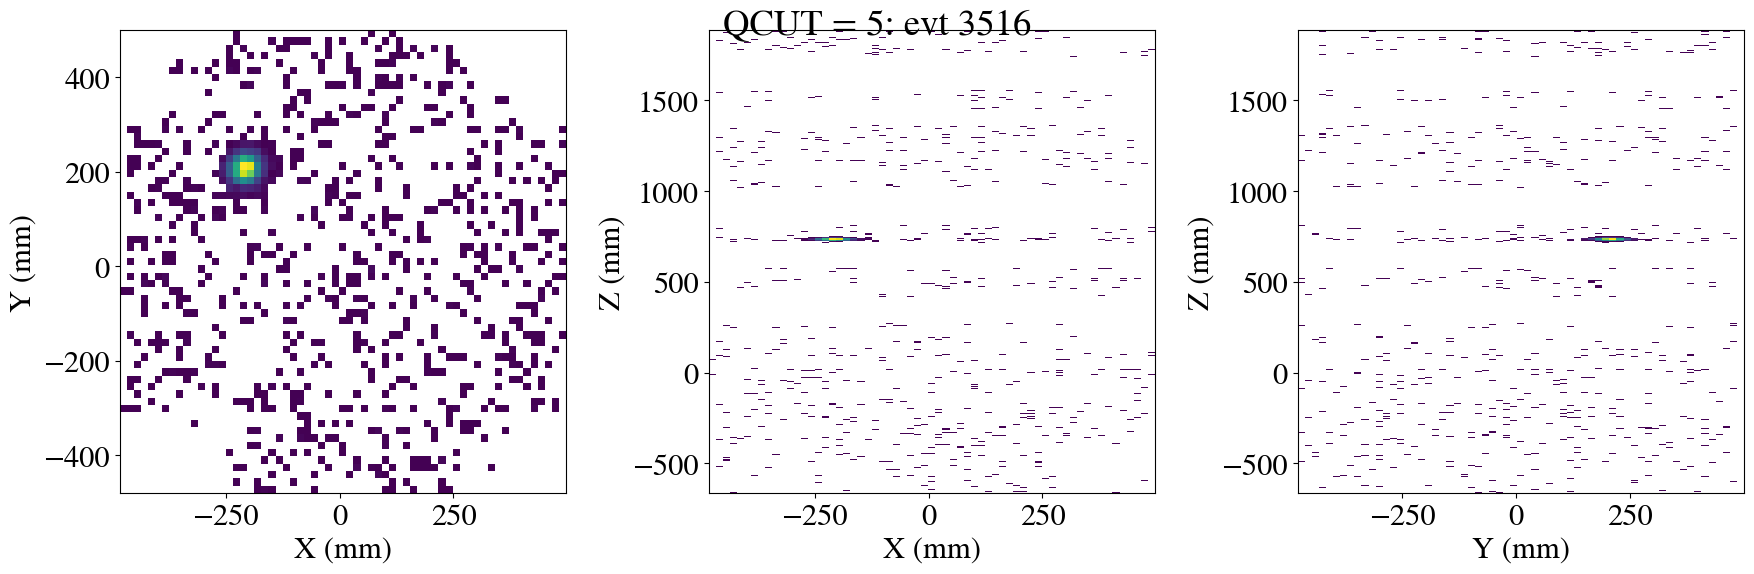

DROP CLUSTER


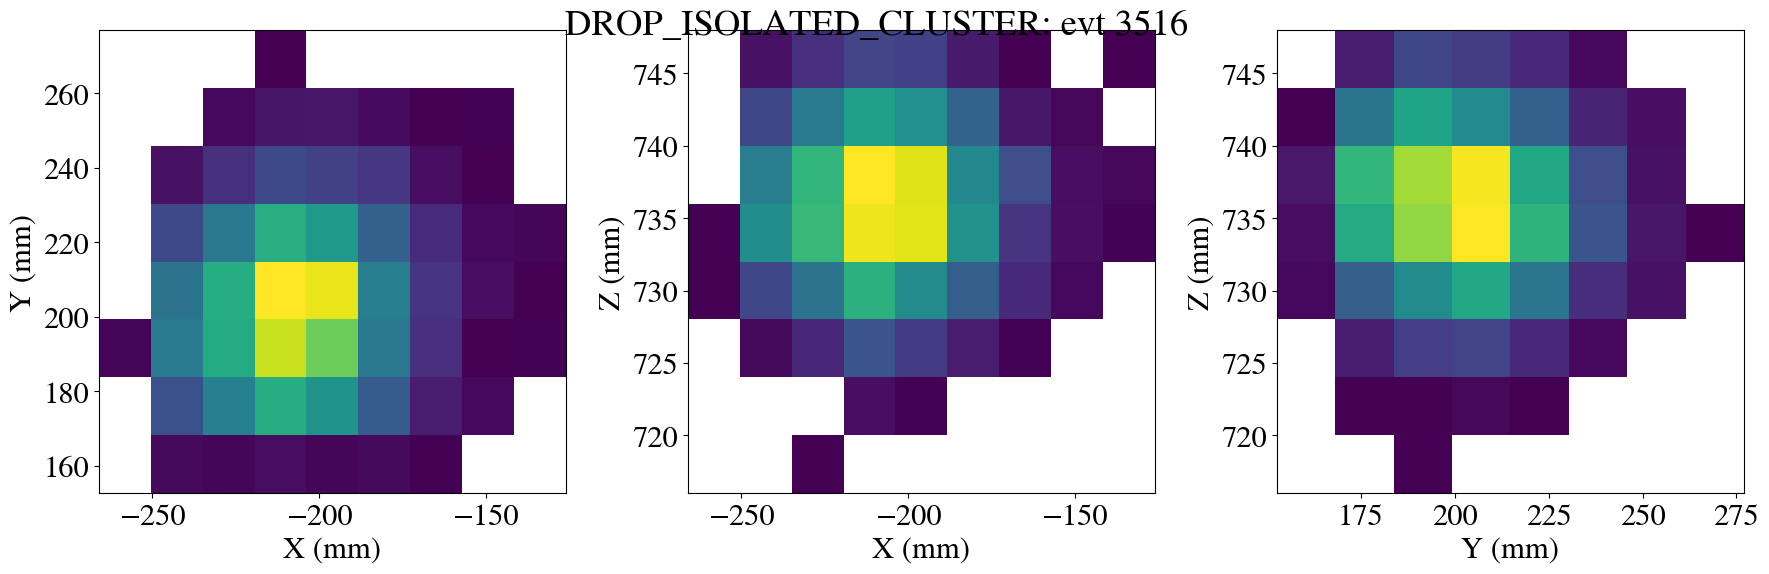

DROP CLUSTER FAST


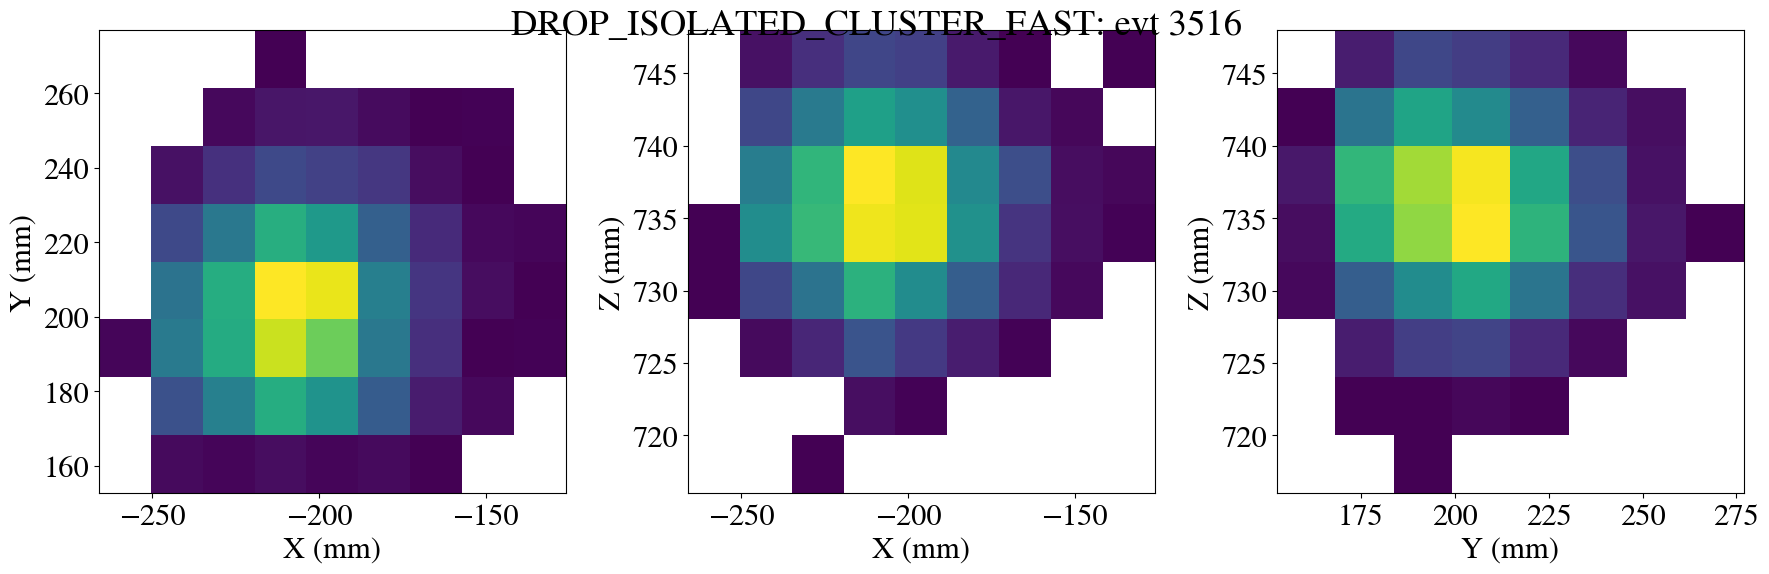

DROP SENSOR


DROP MIRYAM


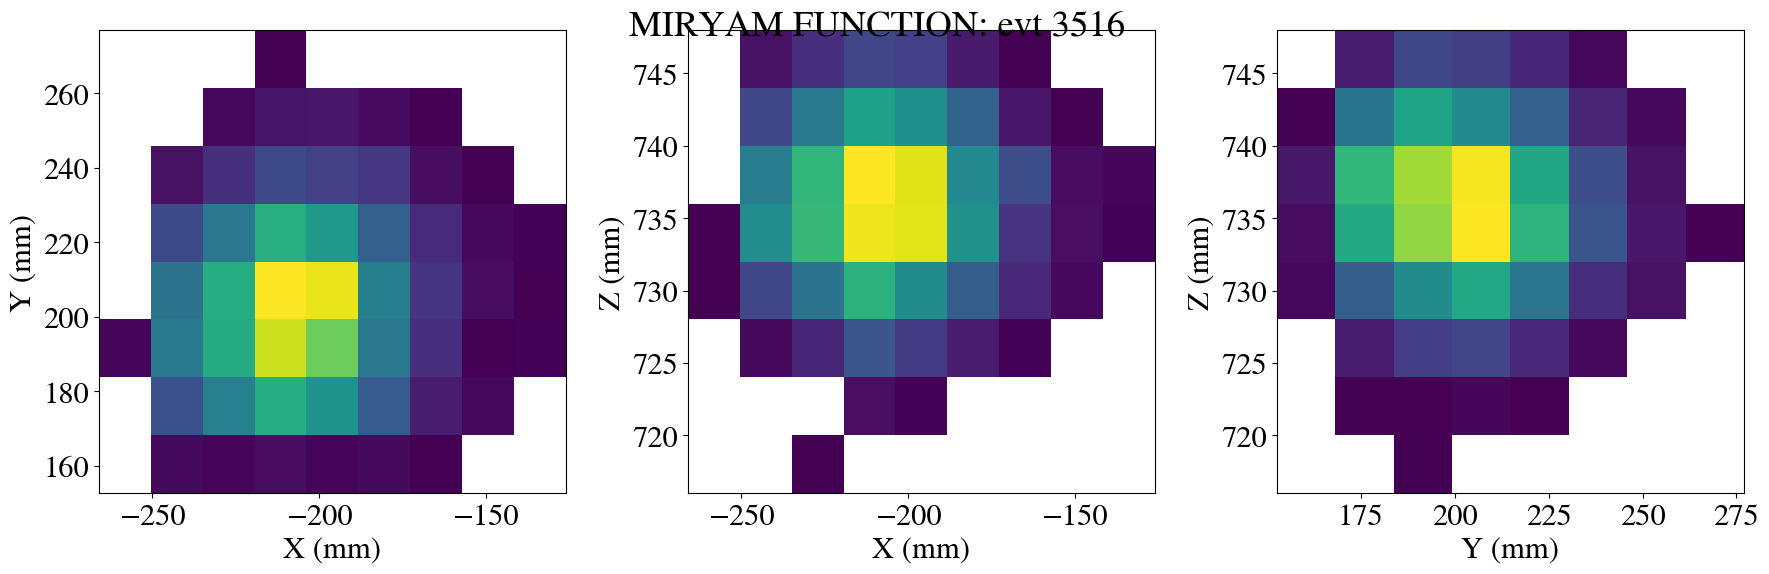

DROP MIRYAM-2D


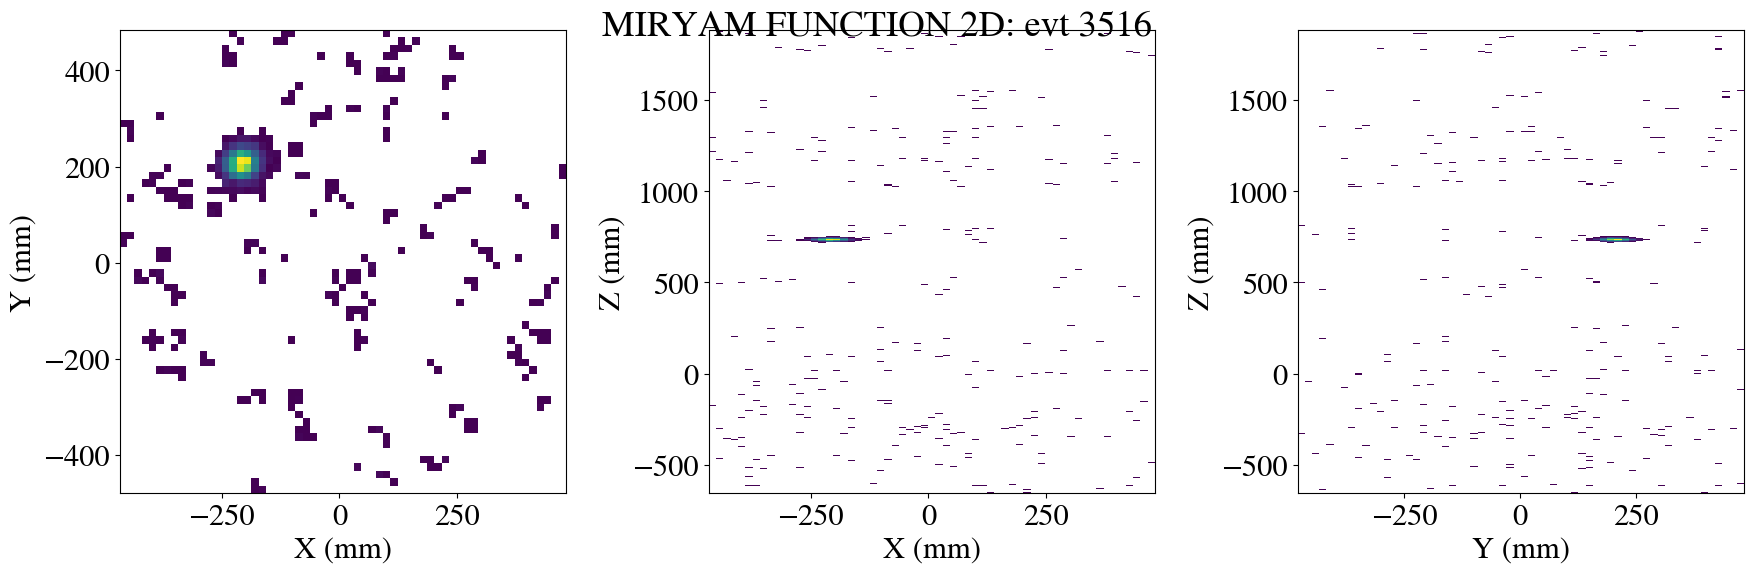

=
=
=
=
=
=
=
=
=
=

1 3544
RAW


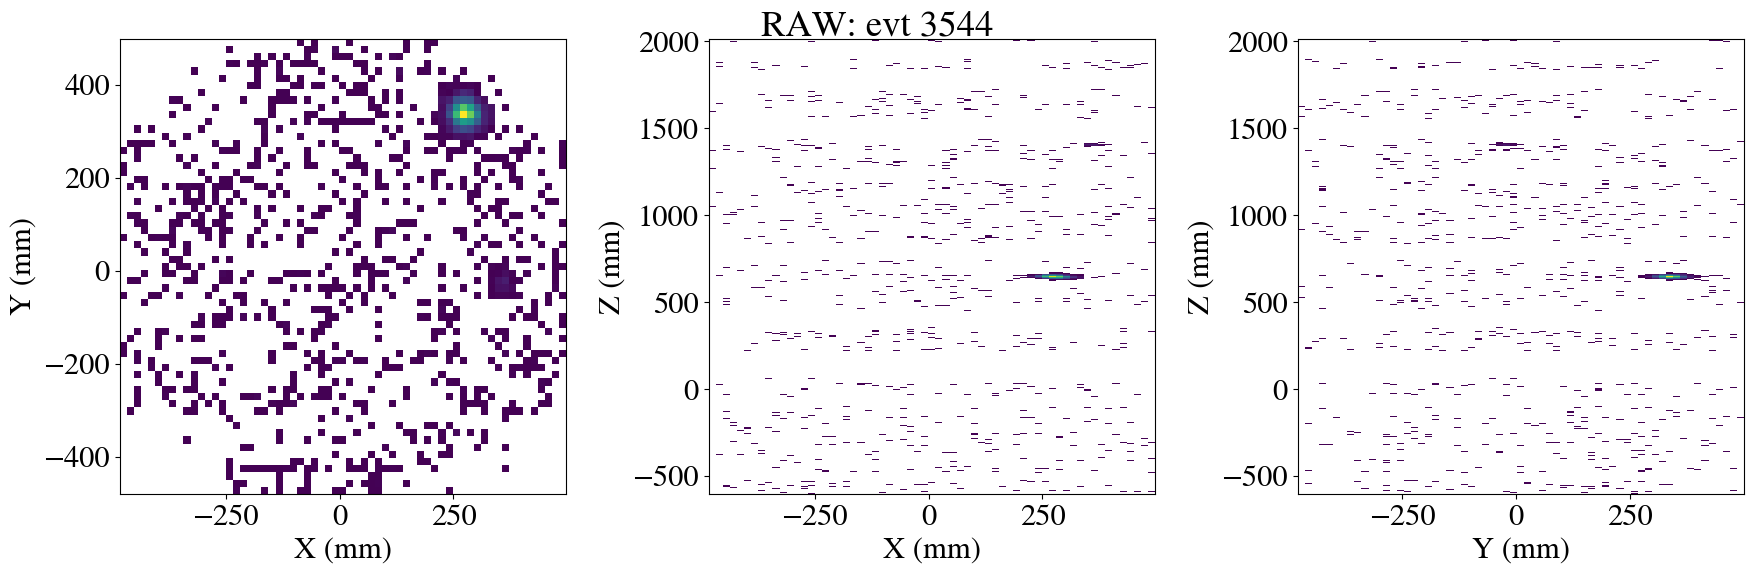

CUT


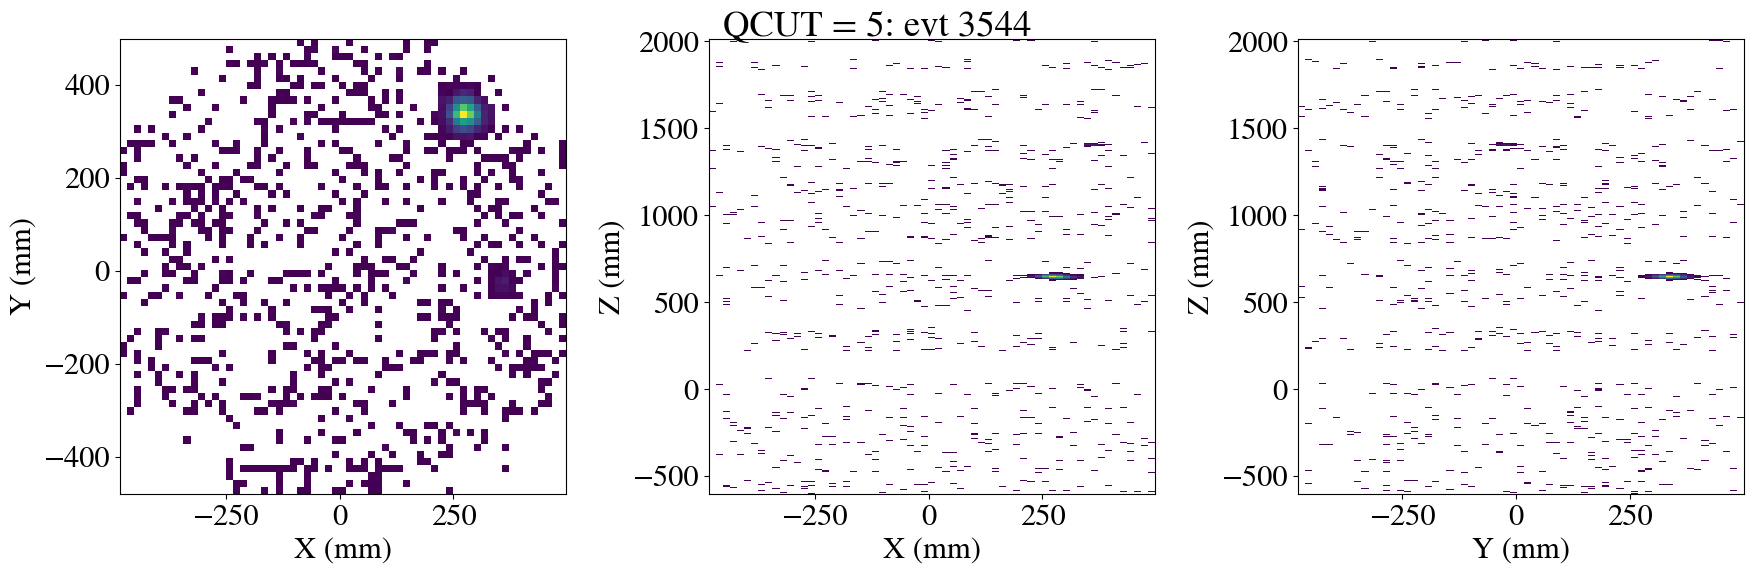

DROP CLUSTER


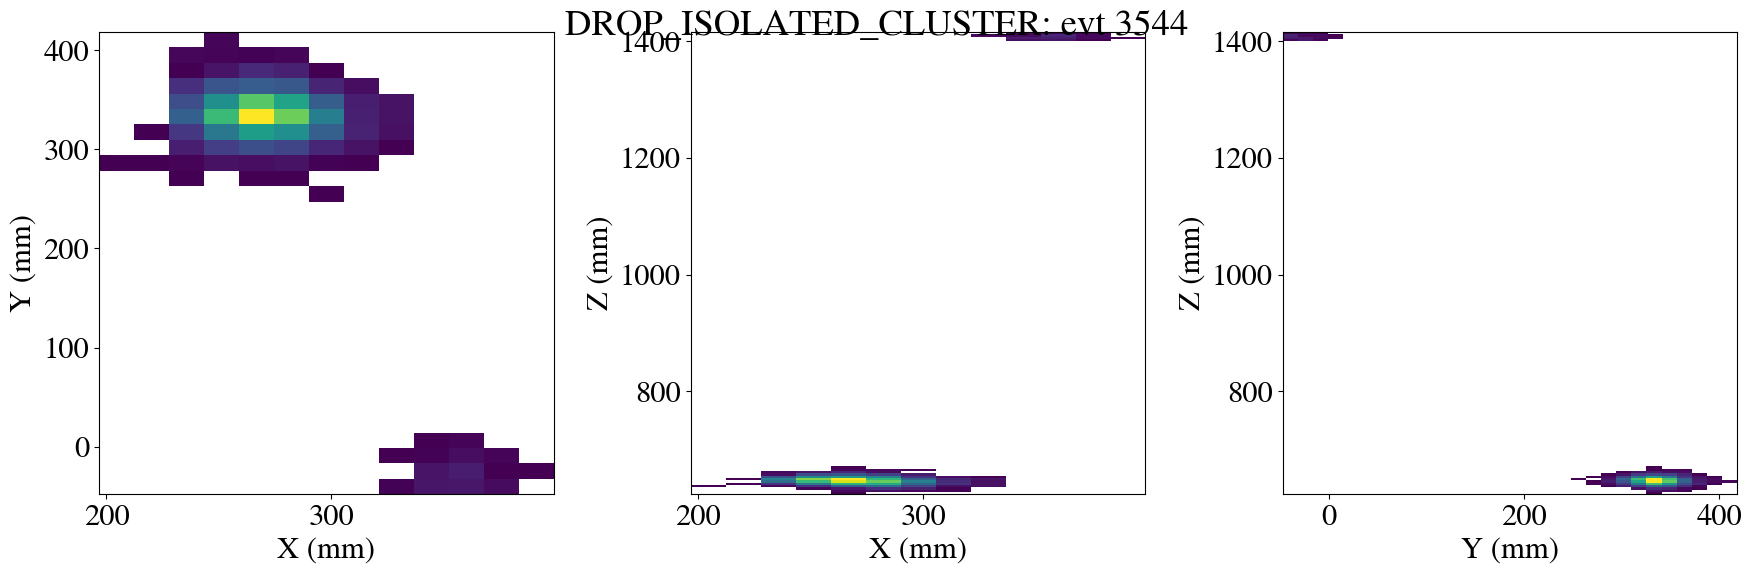

DROP CLUSTER FAST


DROP SENSOR


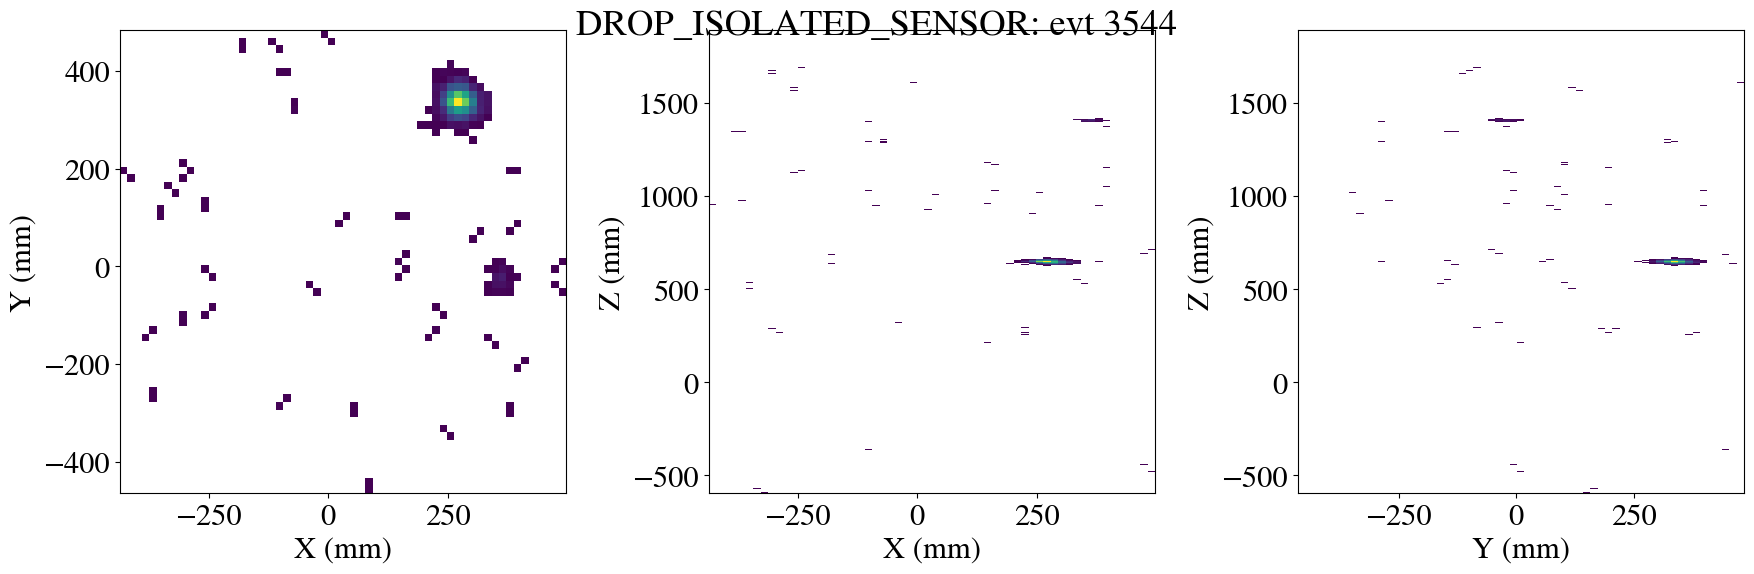

DROP MIRYAM


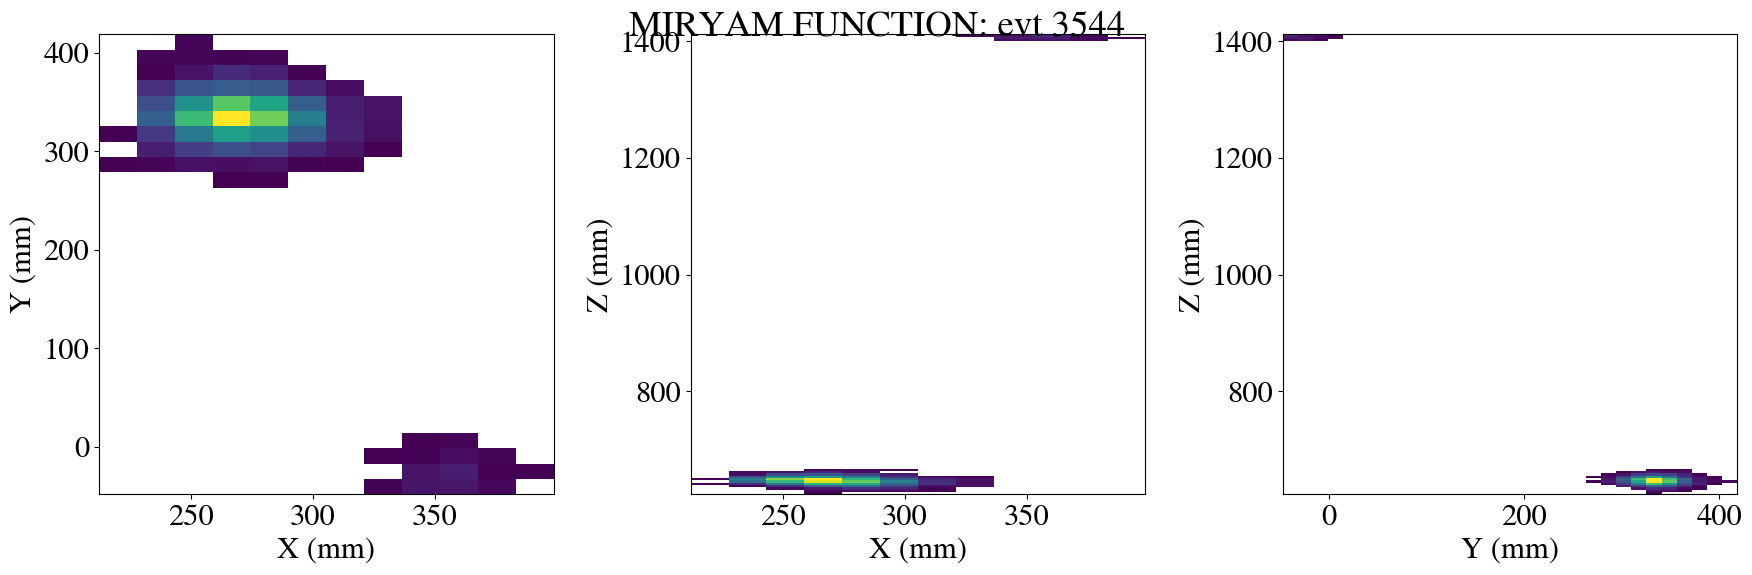

DROP MIRYAM-2D


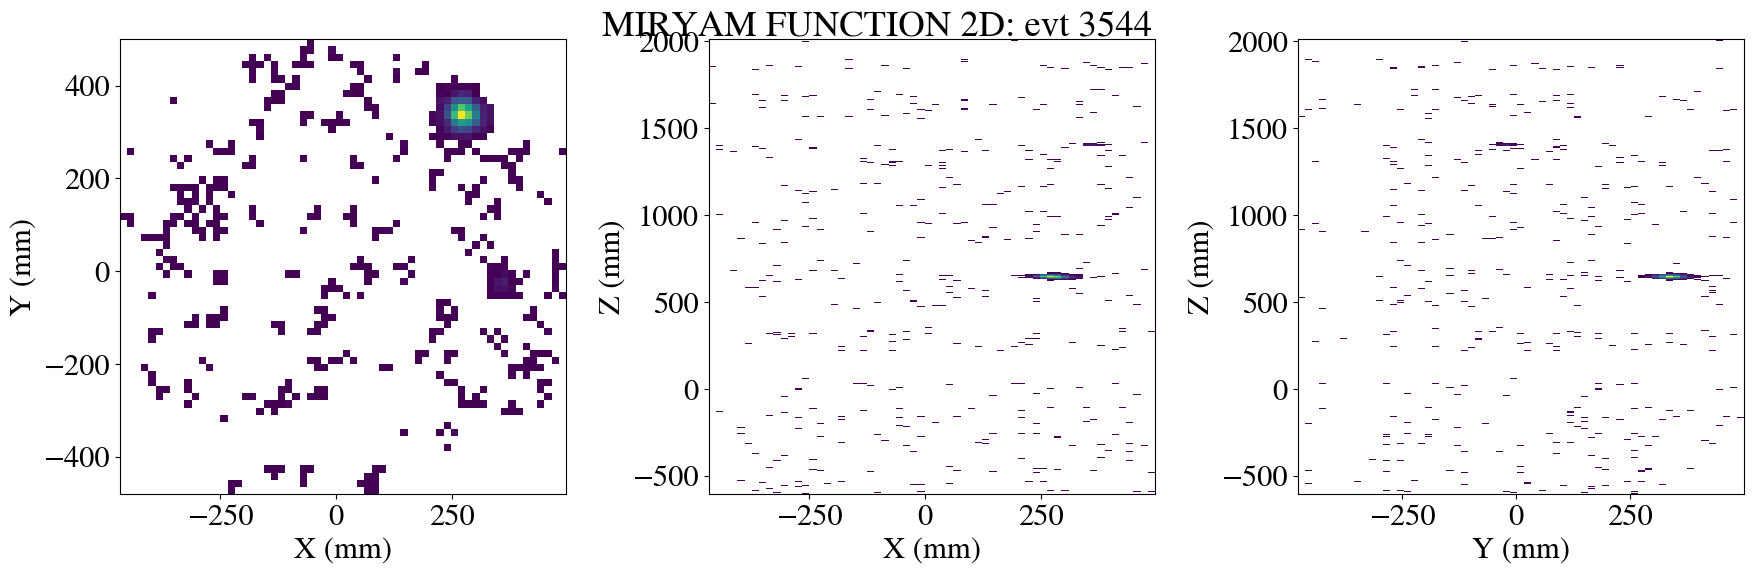

=
=
=
=
=
=
=
=
=
=

2 3572
RAW


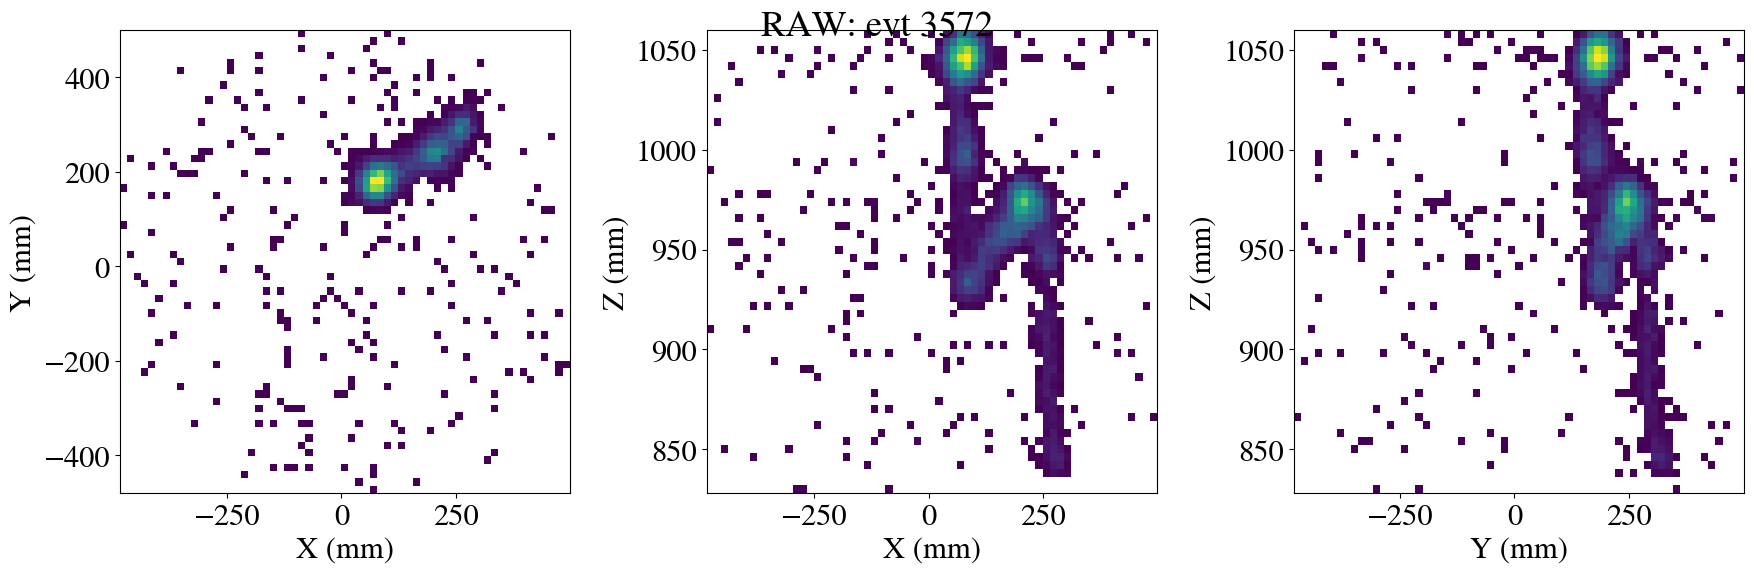

CUT


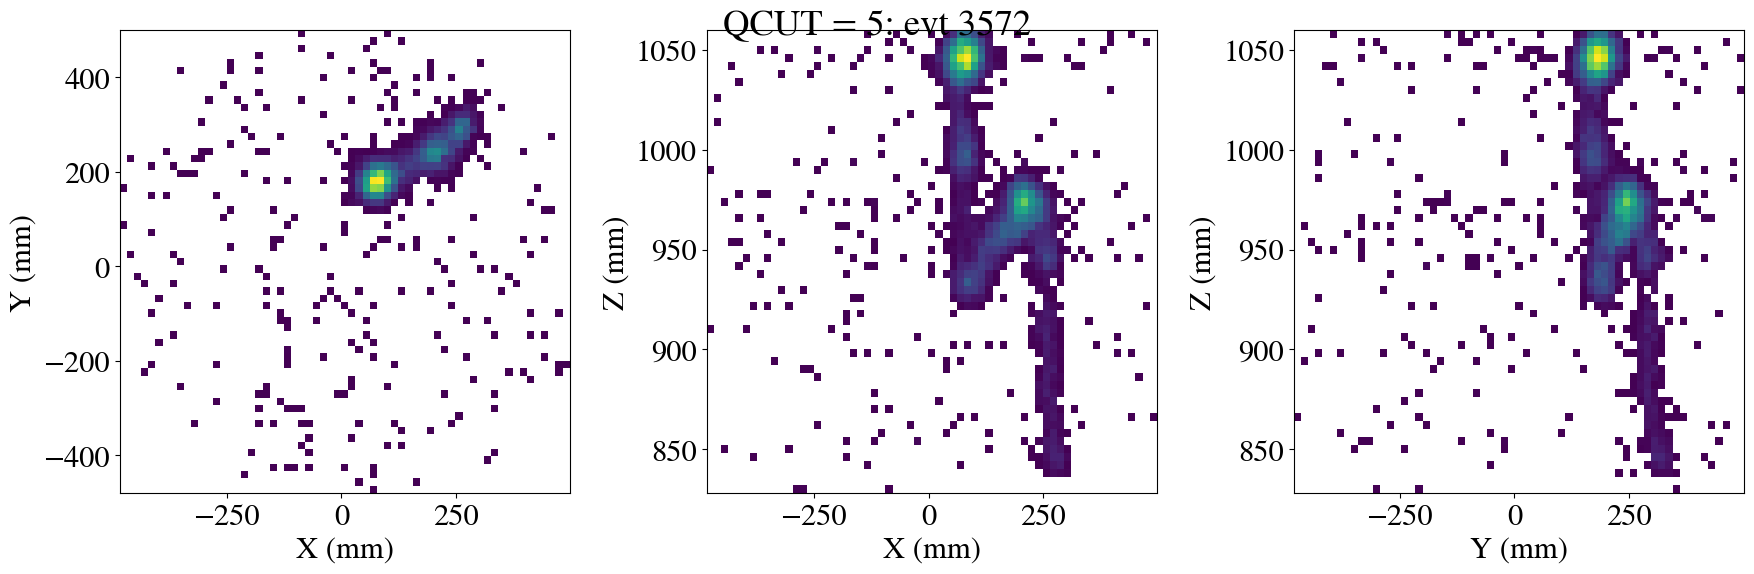

DROP CLUSTER


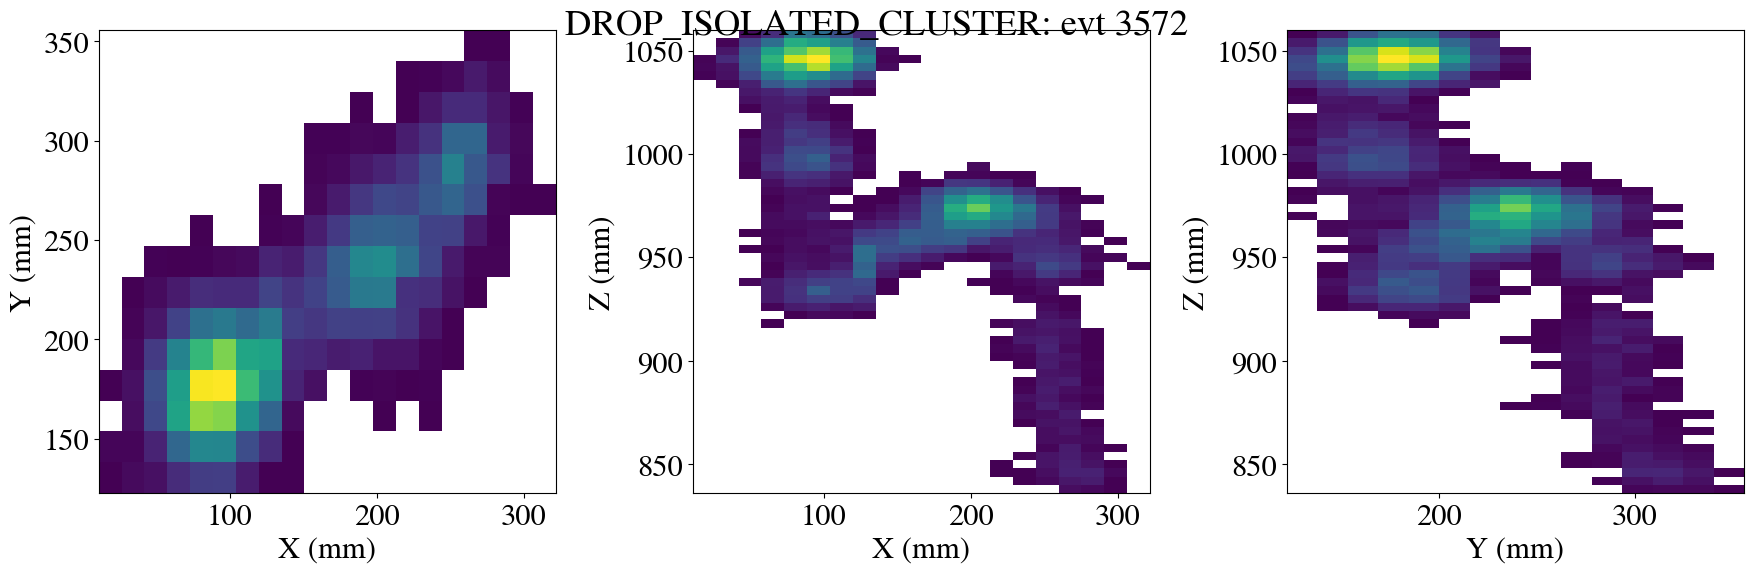

DROP CLUSTER FAST


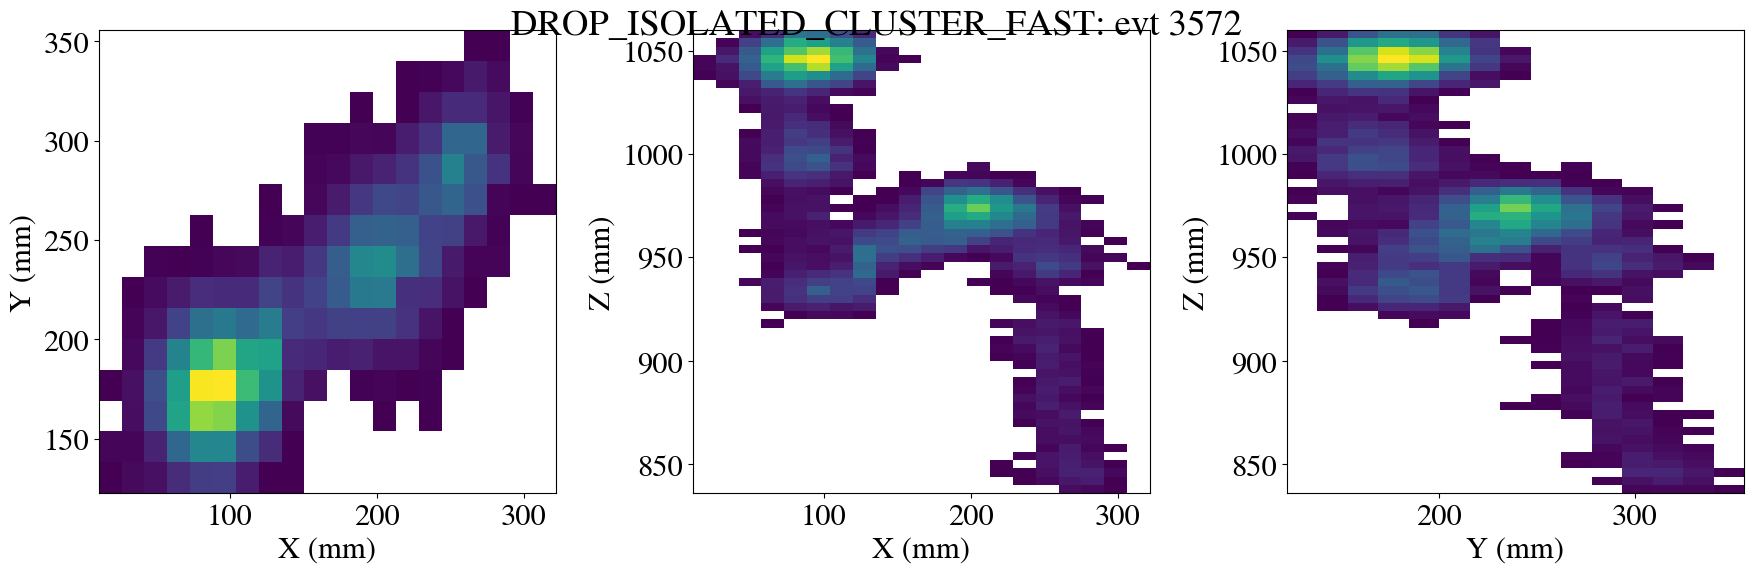

DROP SENSOR


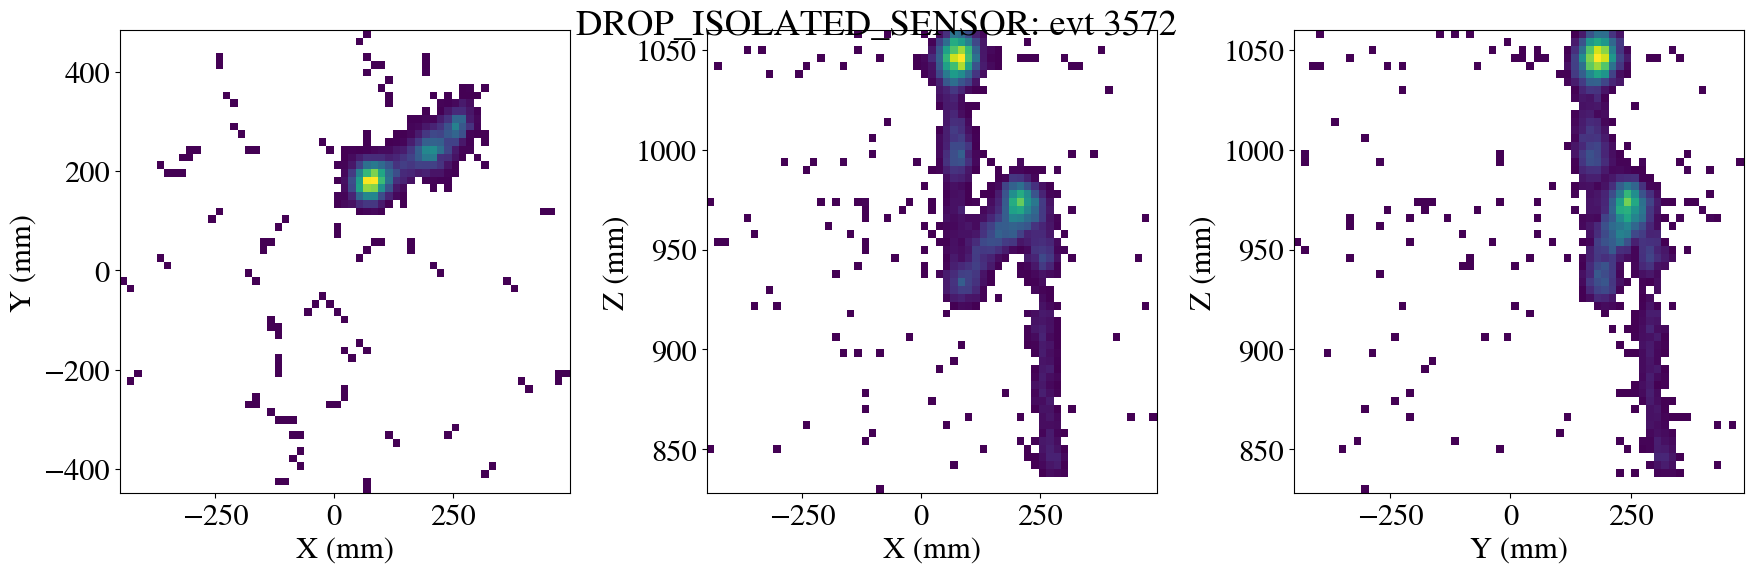

DROP MIRYAM


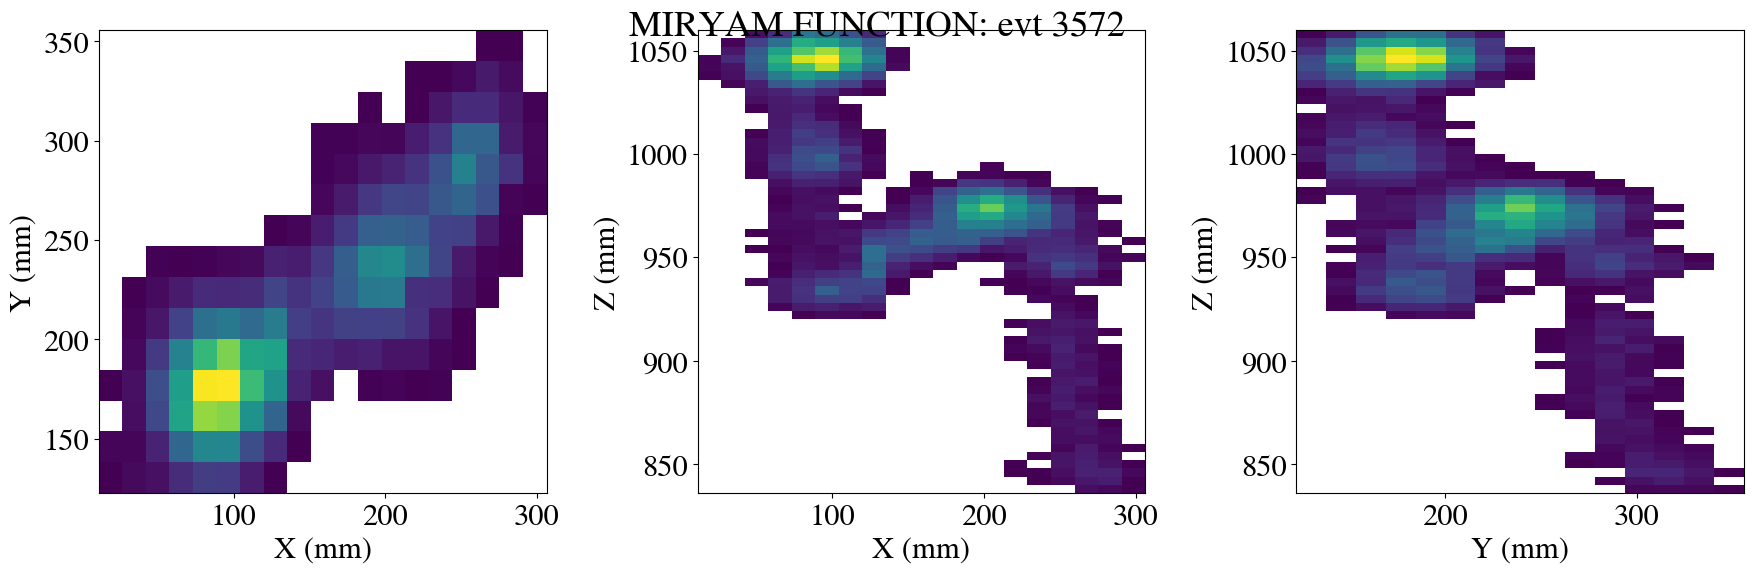

DROP MIRYAM-2D


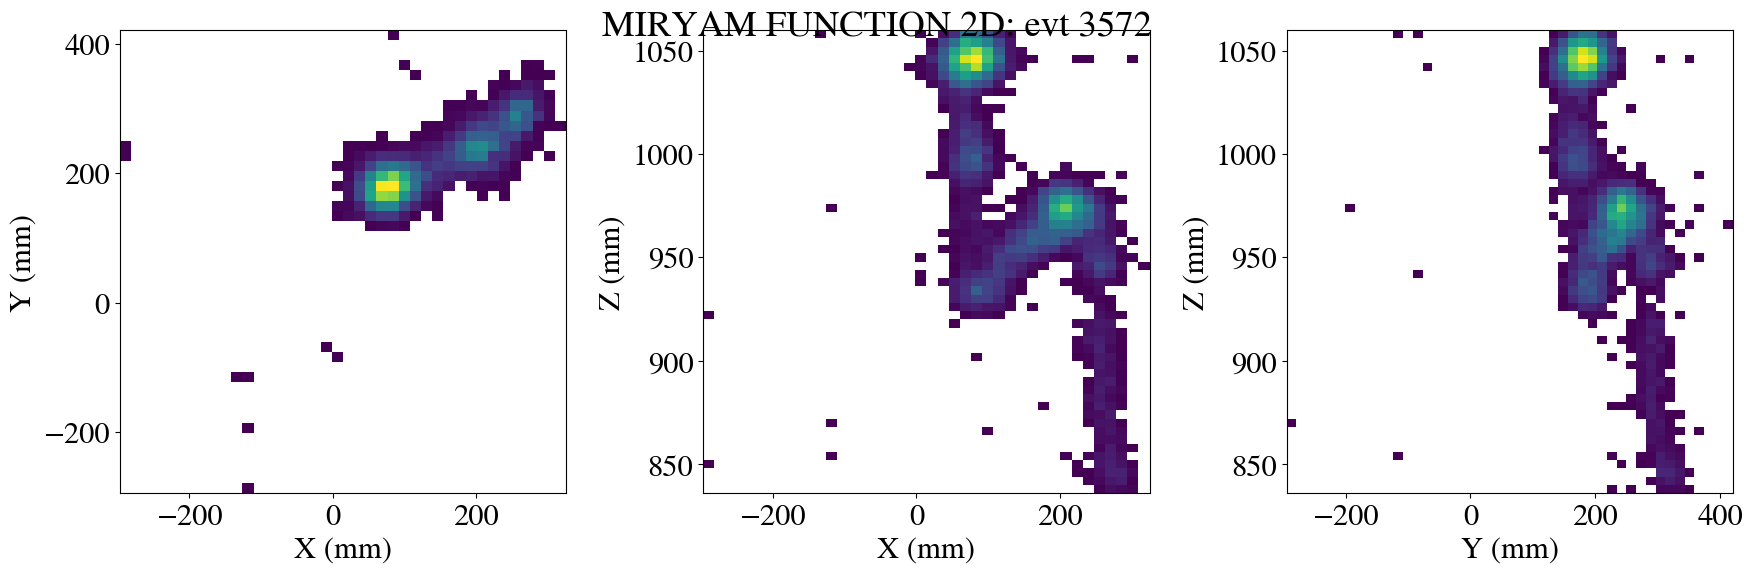

=
=
=
=
=
=
=
=
=
=

3 3621
RAW


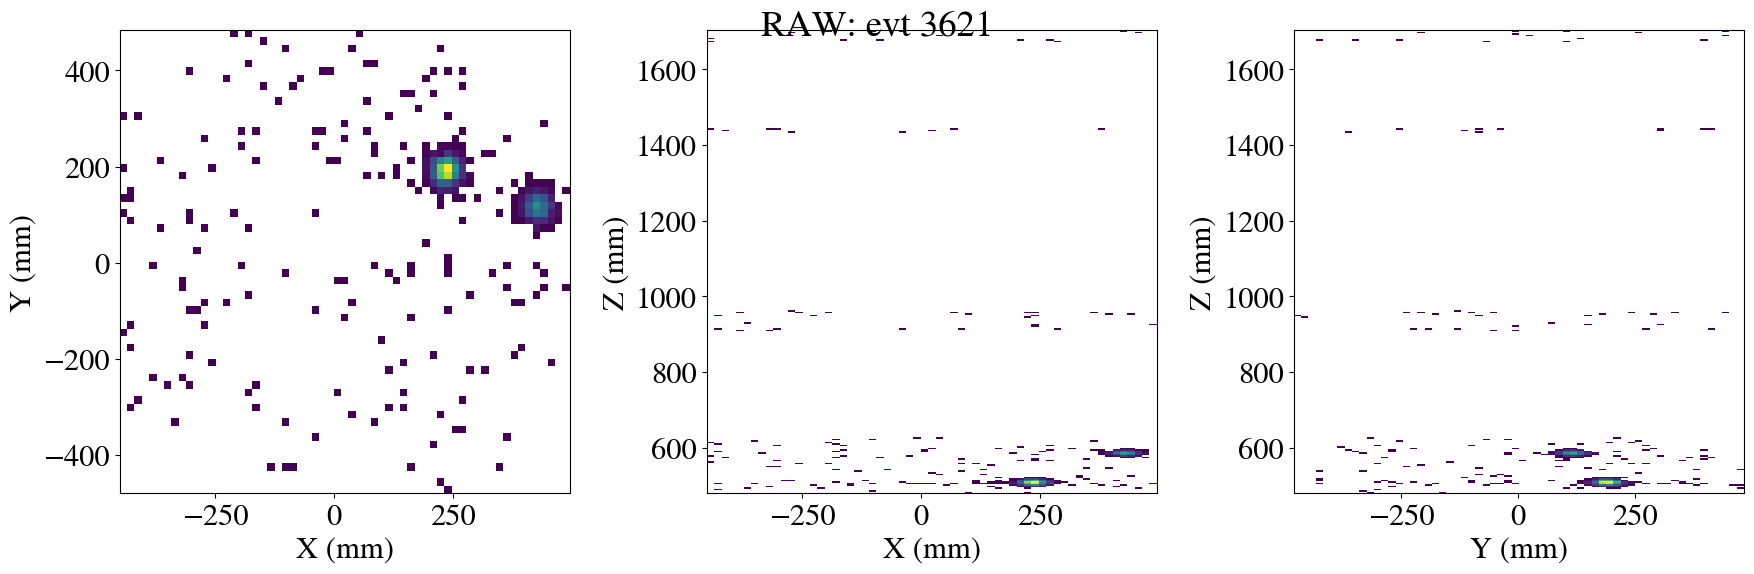

CUT


DROP CLUSTER


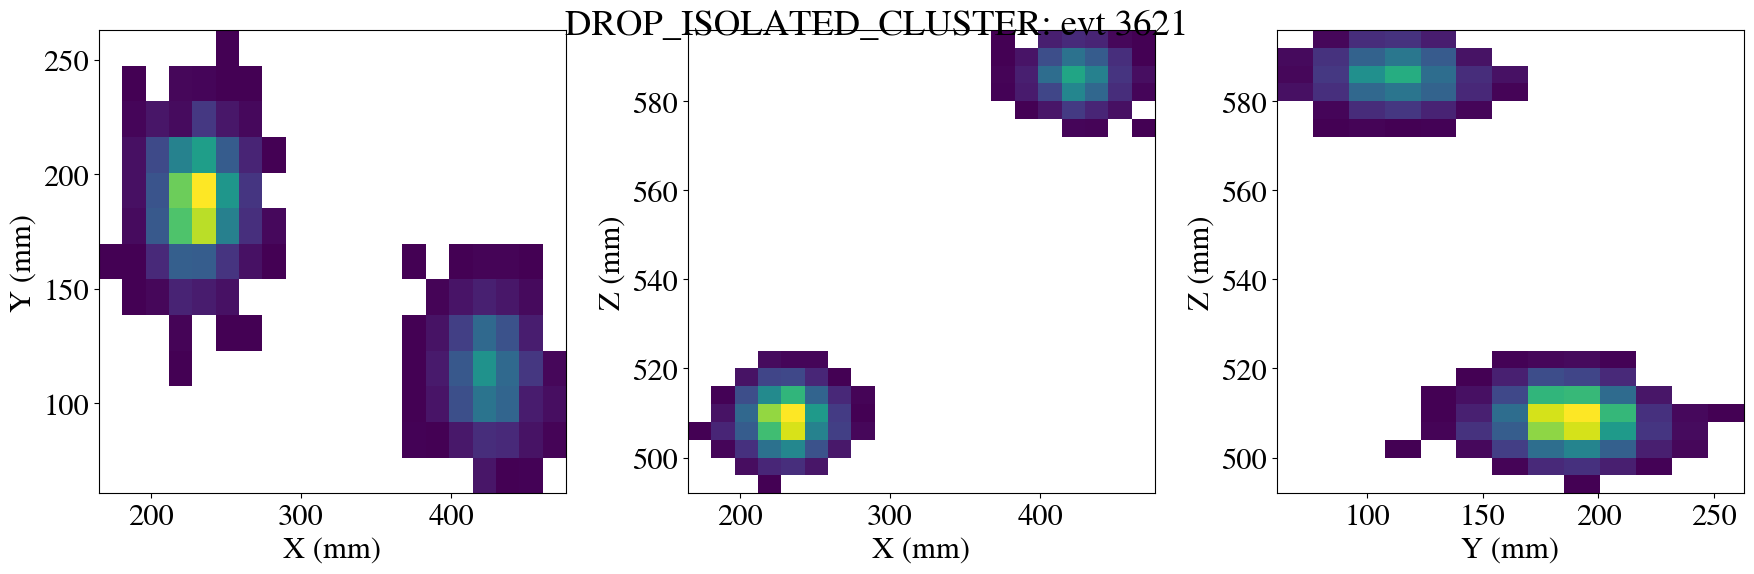

DROP CLUSTER FAST


DROP SENSOR


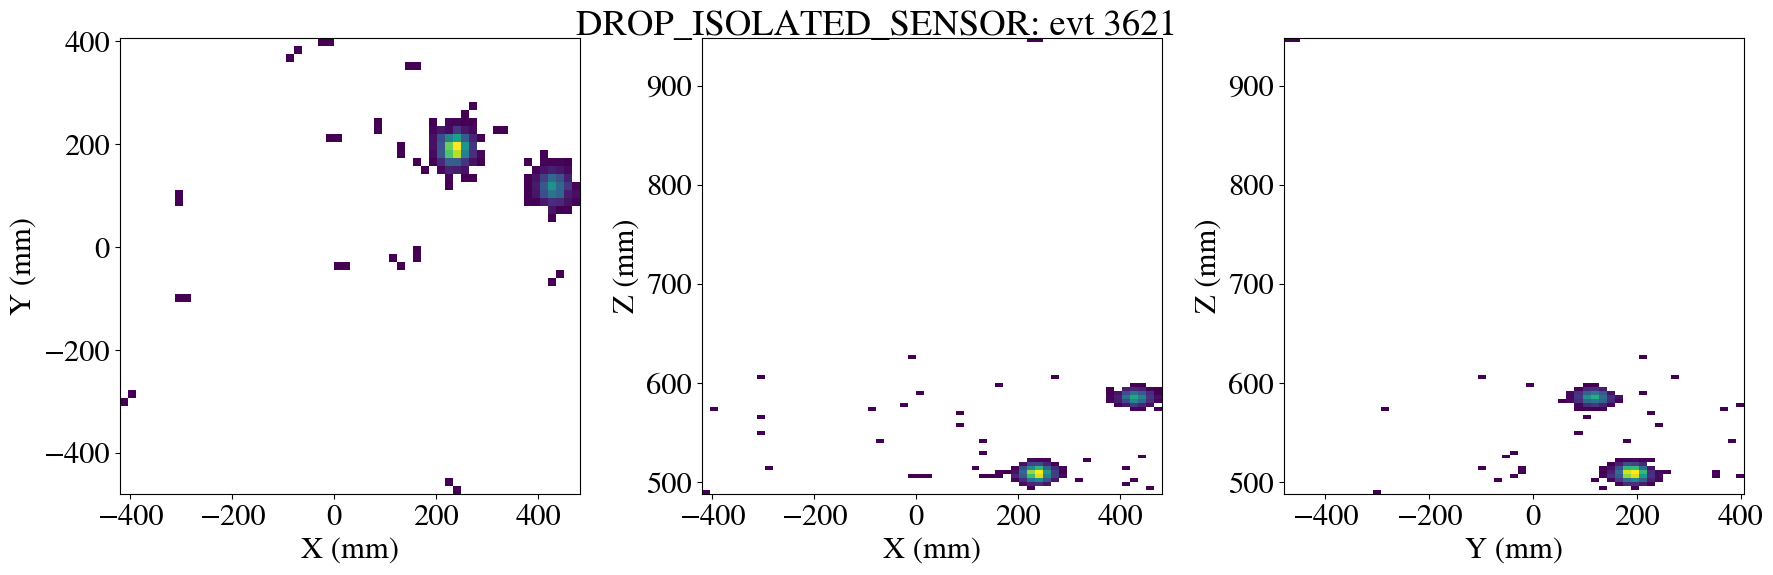

DROP MIRYAM


DROP MIRYAM-2D


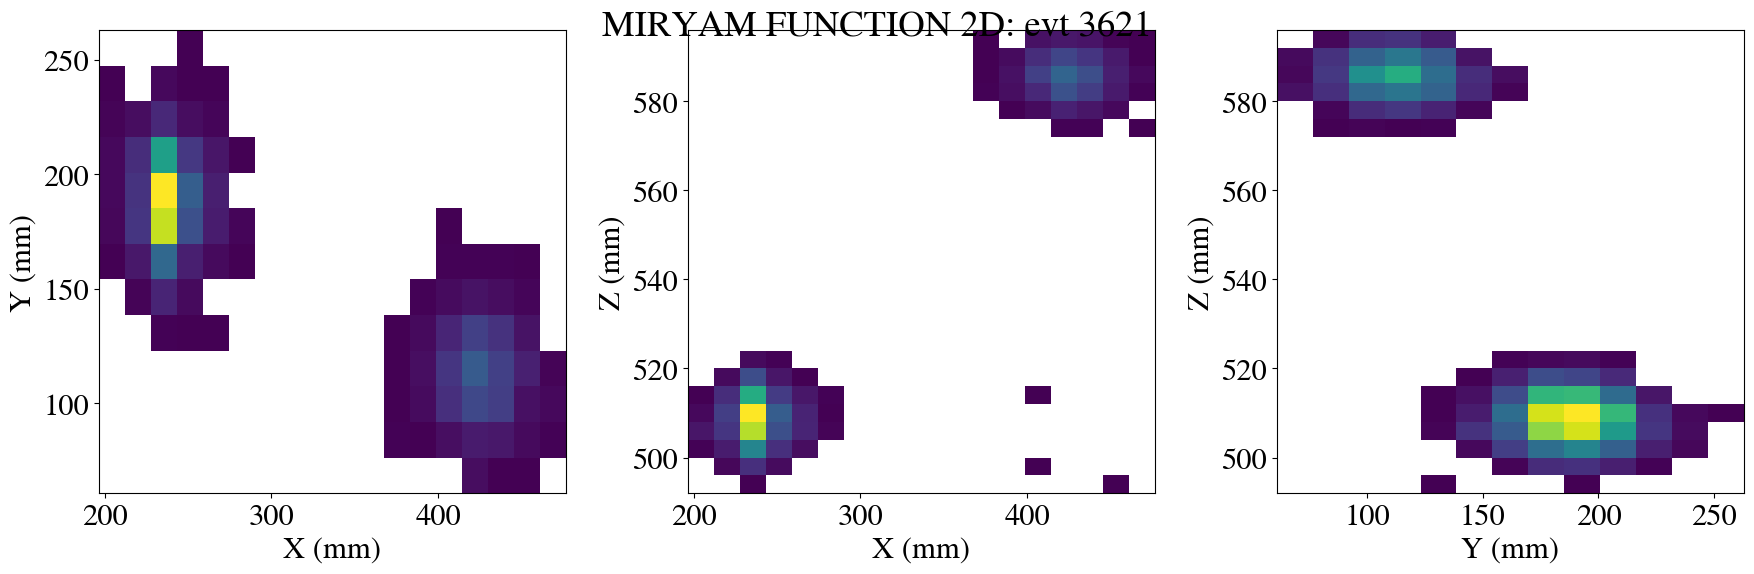

=
=
=
=
=
=
=
=
=
=

4 3663
RAW


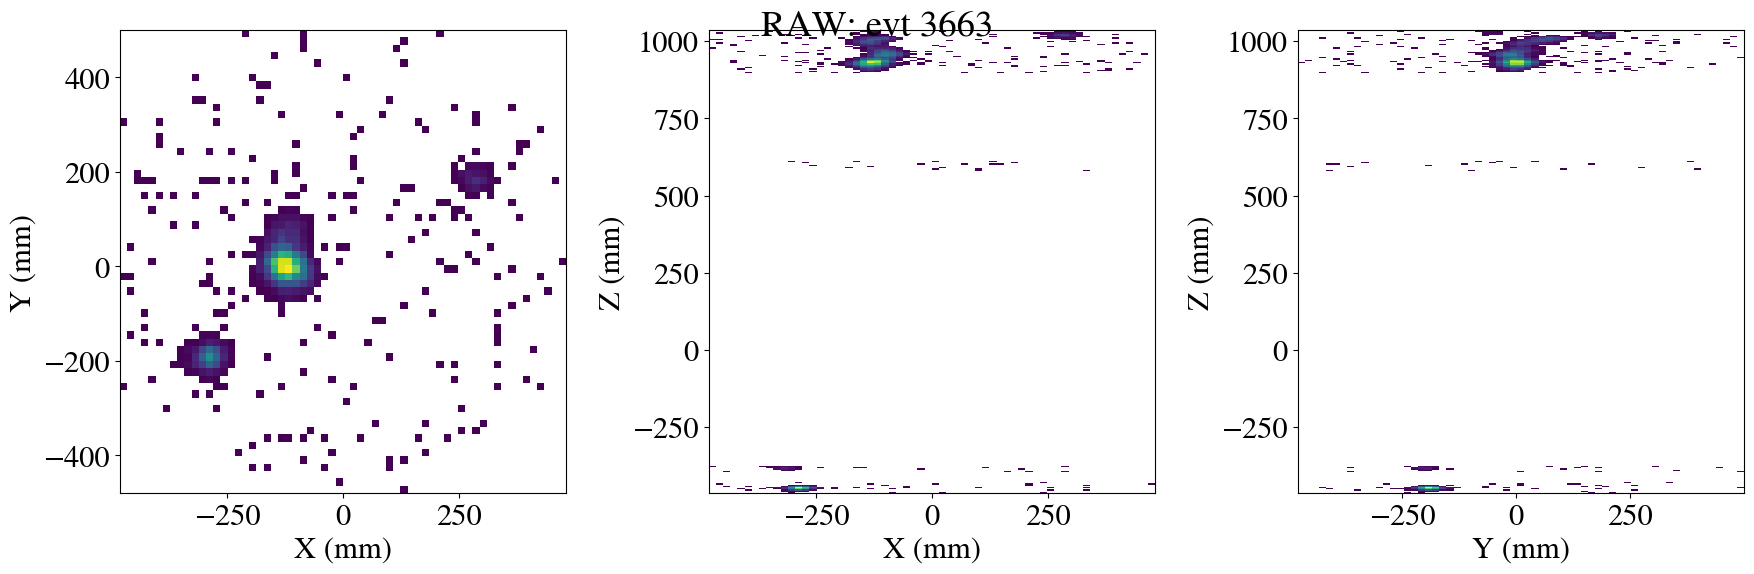

CUT


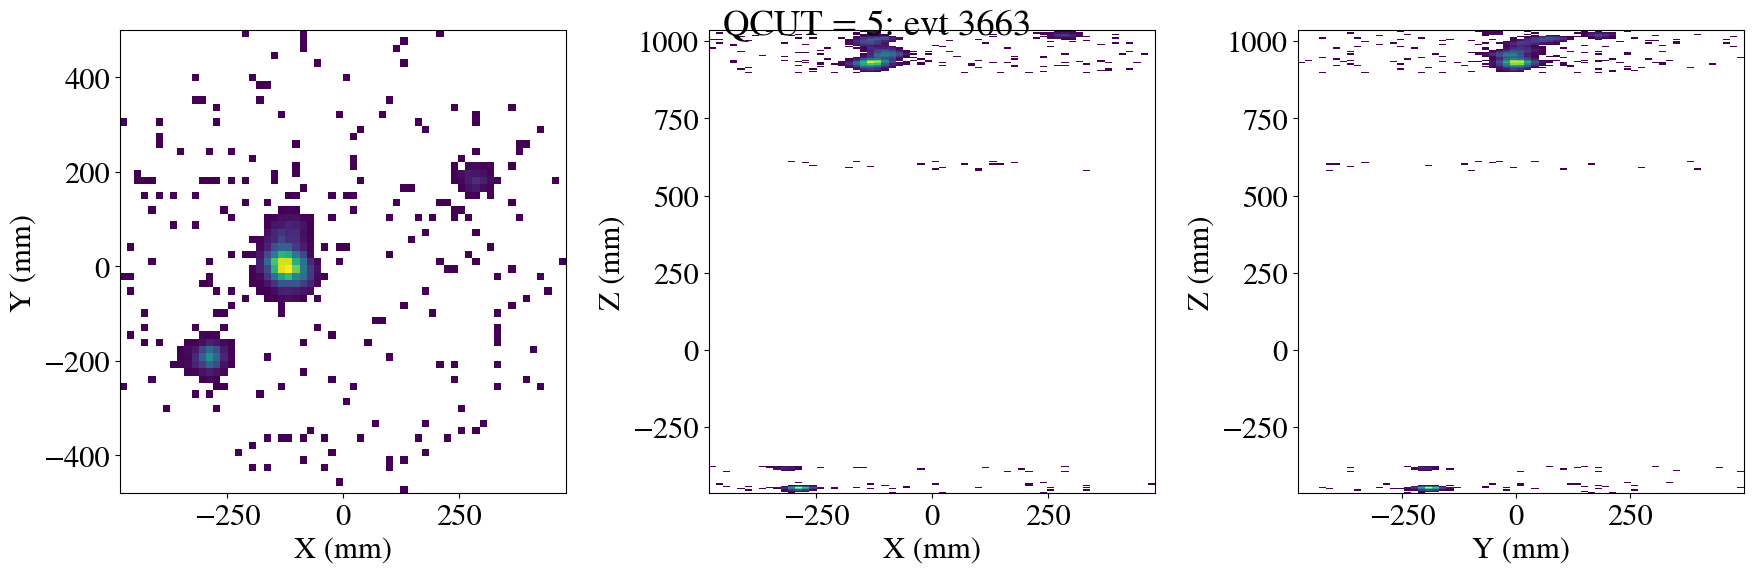

DROP CLUSTER


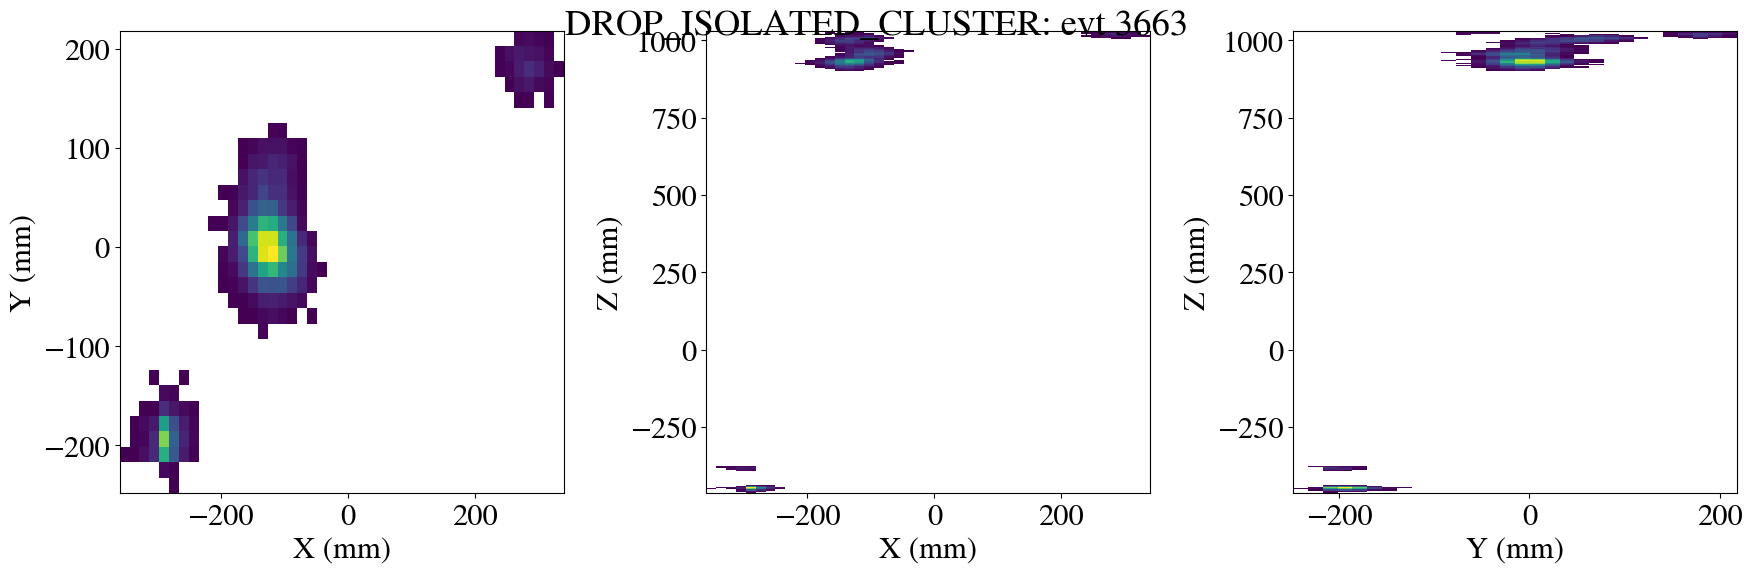

DROP CLUSTER FAST


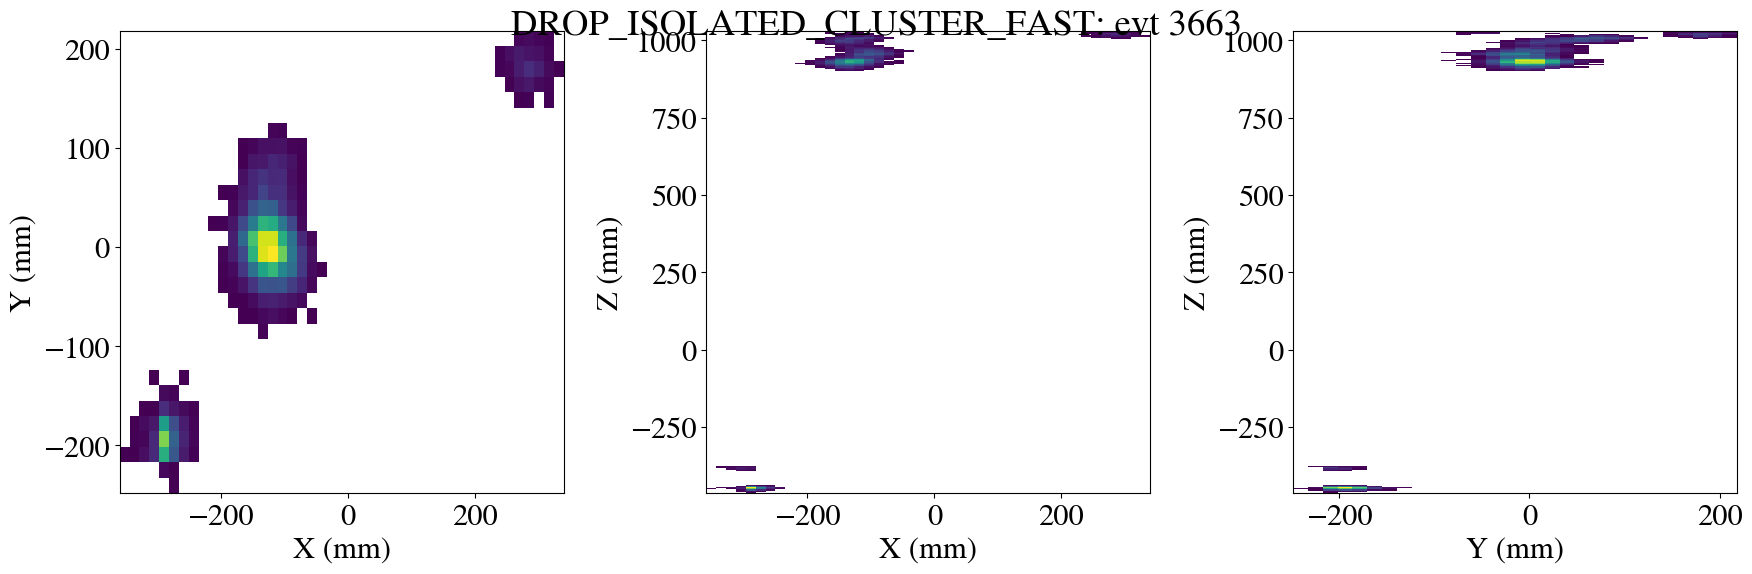

DROP SENSOR


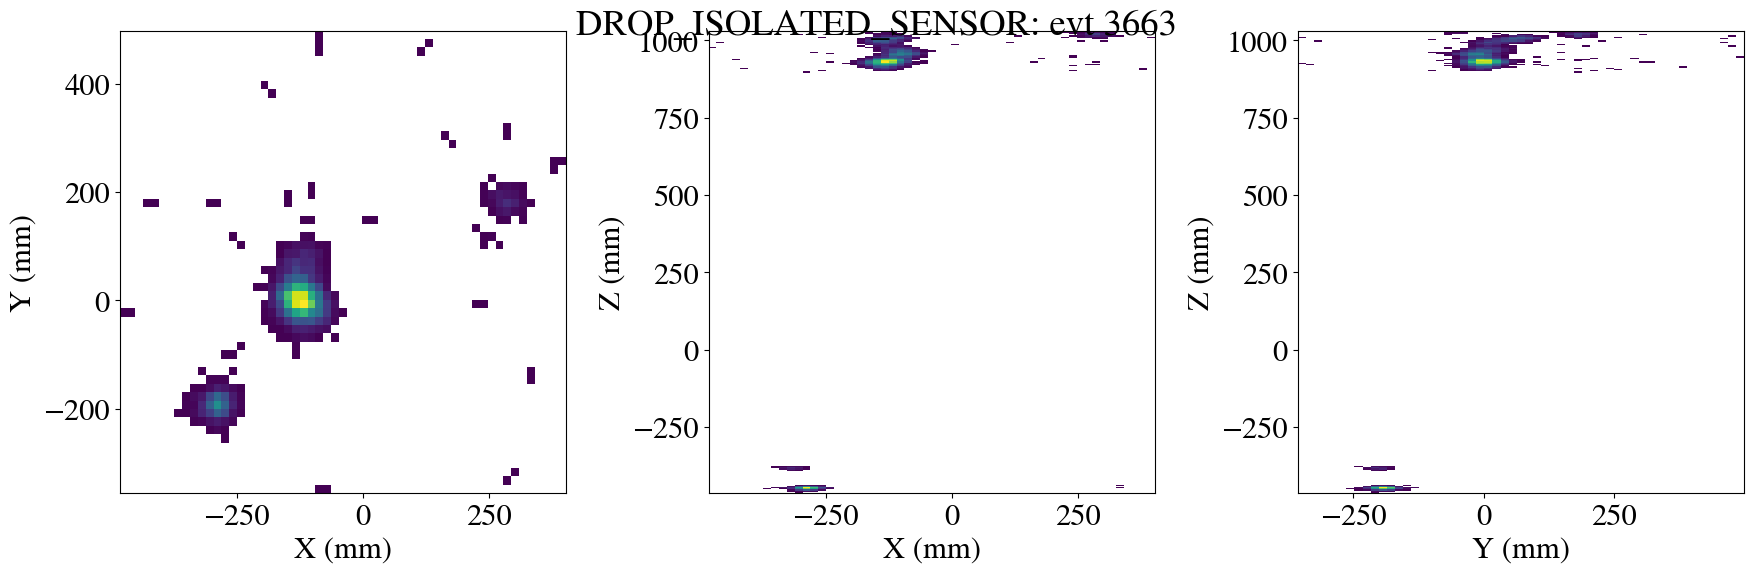

DROP MIRYAM


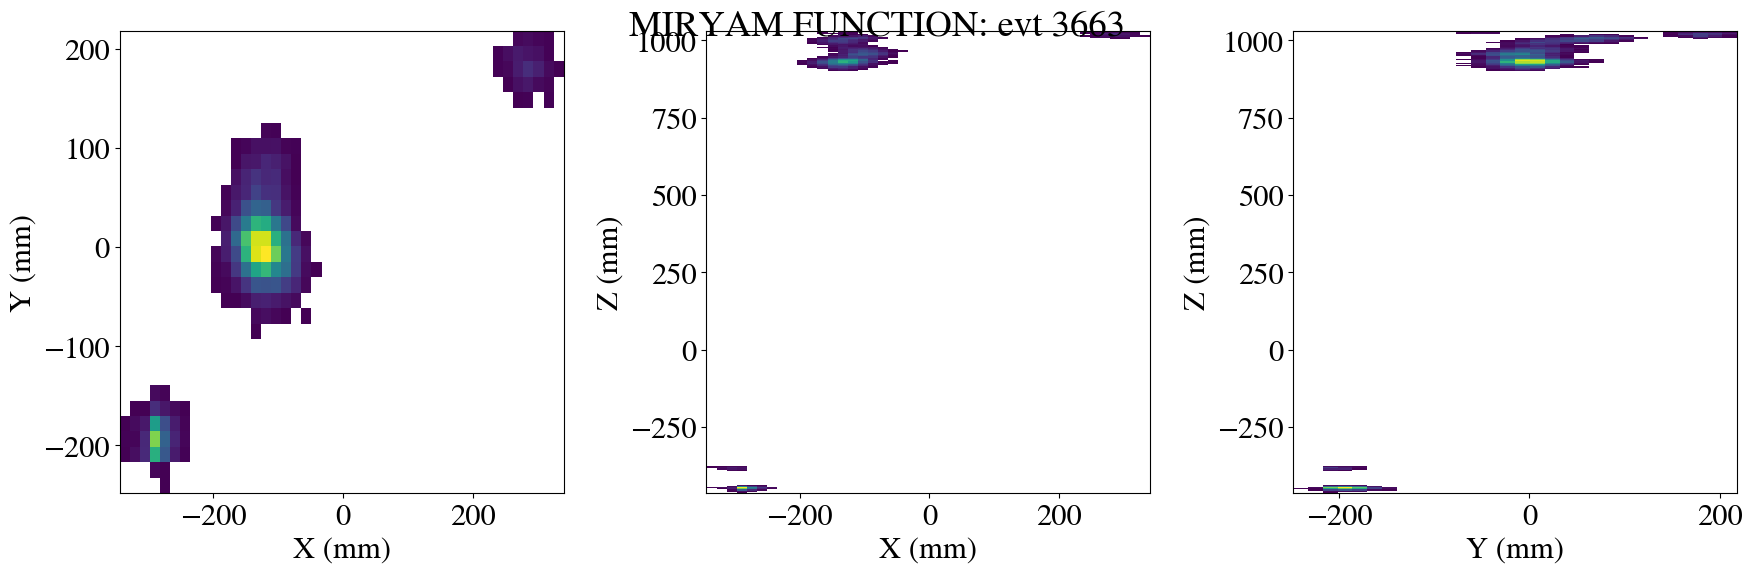

DROP MIRYAM-2D


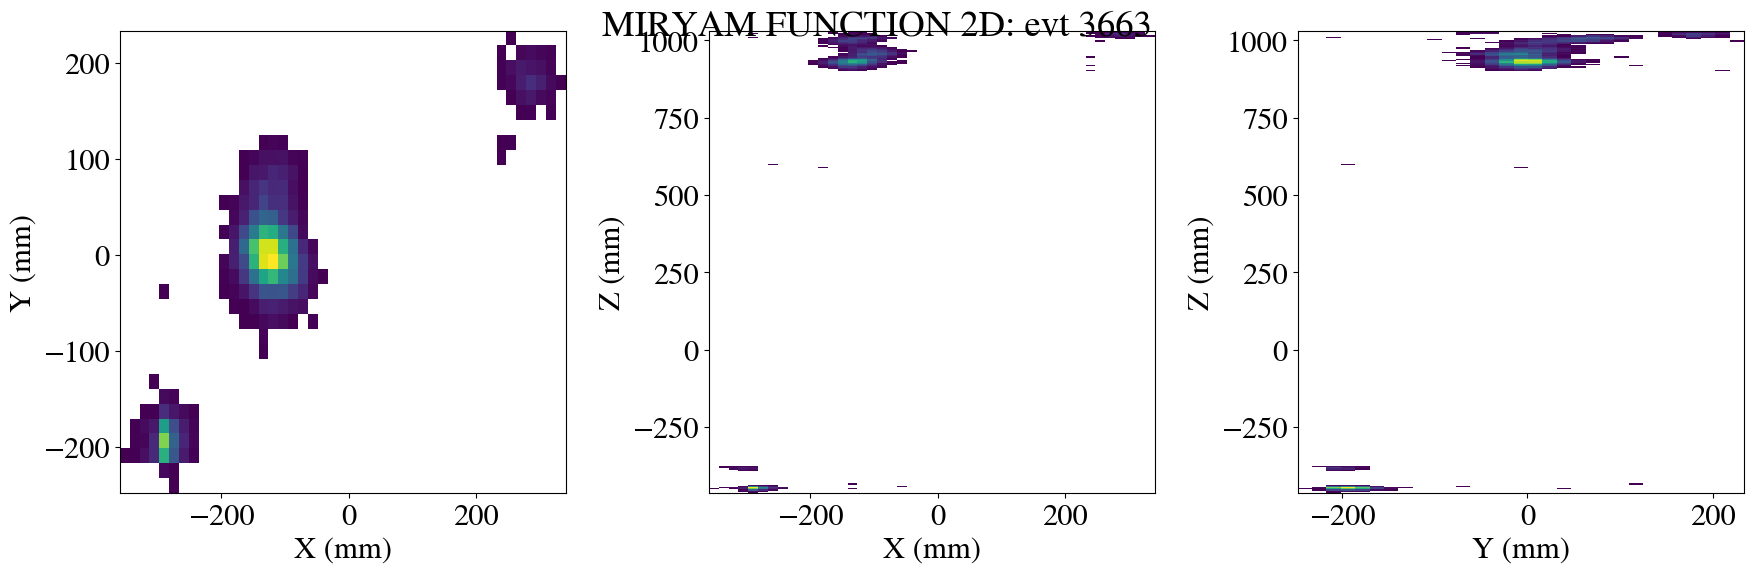

=
=
=
=
=
=
=
=
=
=

5 3719
RAW


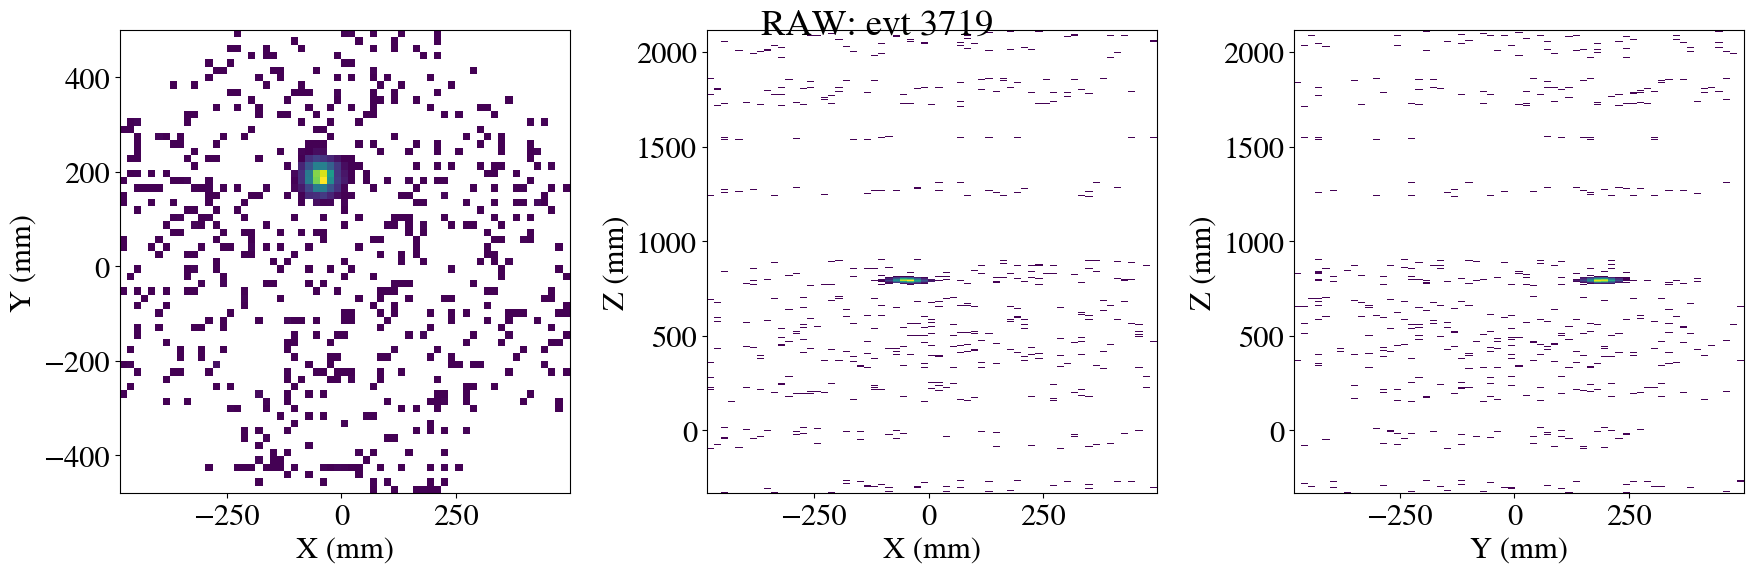

CUT


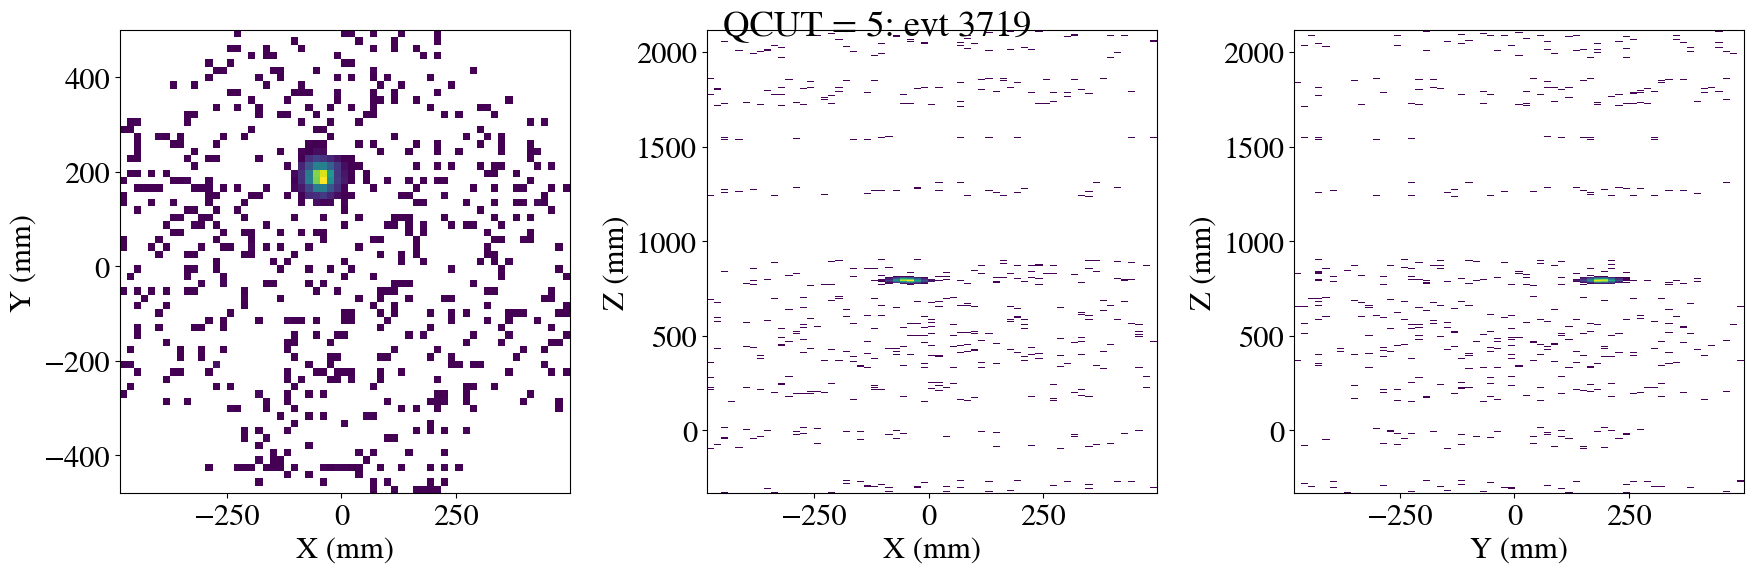

DROP CLUSTER


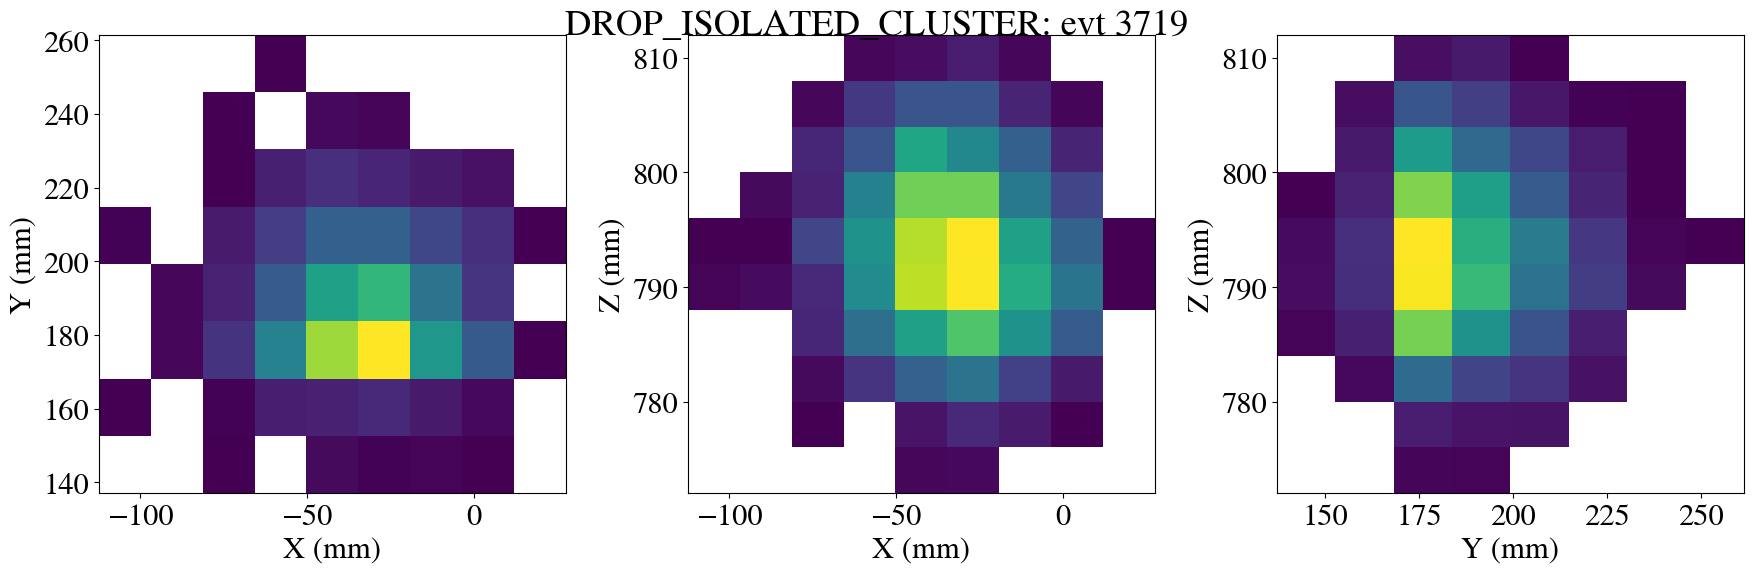

DROP CLUSTER FAST


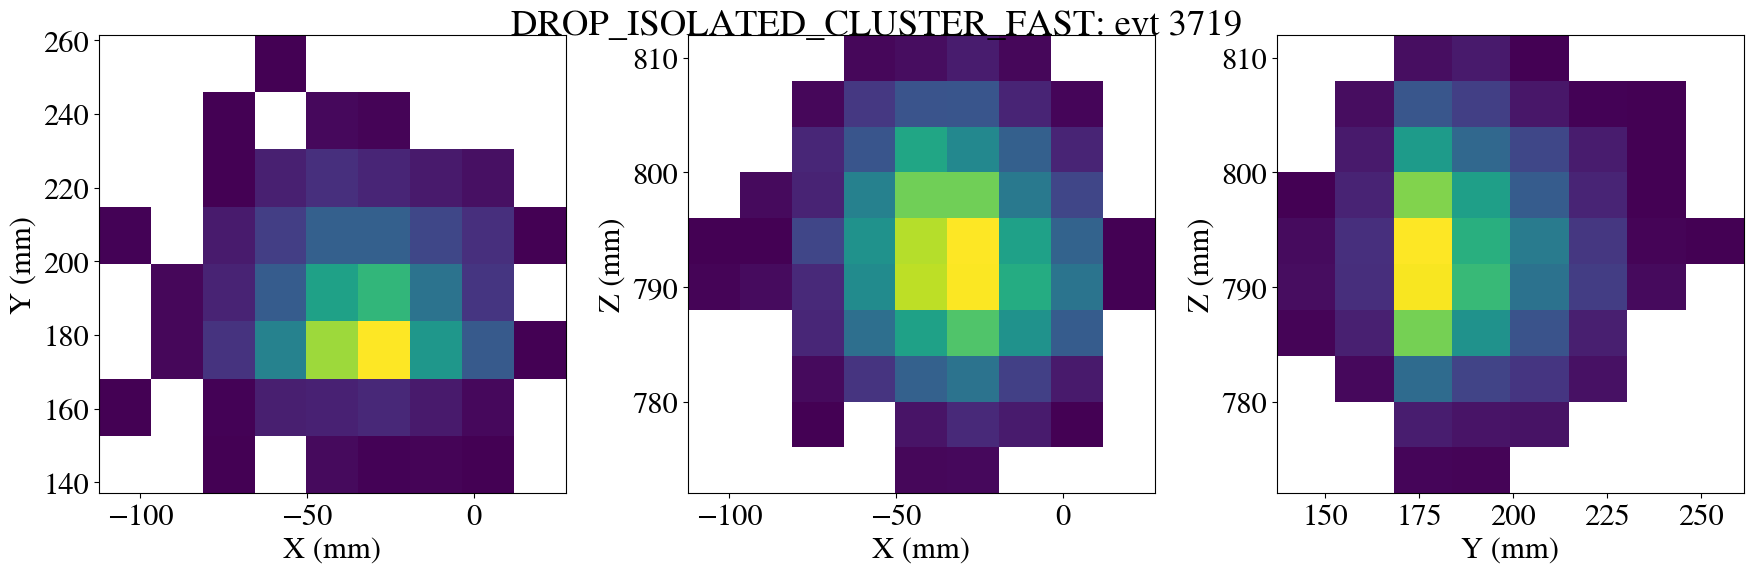

DROP SENSOR


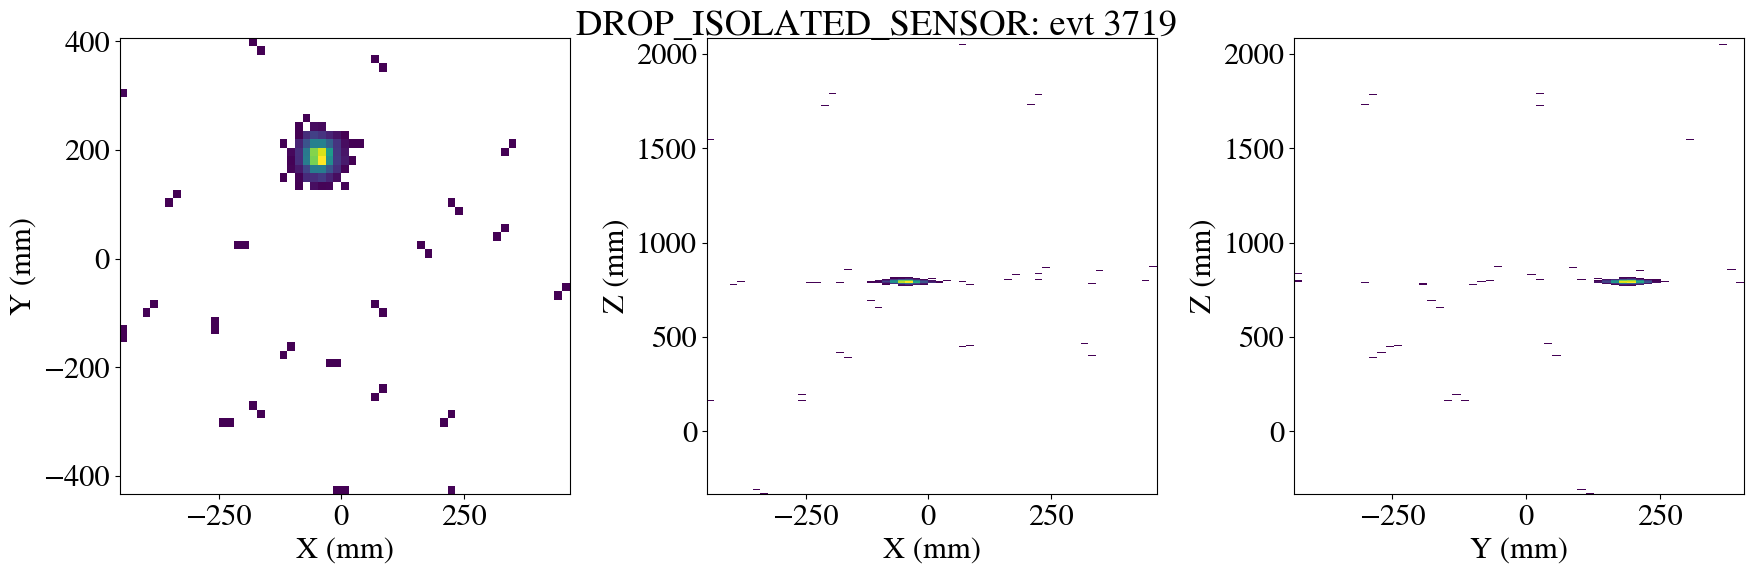

DROP MIRYAM


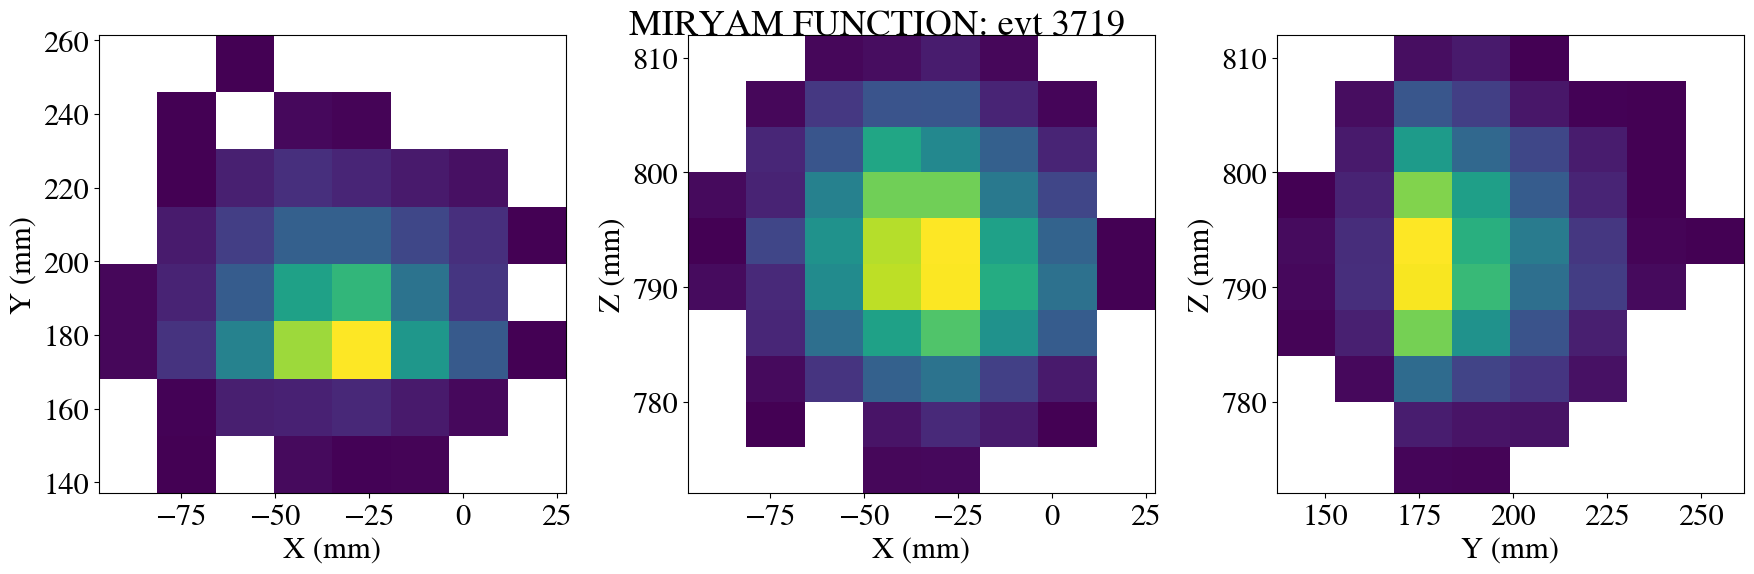

DROP MIRYAM-2D


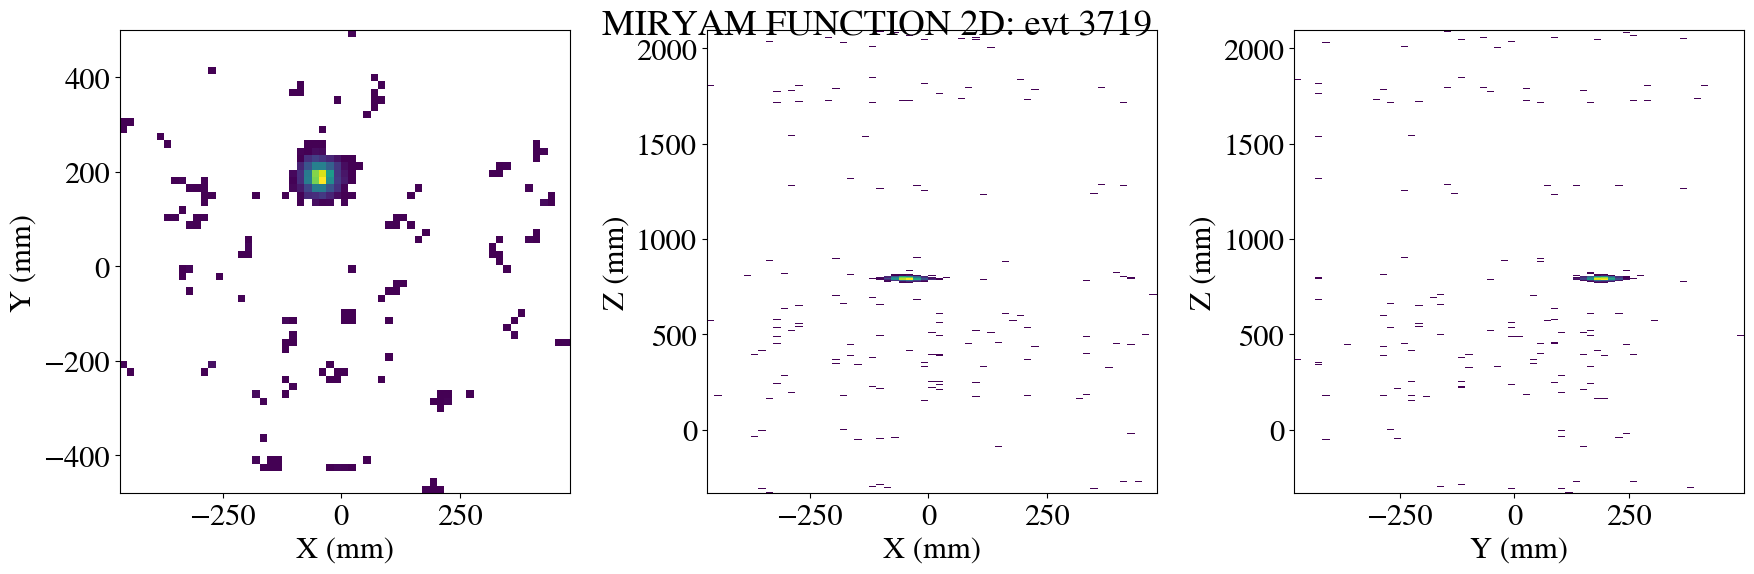

=
=
=
=
=
=
=
=
=
=

6 4048
RAW


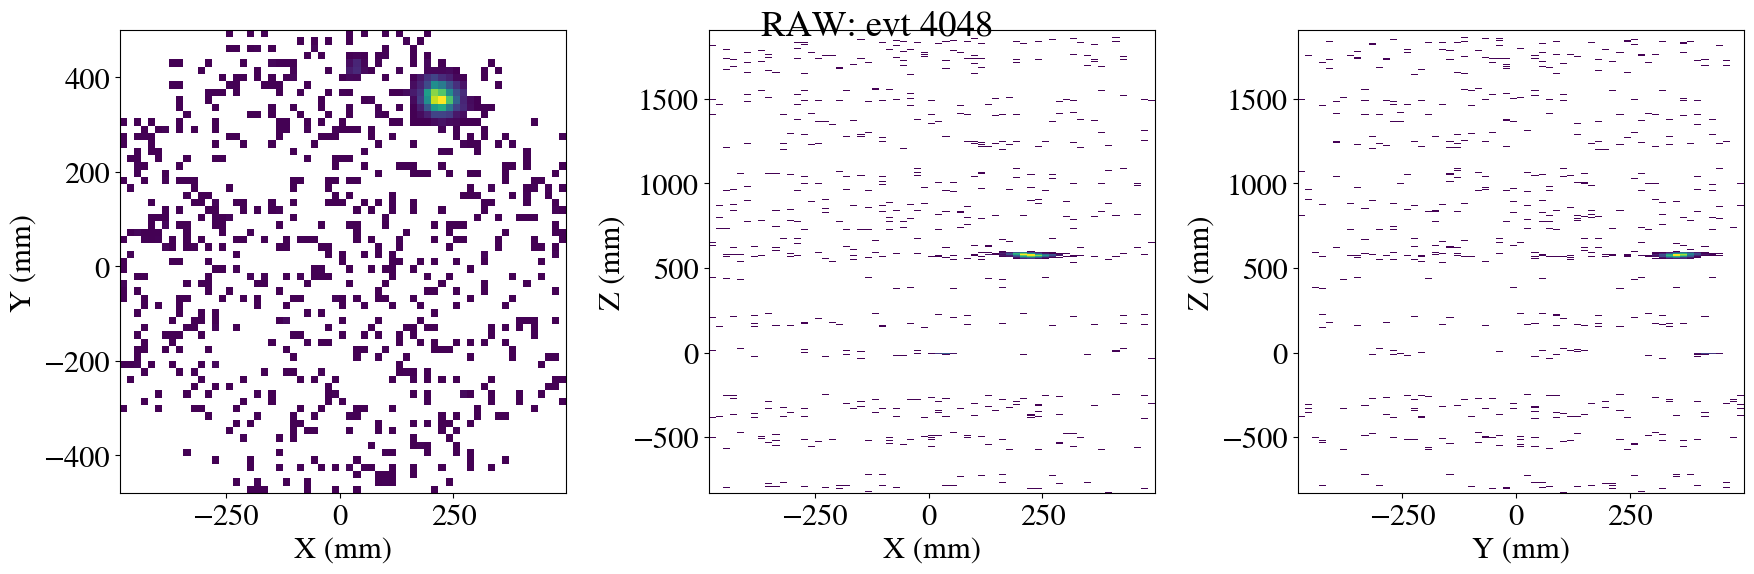

CUT


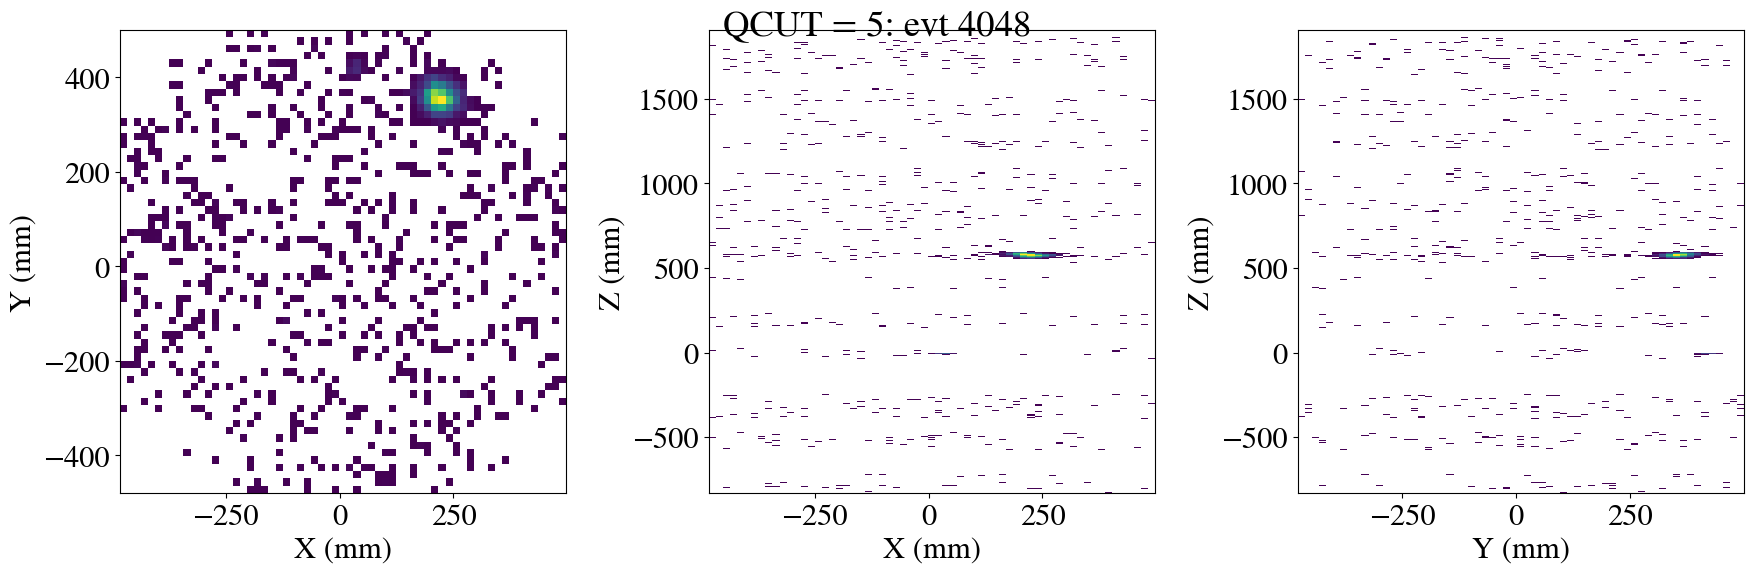

DROP CLUSTER


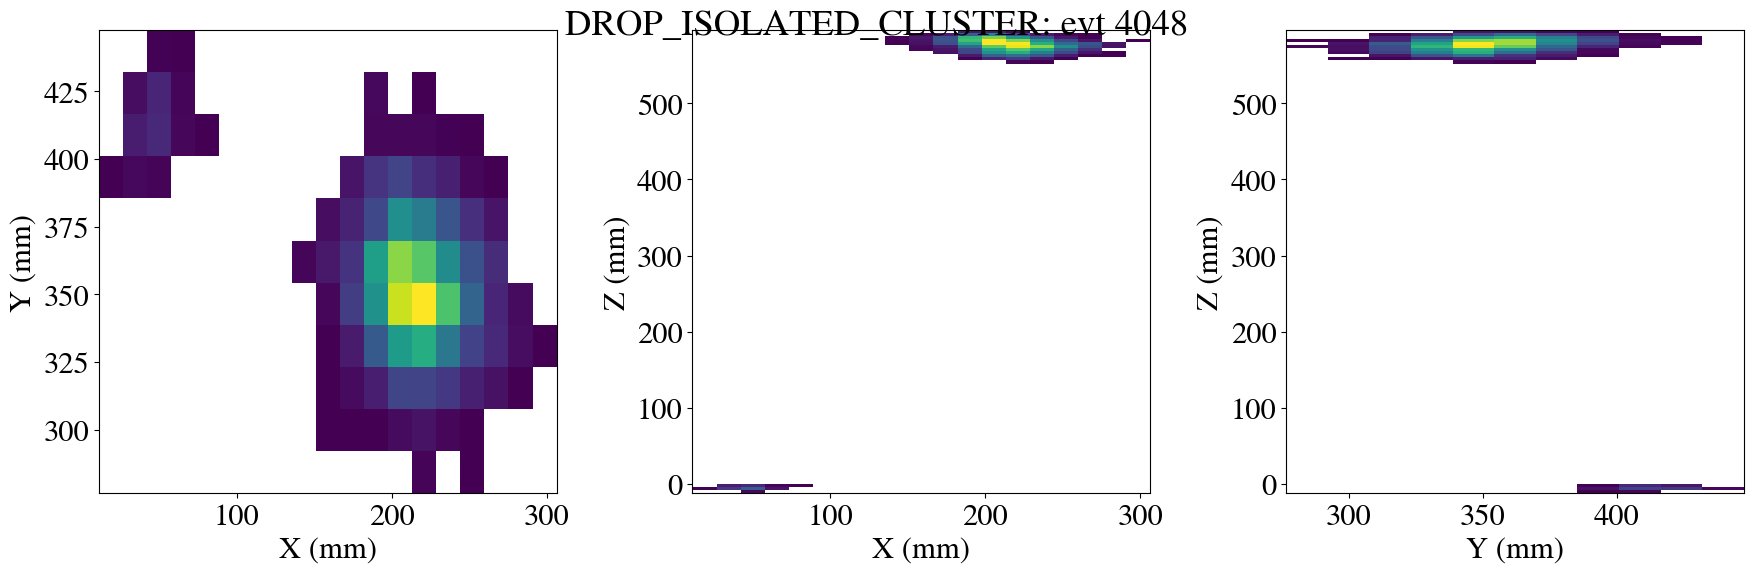

DROP CLUSTER FAST


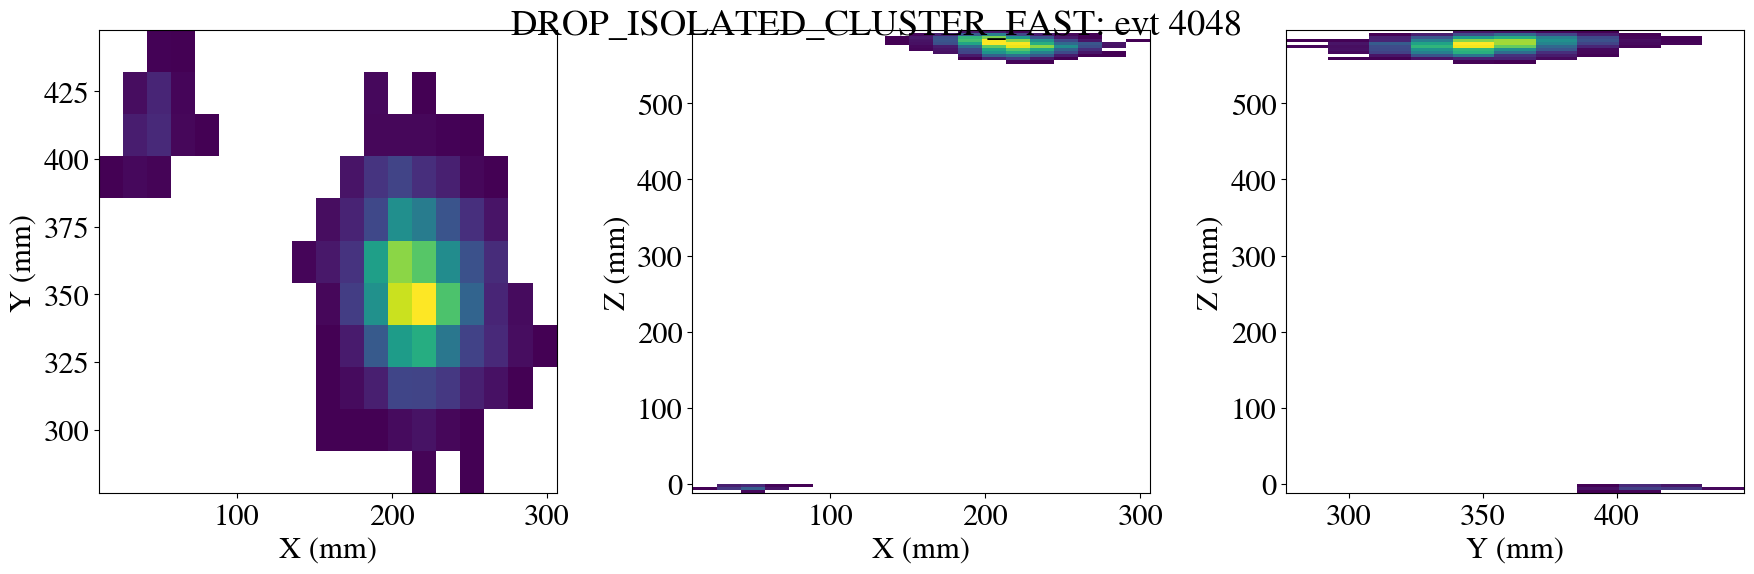

DROP SENSOR


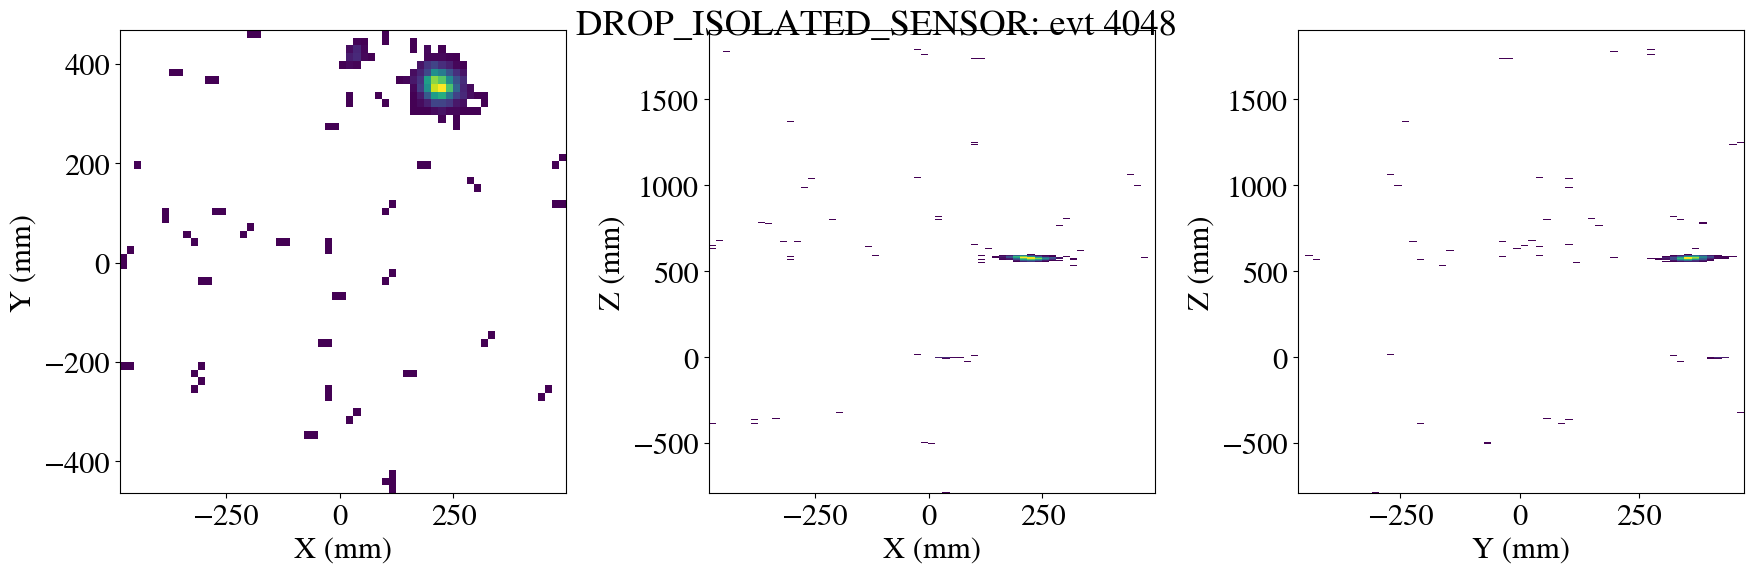

DROP MIRYAM


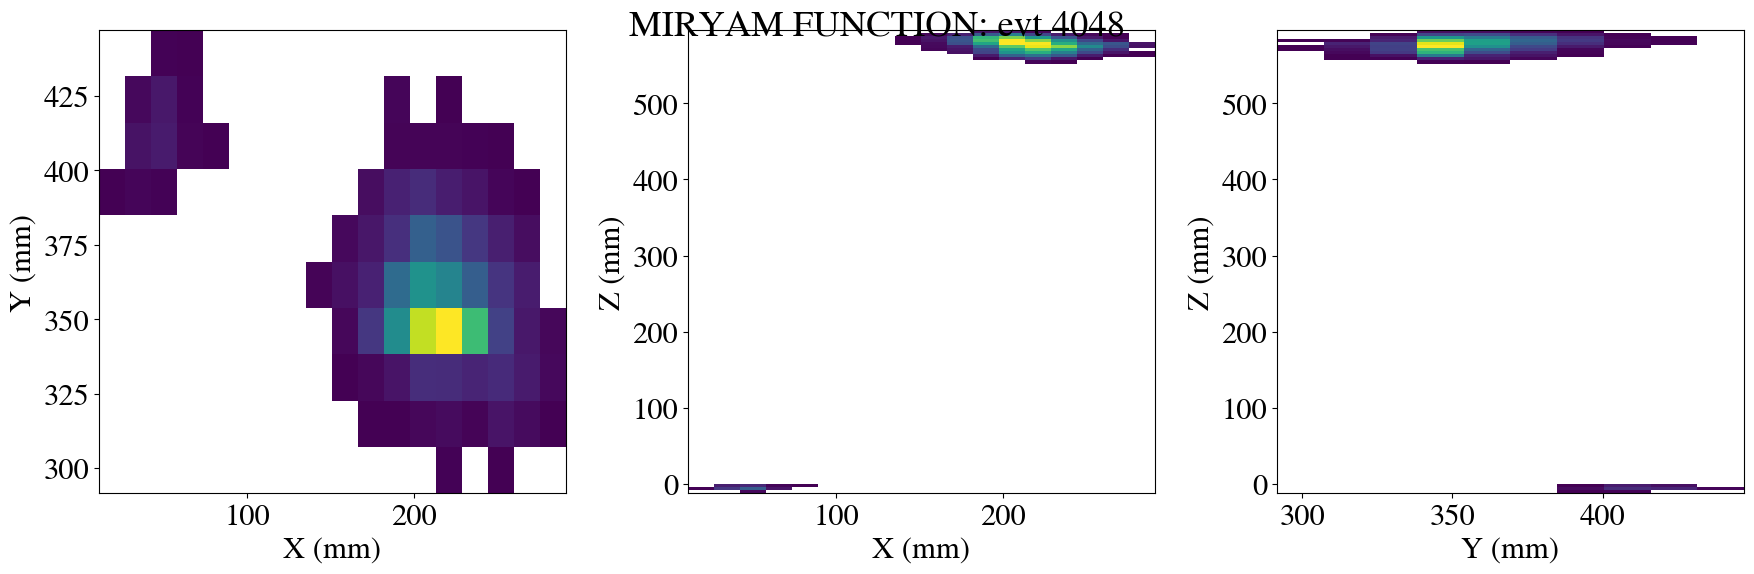

DROP MIRYAM-2D


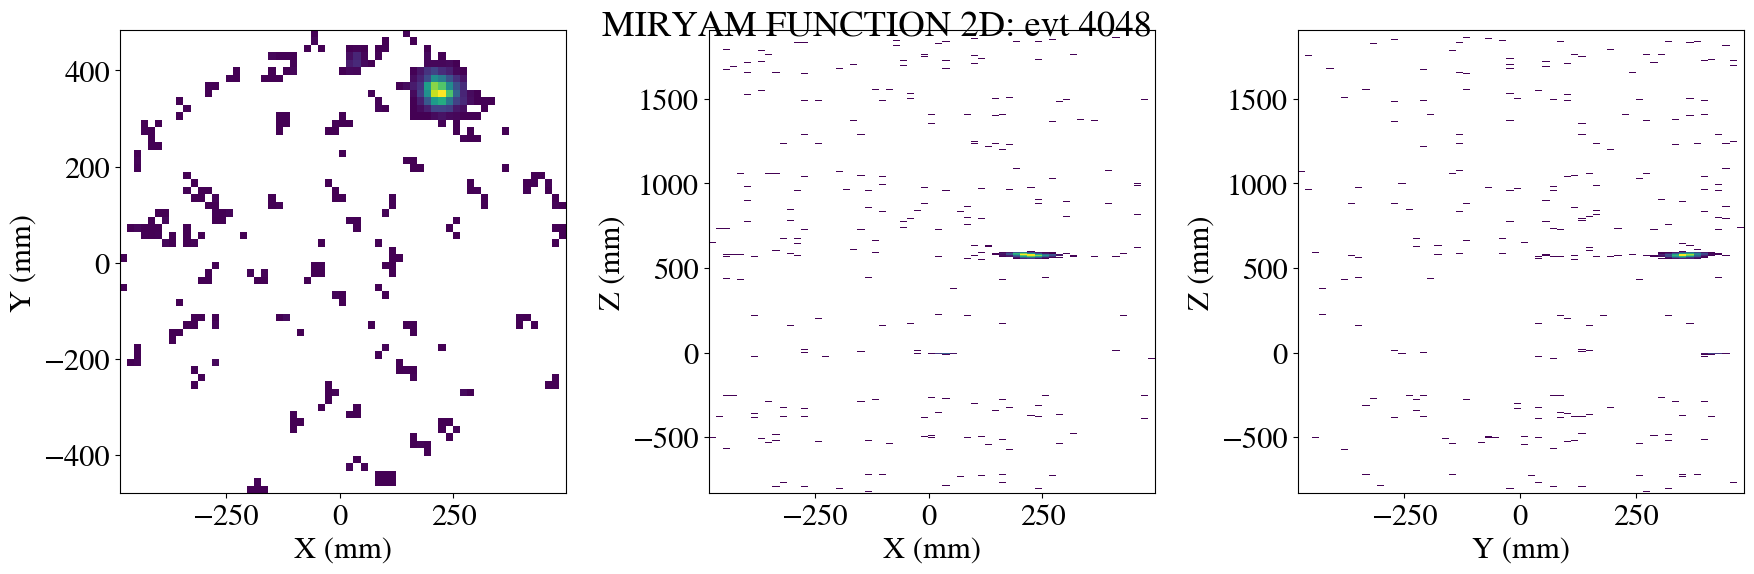

=
=
=
=
=
=
=
=
=
=

7 4083
RAW


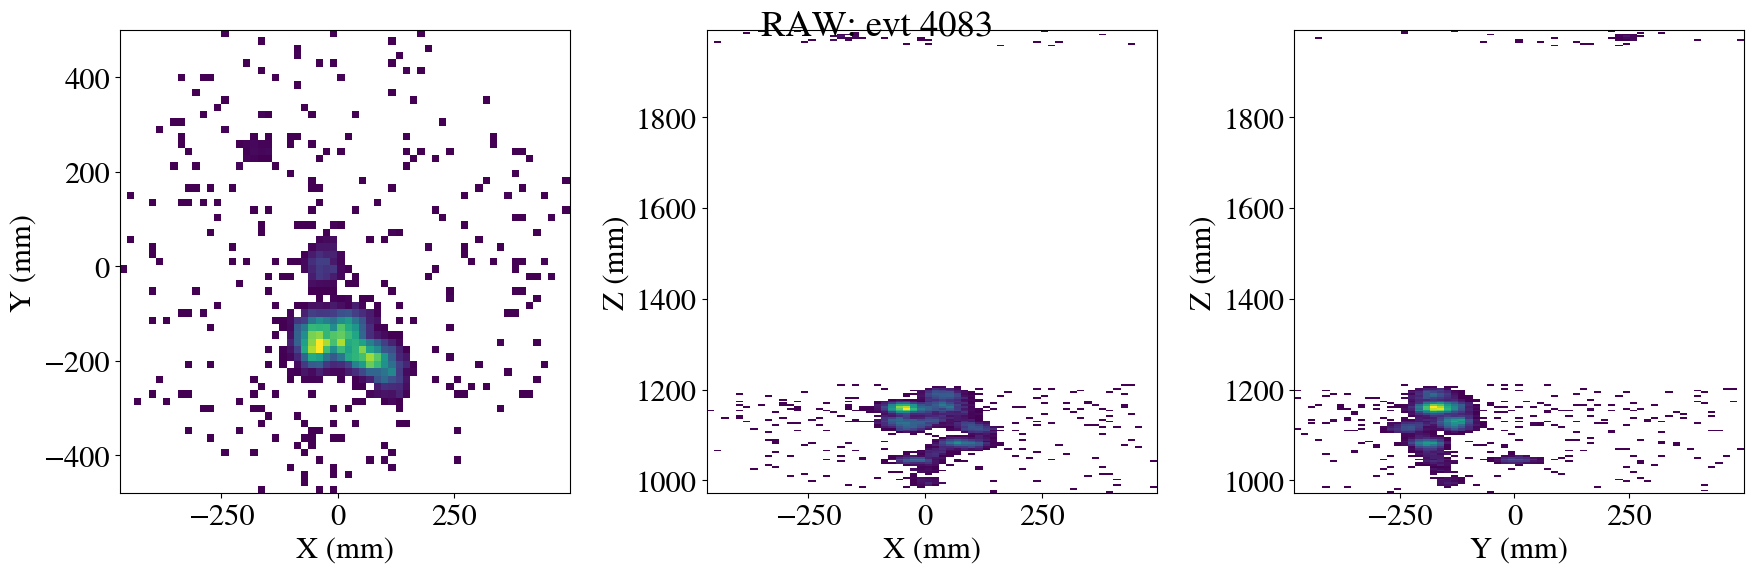

CUT


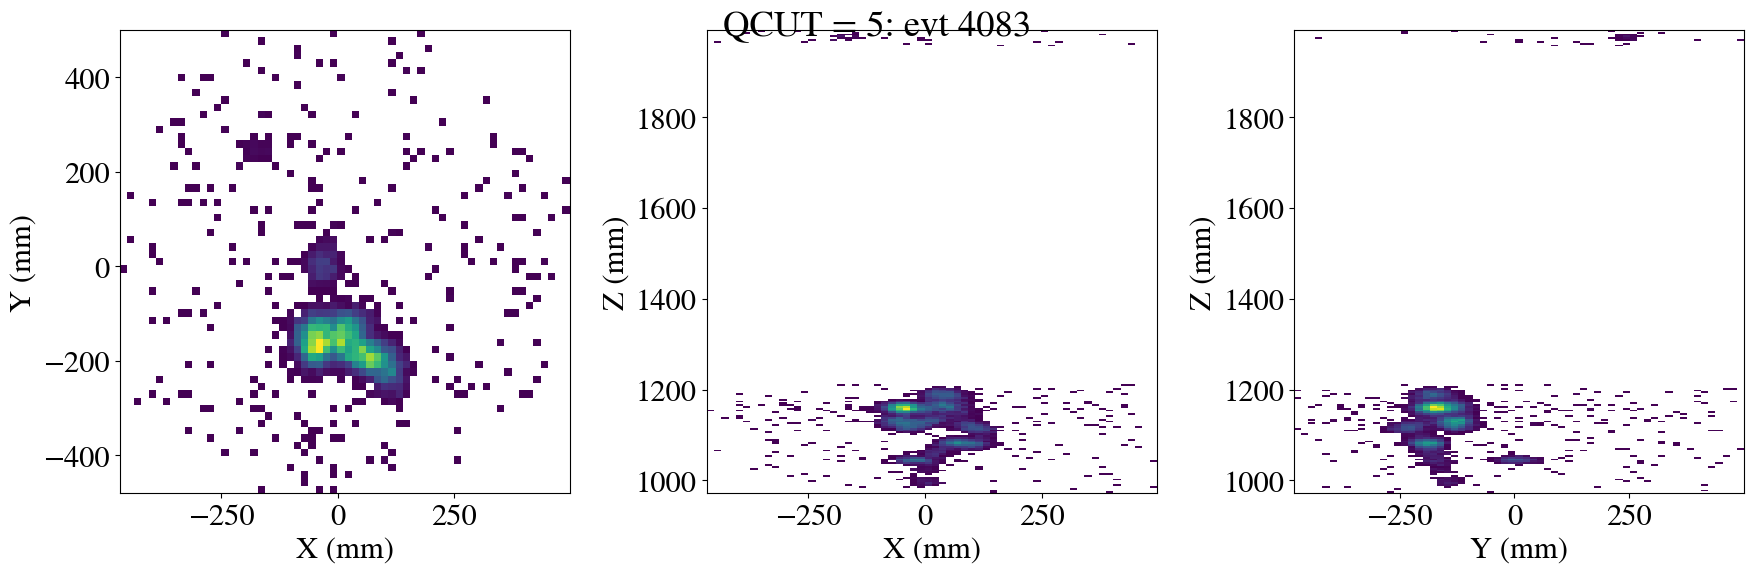

DROP CLUSTER


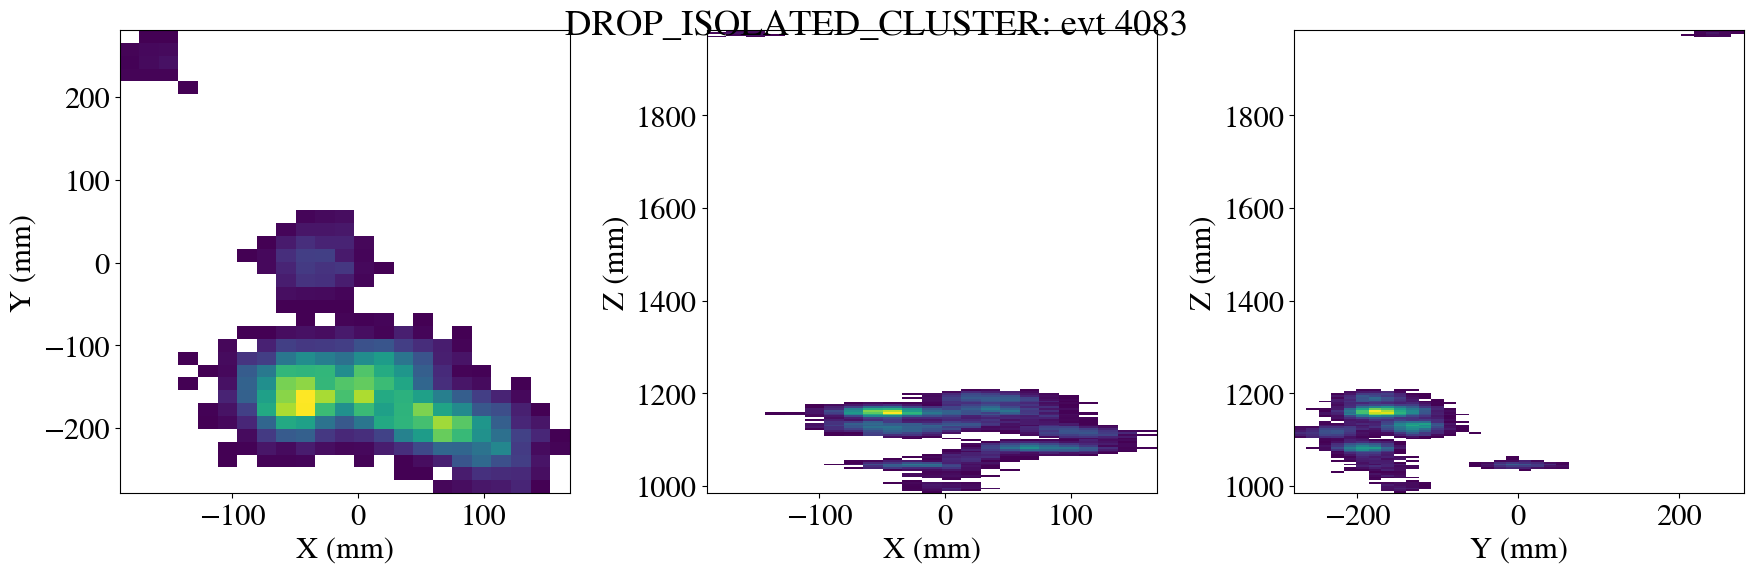

DROP CLUSTER FAST


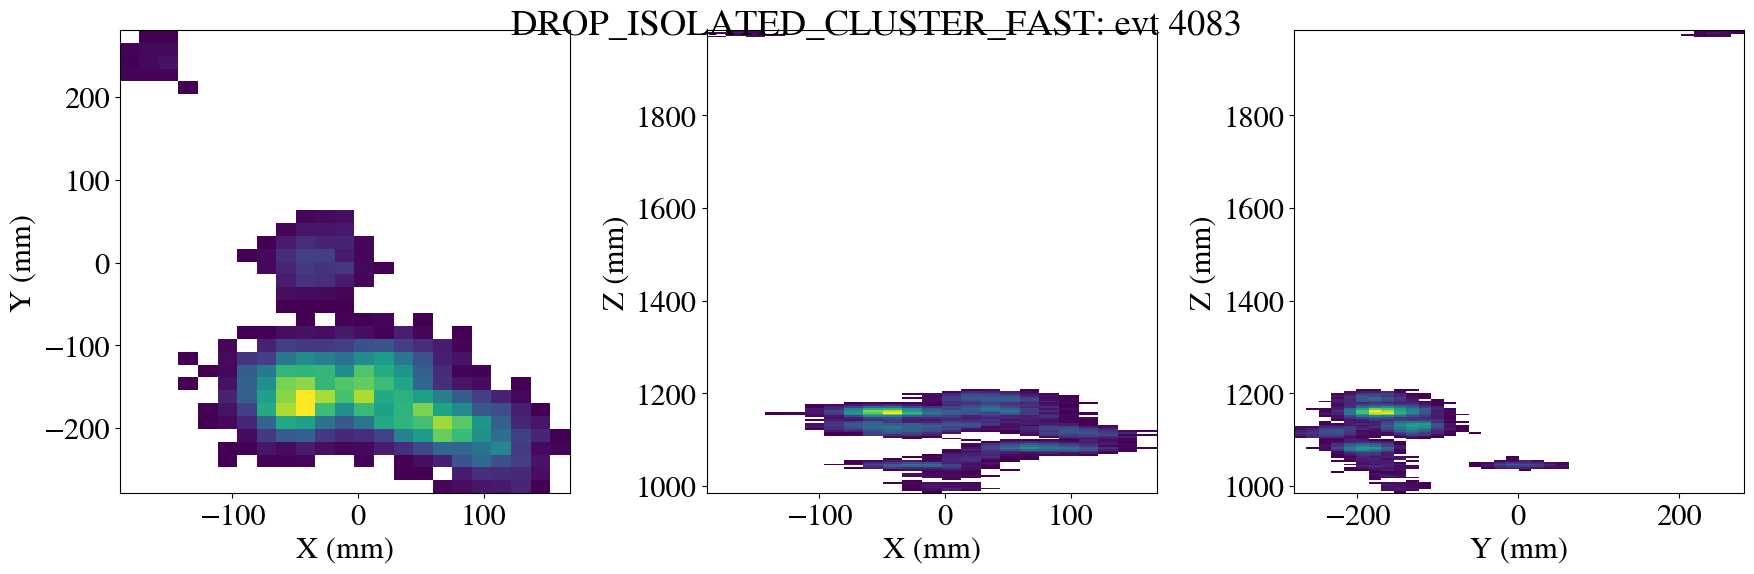

DROP SENSOR


DROP MIRYAM


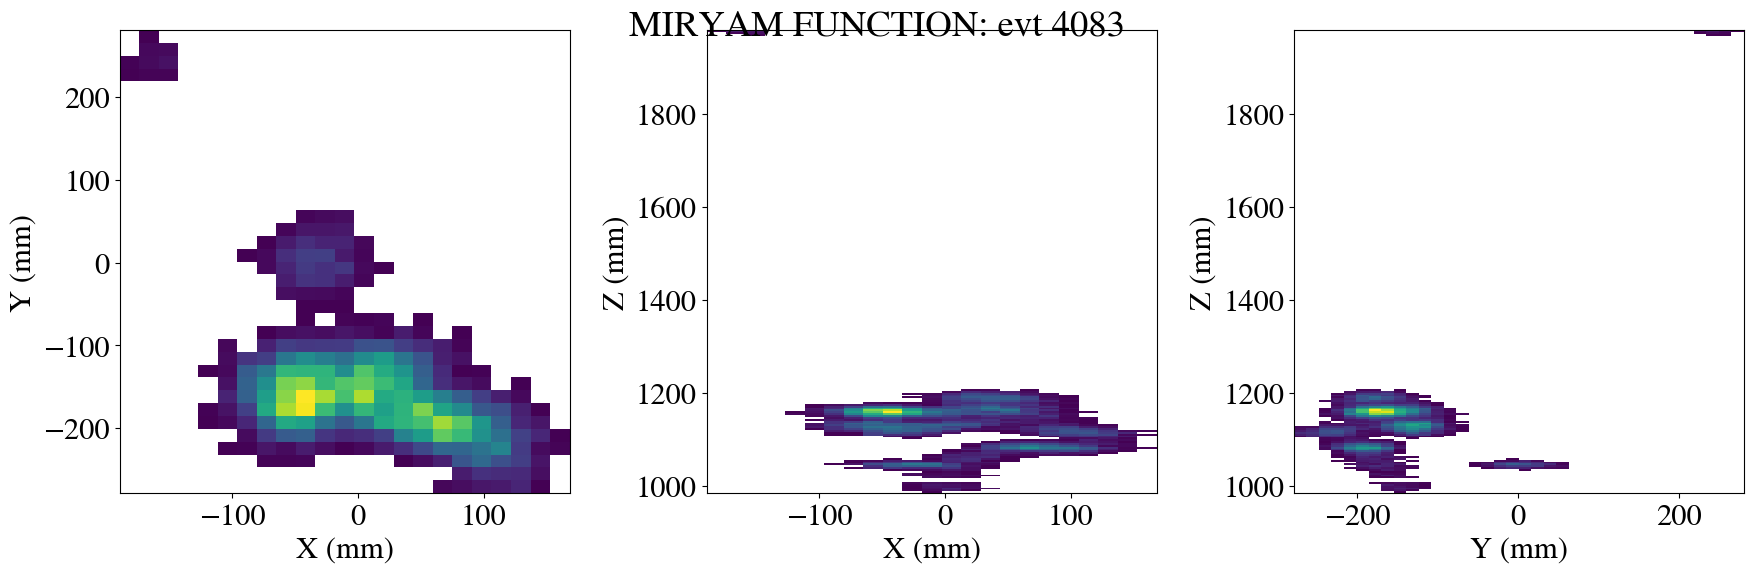

DROP MIRYAM-2D


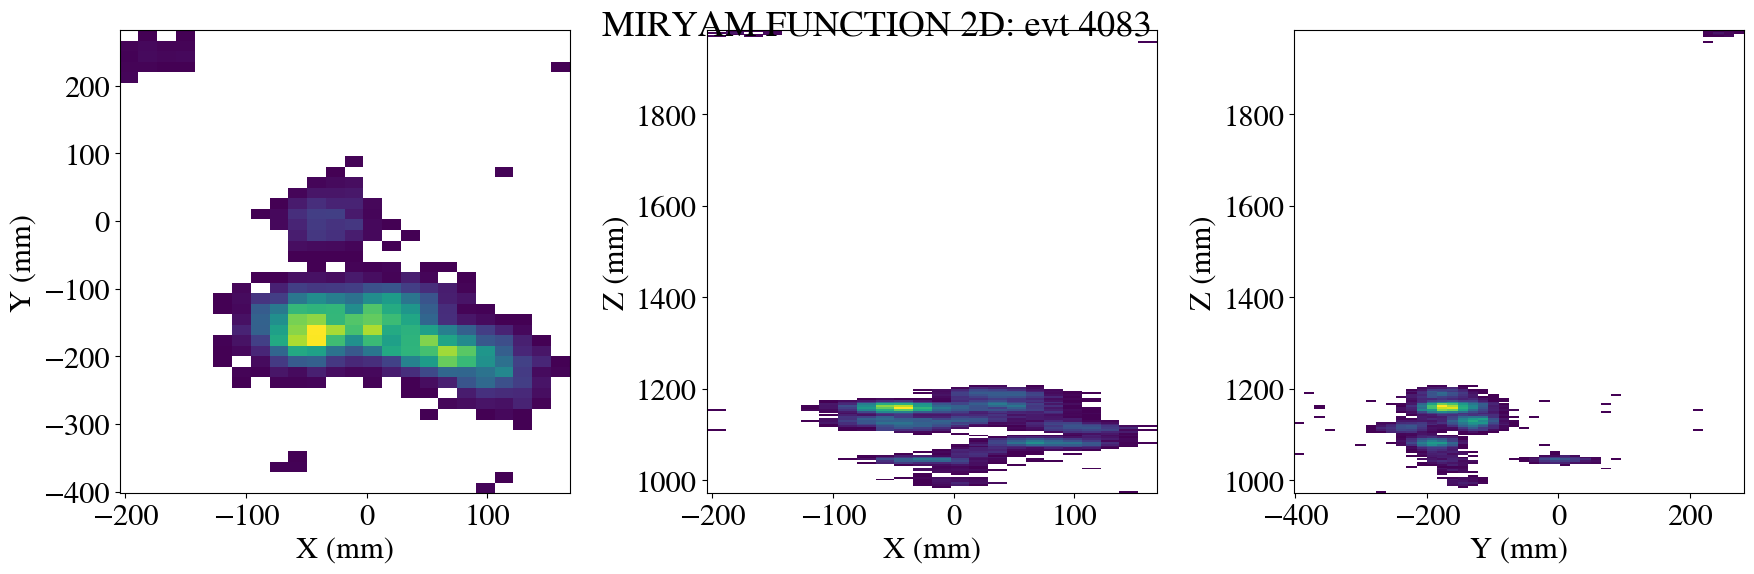

=
=
=
=
=
=
=
=
=
=

8 4167
RAW


CUT


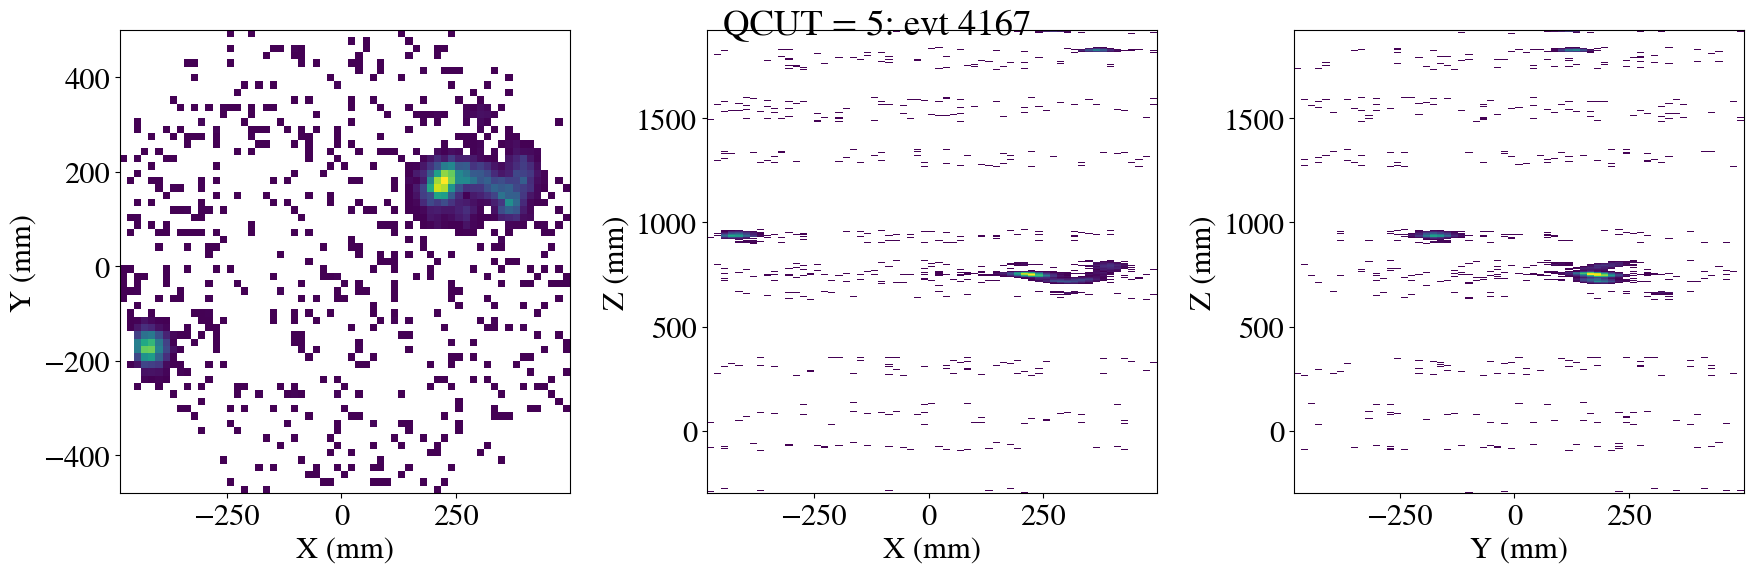

DROP CLUSTER


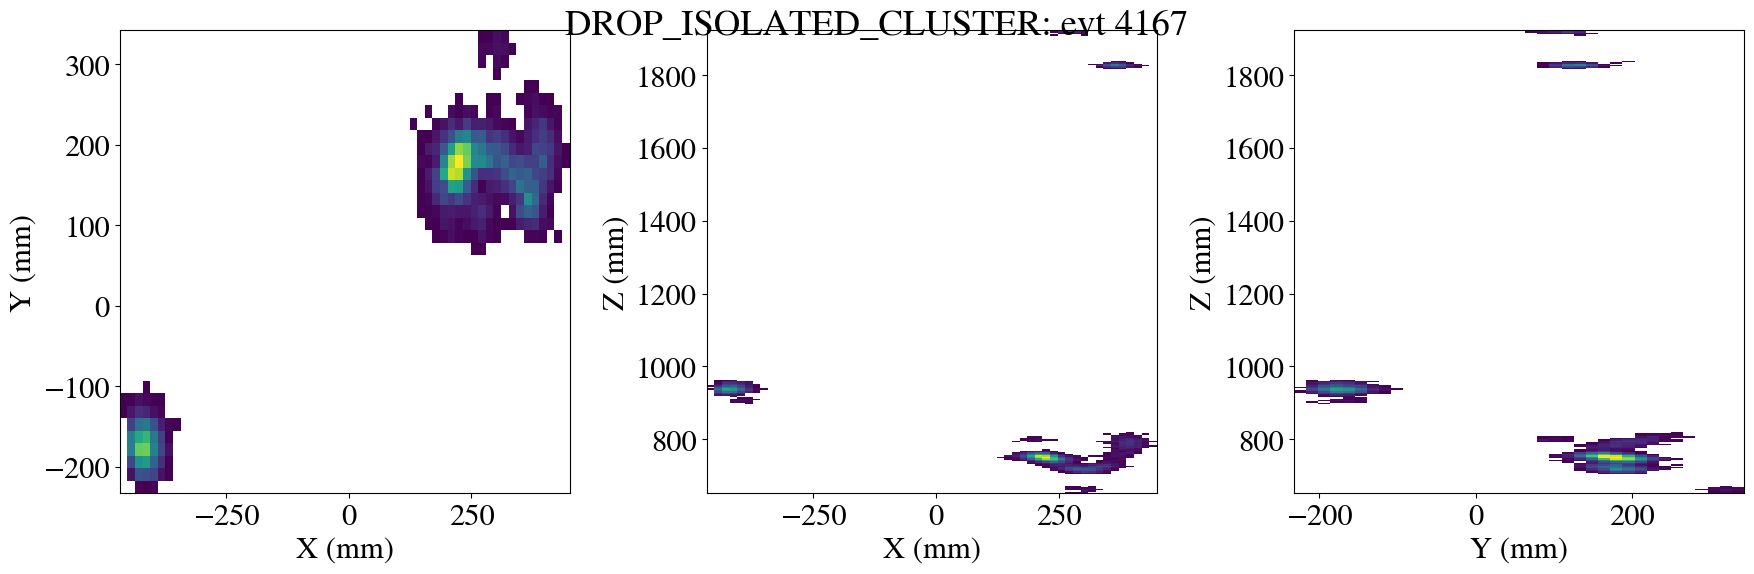

DROP CLUSTER FAST


DROP SENSOR


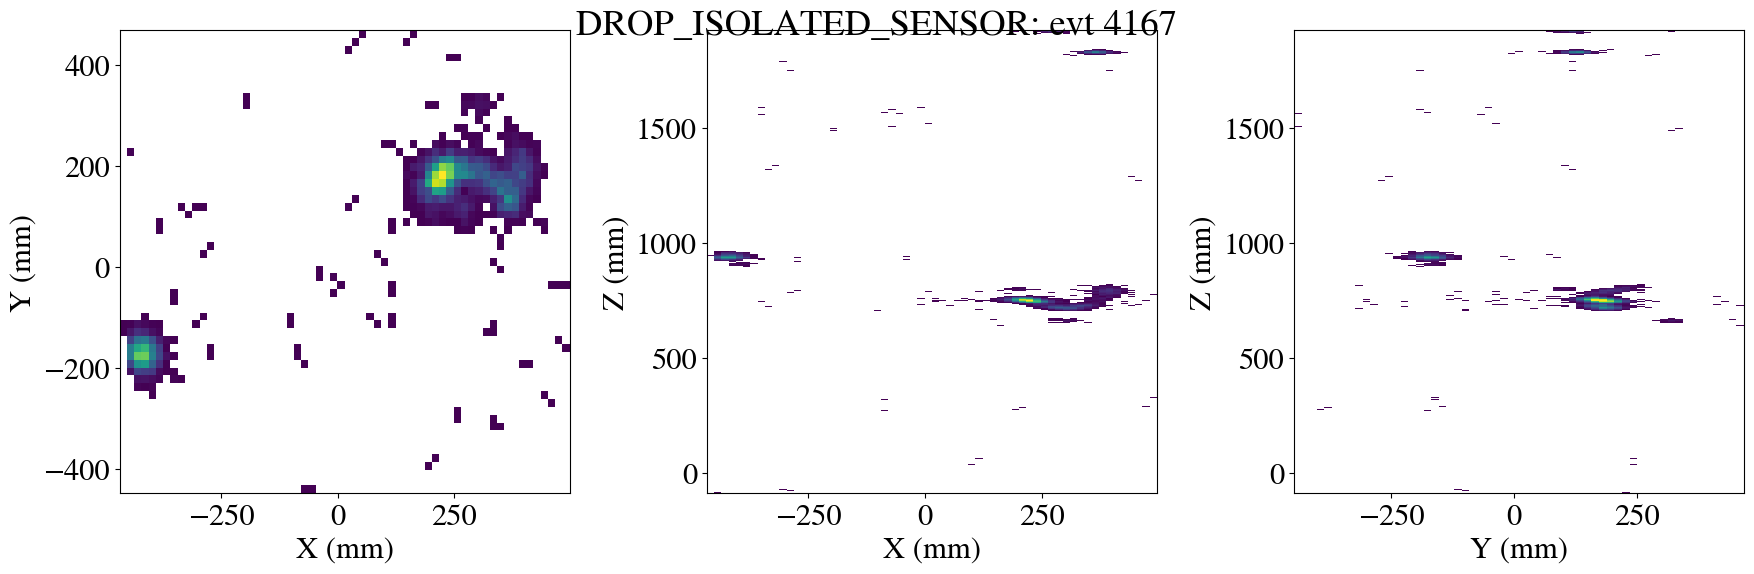

DROP MIRYAM


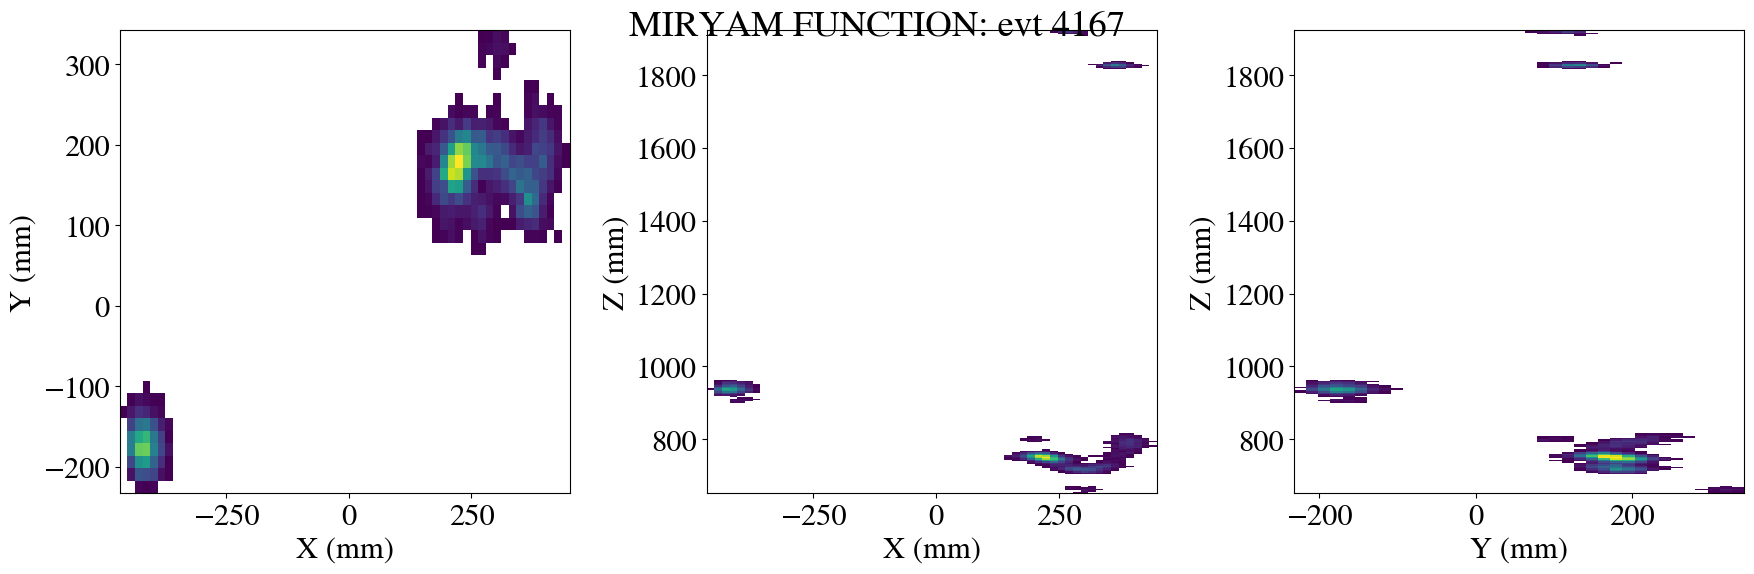

DROP MIRYAM-2D


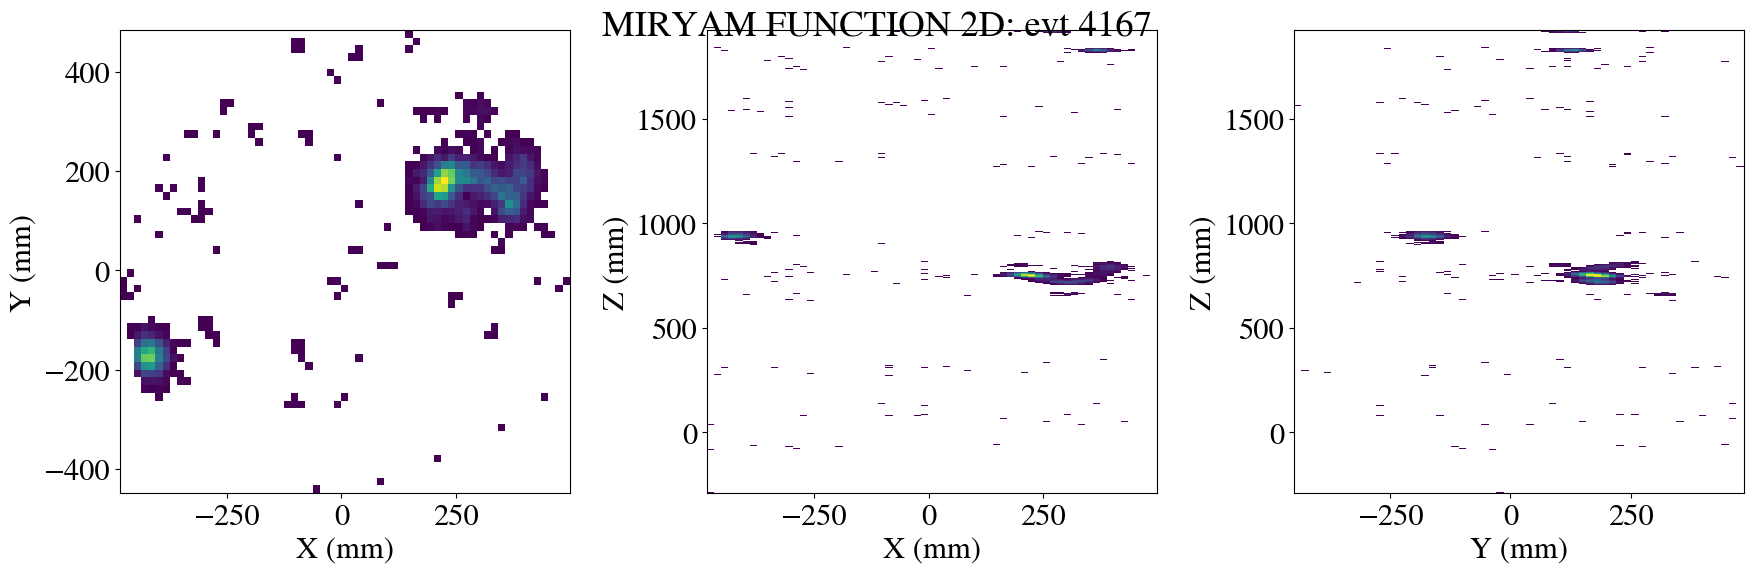

=
=
=
=
=
=
=
=
=
=

9 4174
RAW


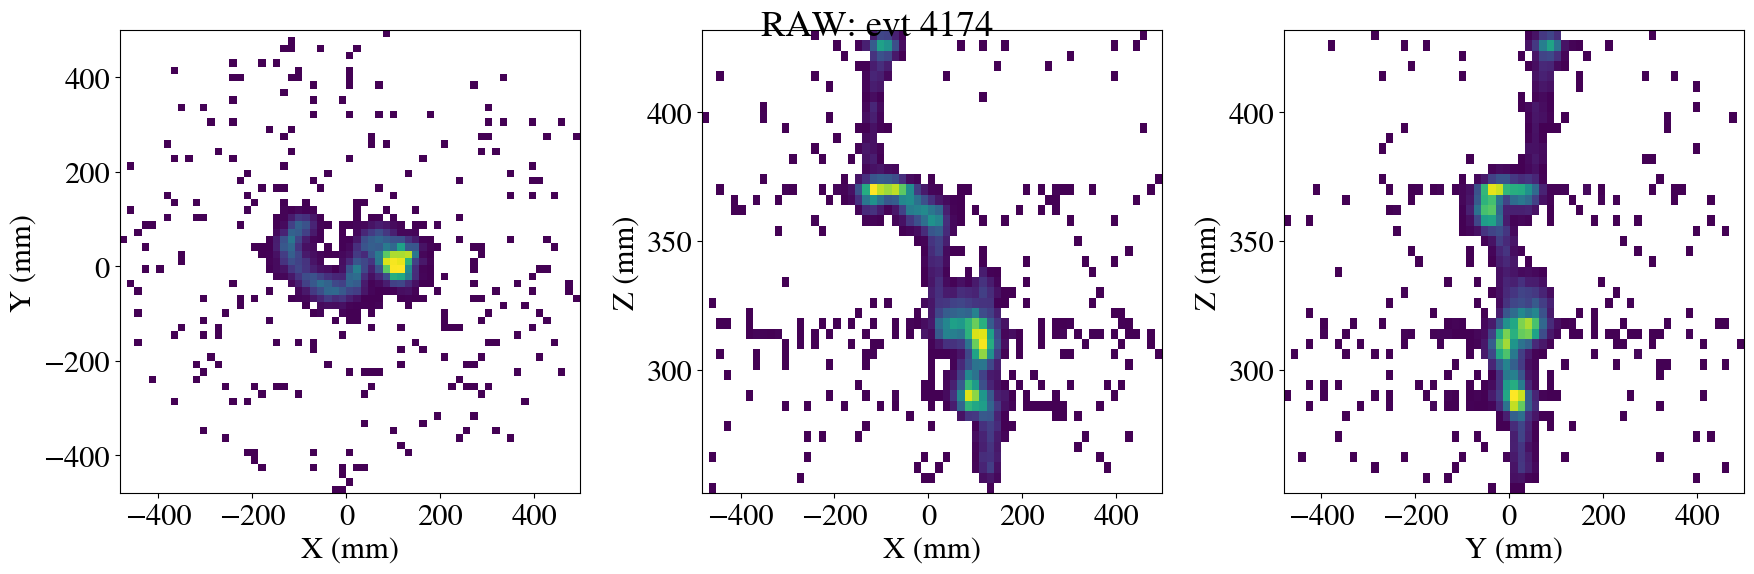

CUT


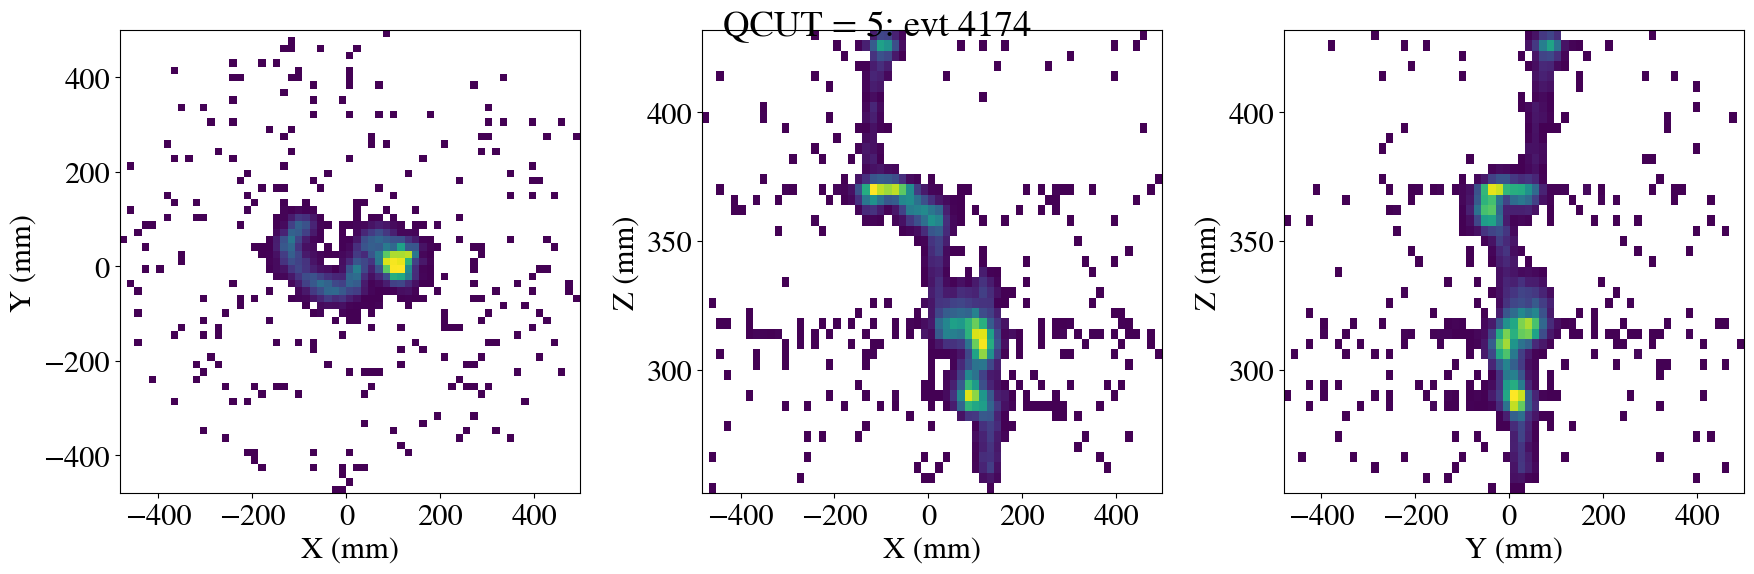

DROP CLUSTER


DROP CLUSTER FAST


DROP SENSOR


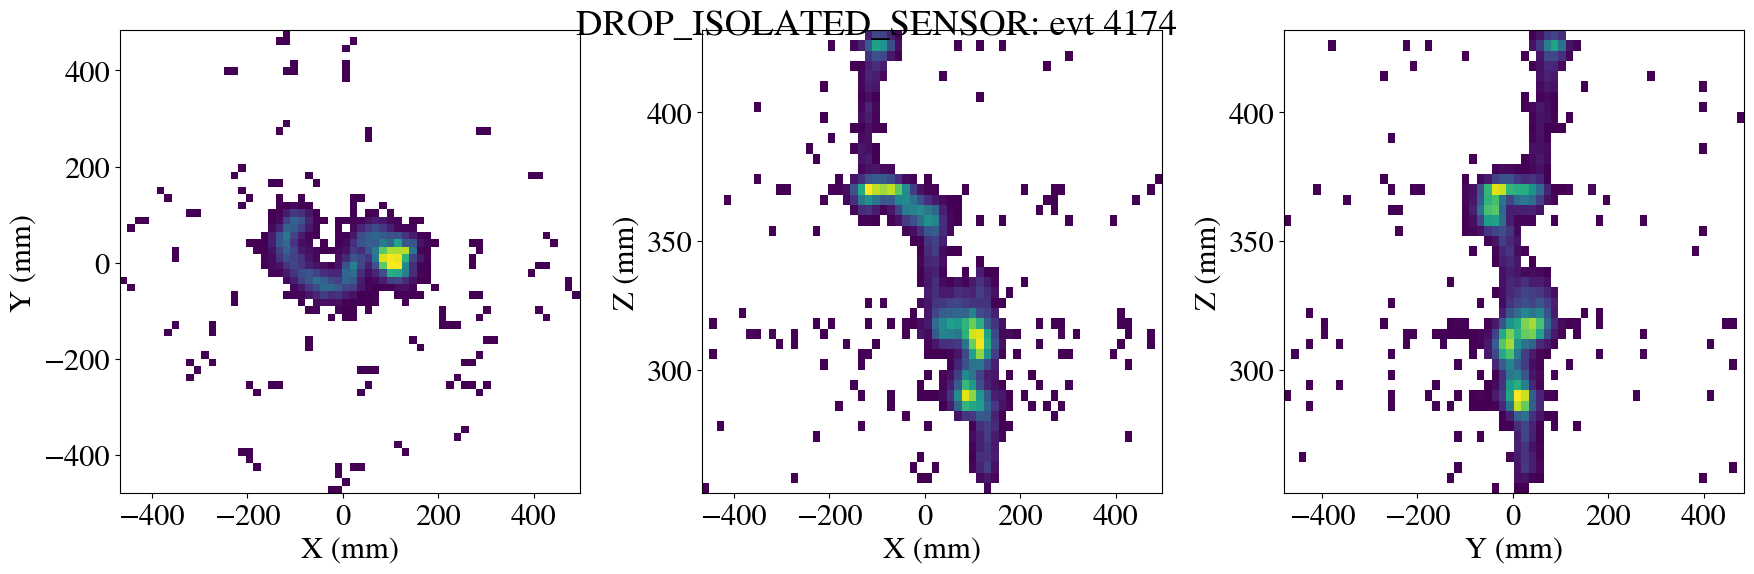

DROP MIRYAM


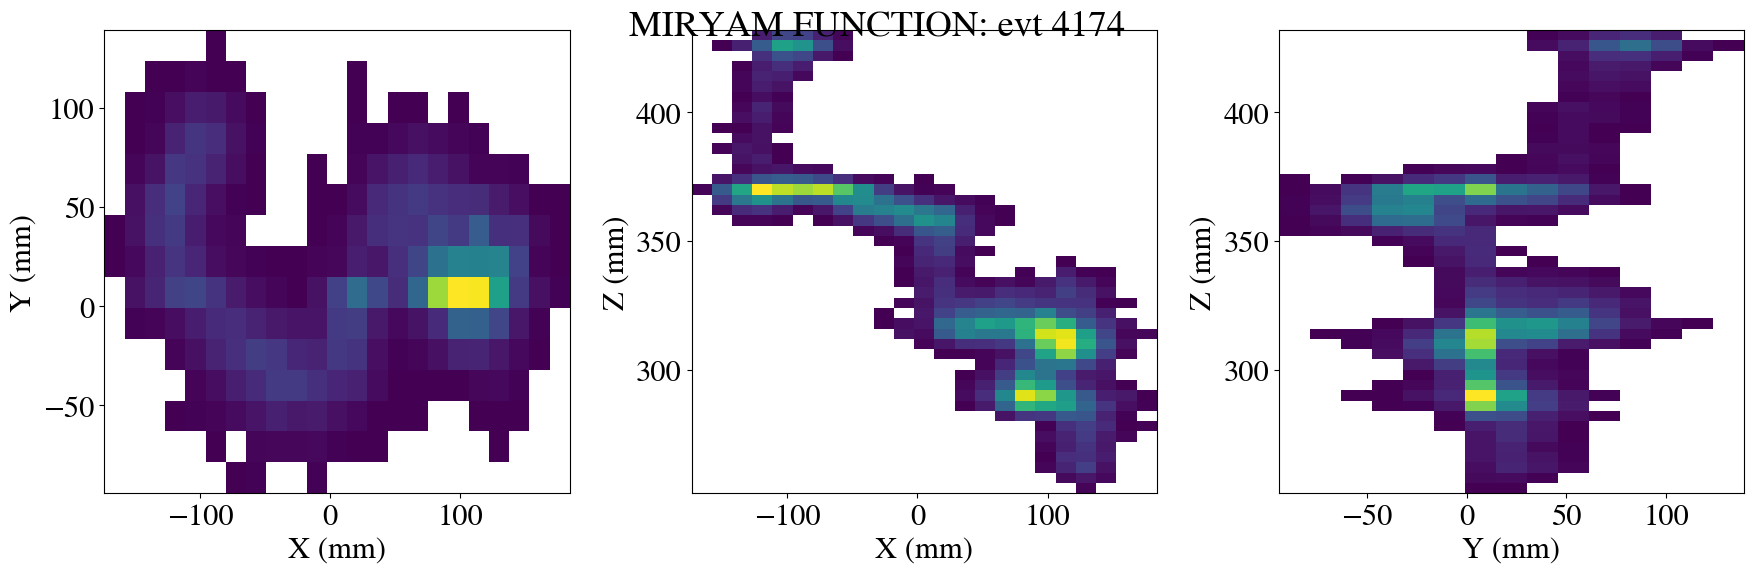

DROP MIRYAM-2D


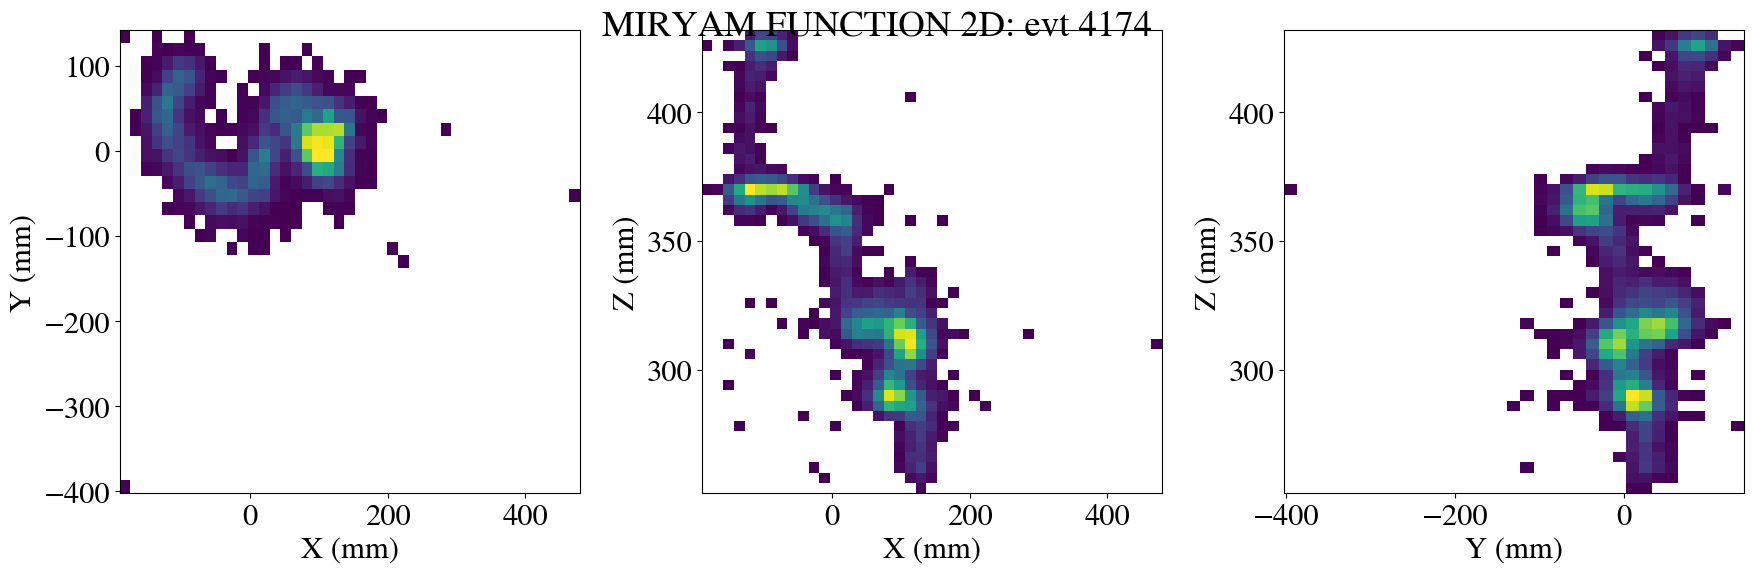

=
=
=
=
=
=
=
=
=
=

10 4307
RAW


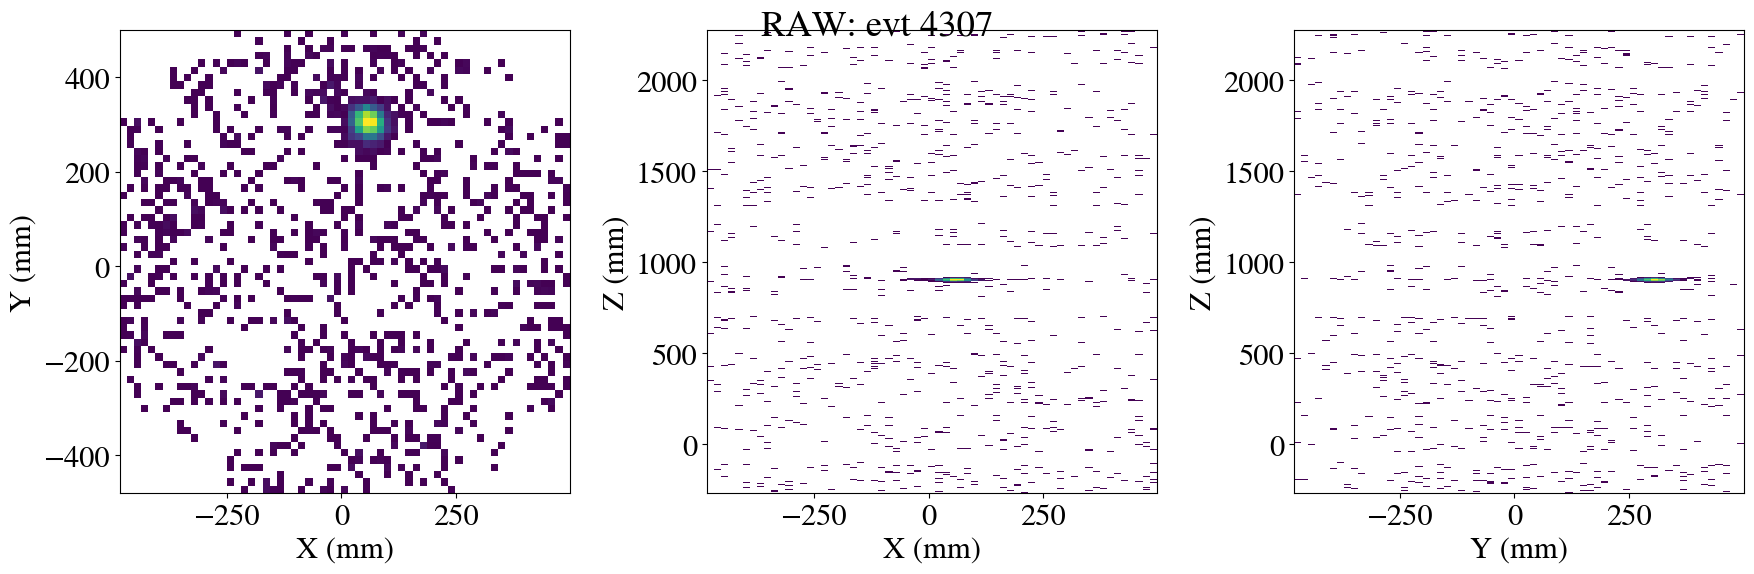

CUT


DROP CLUSTER


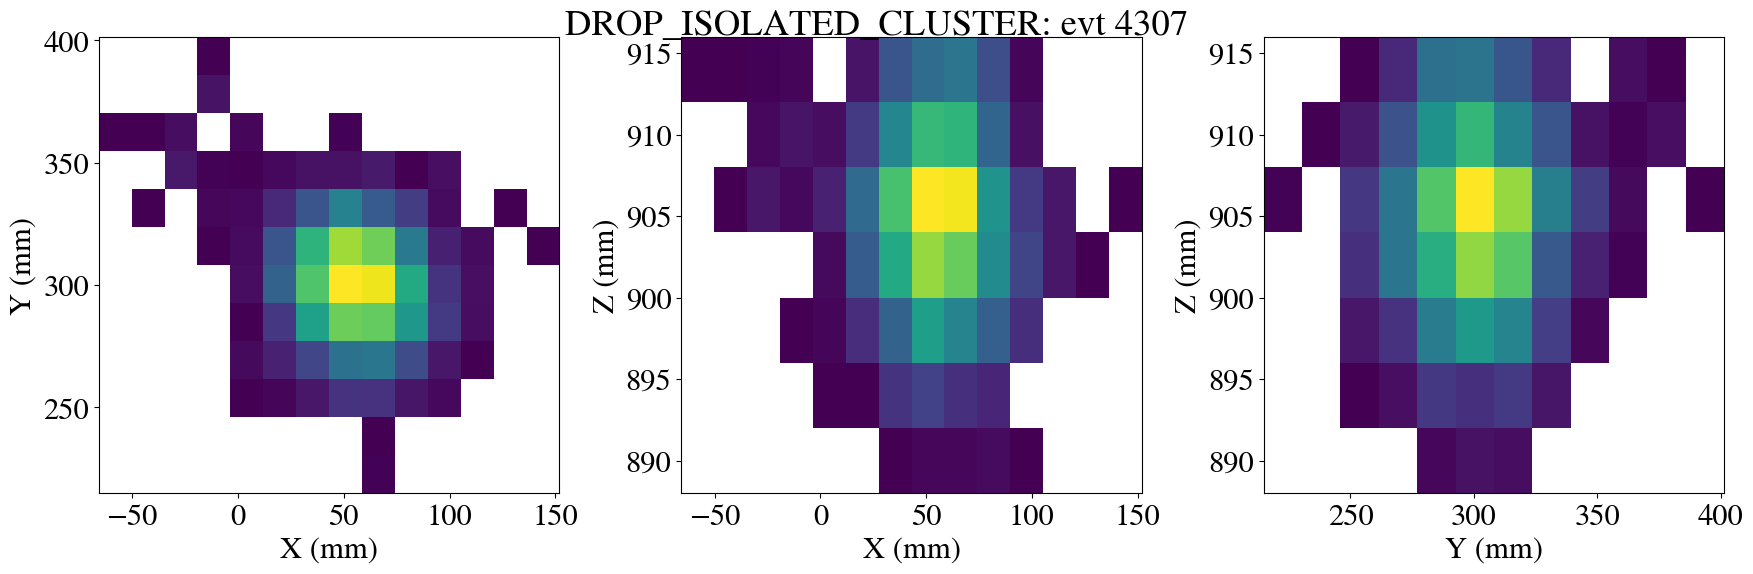

DROP CLUSTER FAST


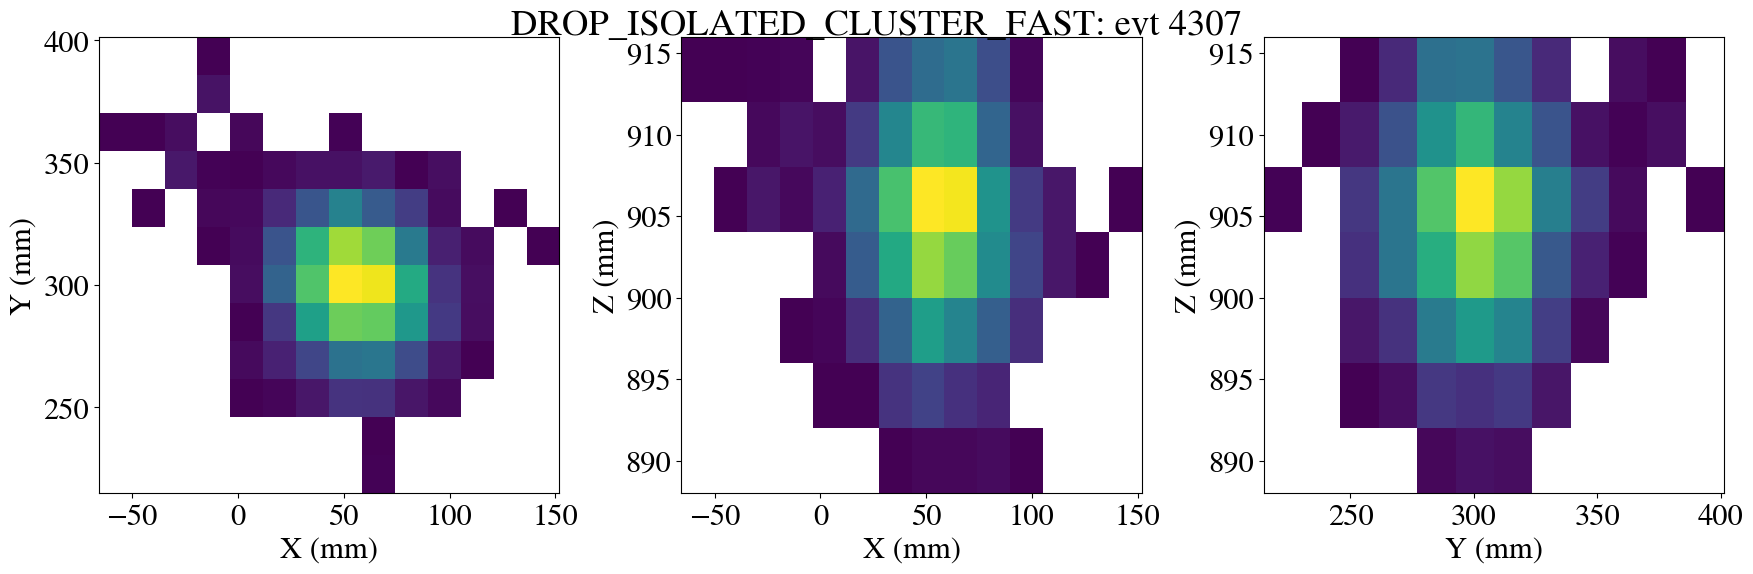

DROP SENSOR


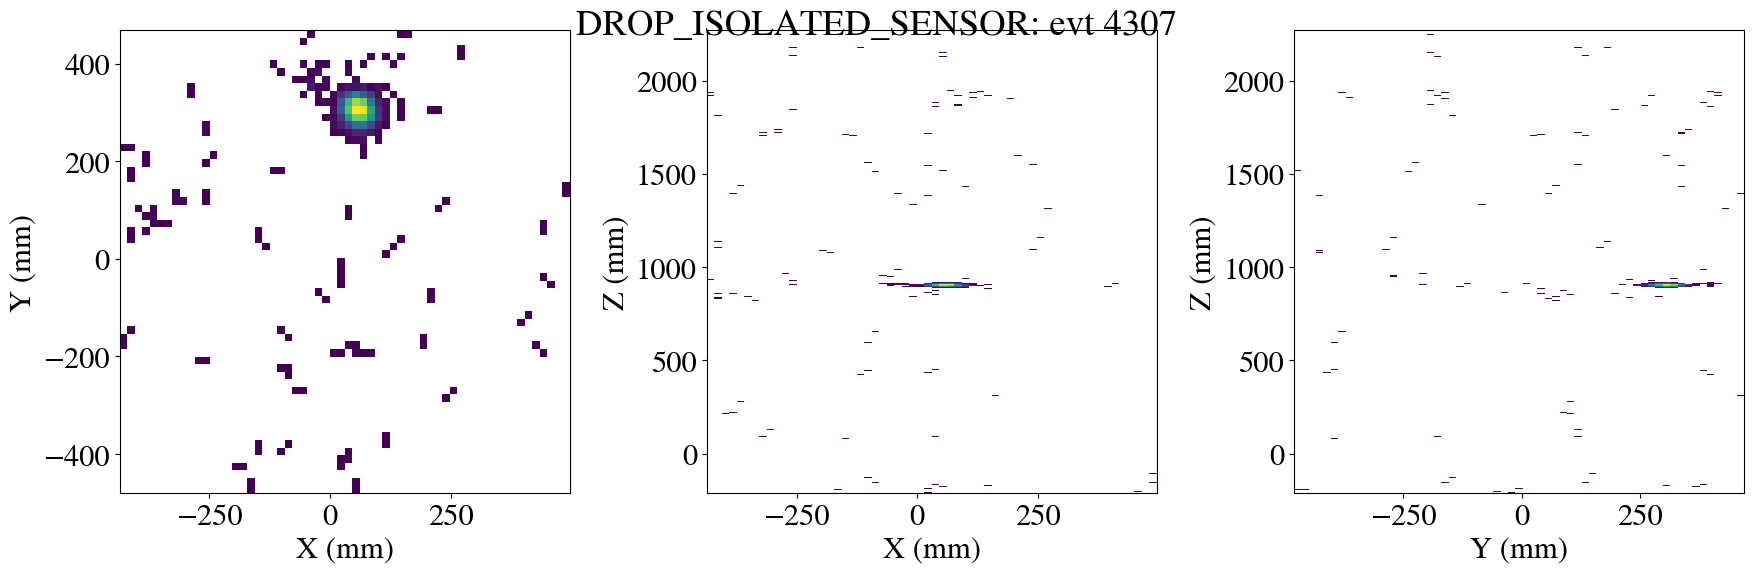

DROP MIRYAM


DROP MIRYAM-2D


=
=
=
=
=
=
=
=
=
=

11 4356
RAW


CUT


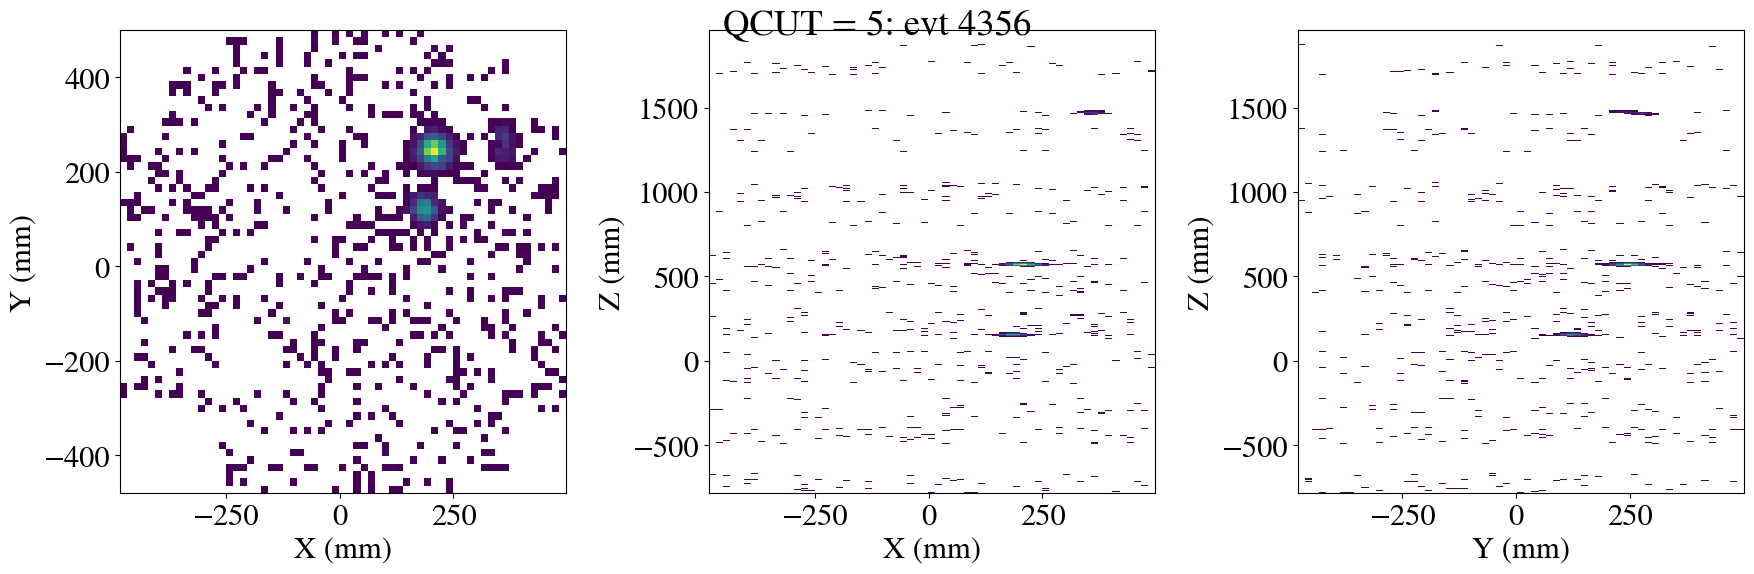

DROP CLUSTER


DROP CLUSTER FAST


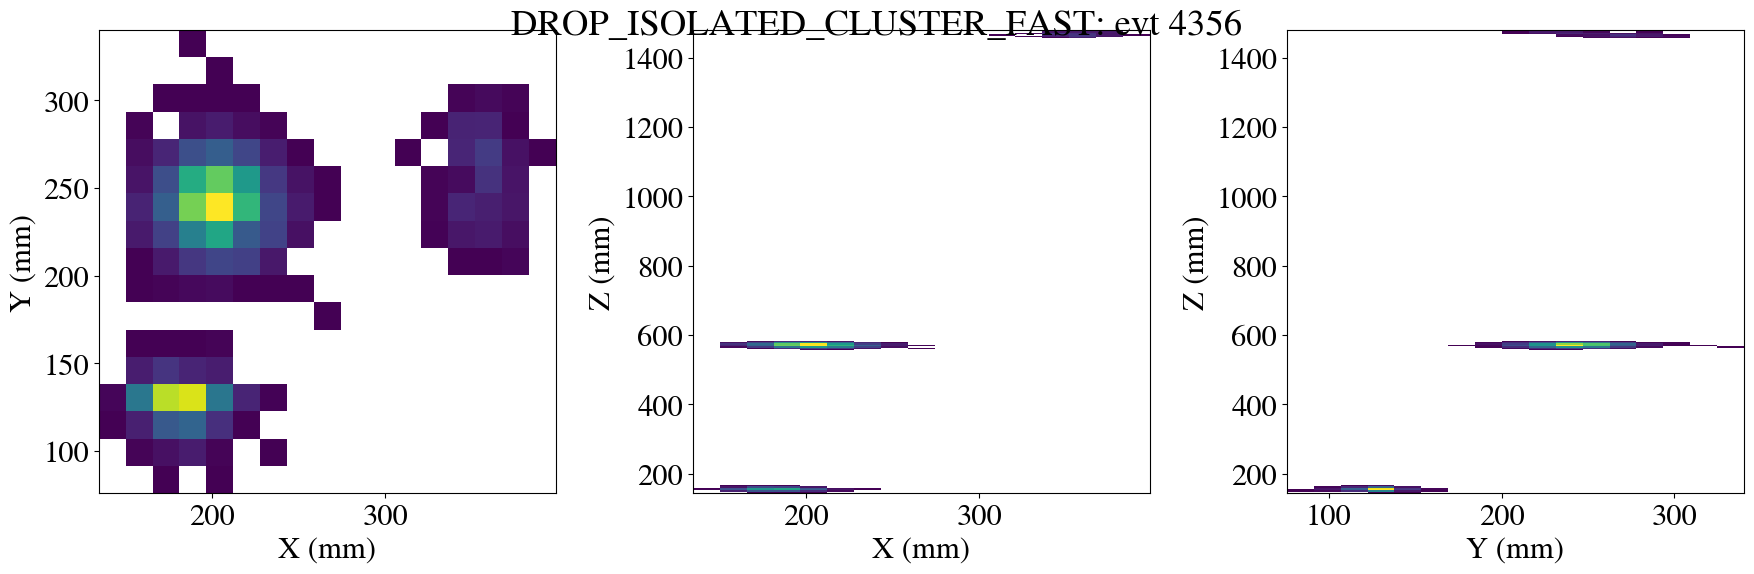

DROP SENSOR


DROP MIRYAM


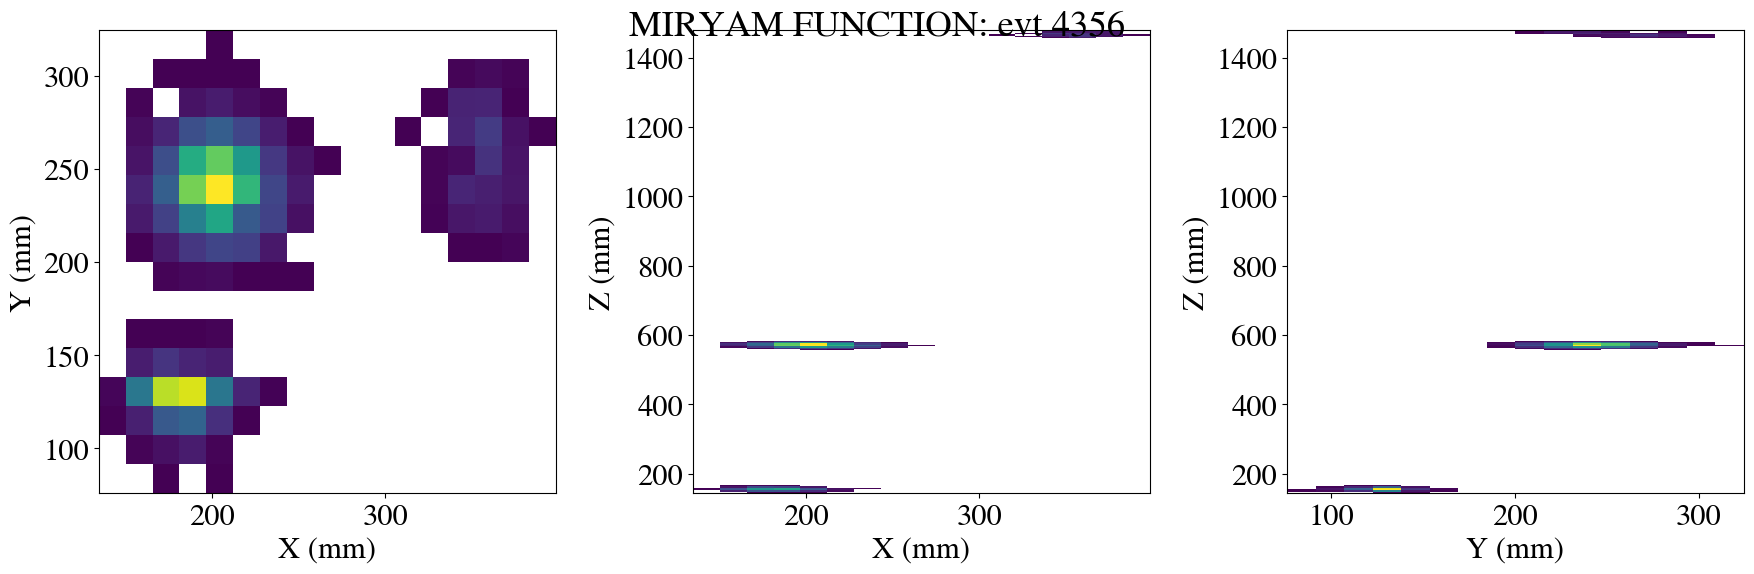

DROP MIRYAM-2D


In [133]:
stopper = 10

for i, evt in enumerate(soph_hdst.event.unique()):
    print('=\n'*10)
    print(i, evt)
    print('=' * 20)
    print('RAW')
    raw_plotter(soph_hdst[soph_hdst.event == evt], evt, title = f'RAW: evt {evt}')
    print('=' * 20)
    print('CUT')
    raw_plotter(cut_hdst[cut_hdst.event == evt], evt, title = f'QCUT = 5: evt {evt}')
    print('=' * 20)
    print('DROP CLUSTER')
    raw_plotter(drop_hdst[drop_hdst.event == evt], evt, title = f'DROP_ISOLATED_CLUSTER: evt {evt}')
    print('=' * 20)
    print('DROP CLUSTER FAST')
    raw_plotter(drop_hdst_kdtree[drop_hdst_kdtree.event == evt], evt, title = f'DROP_ISOLATED_CLUSTER_FAST: evt {evt}')
    print('=' * 20)
    print('DROP SENSOR')
    raw_plotter(drop_hdst_2d[drop_hdst_2d.event == evt], evt, title = f'DROP_ISOLATED_SENSOR: evt {evt}')
    print('=' * 20)
    print('DROP MIRYAM')
    raw_plotter(drop_hdst_miryam[drop_hdst_miryam.event == evt], evt, title = f'MIRYAM FUNCTION: evt {evt}')
    print('=' * 20)
    print('DROP MIRYAM-2D')
    raw_plotter(miryam_2d[miryam_2d.event == evt], evt, title = f'MIRYAM FUNCTION 2D: evt {evt}')
    if i > stopper:
        break

In [52]:
print(soph_hdst.event.nunique())

143
